<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [146]:
import datetime

import numpy as np
import pandas as pd
import sys
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import xgboost as xgb
import json
from pycbrf.toolbox import ExchangeRates, Banks
import lazypredict

from lazypredict.Supervised import LazyRegressor
# from pandas_profiling import ProfileReport
from scipy.stats import ttest_ind
from itertools import combinations
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import StackingRegressor

warnings.simplefilter('ignore')
sns.set()

# Неизвестные значения
UNKNOWN_VAL = -1
# Неизвестные строка
UNKNOWN_STR = 'UNKNOWN'

In [147]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.4 (tags/v3.8.4:dfa645a, Jul 13 2020, 16:46:45) [MSC v.1924 64 bit (AMD64)]
Numpy        : 1.19.1


In [148]:
UNKNOWN_VAL = -1
# Неизвестные строка
UNKNOWN_STR = 'UNKNOWN'

# Состояние  значение по умолчанию
repair_state_no = 'repair_no'
repair_state_yes = 'repair_yes'

In [149]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [150]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [612]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))


def differenceTrainTest(test, train, col):
    model_diff = set(test[col].to_list()) - set(train[col].to_list())
    print('Количество значений признак нет в тренировочном датасете' + str(len(model_diff)))
    print(model_diff)


def Column_lower_strip(data_1=None, data_2=None, col=''):
    """
     Функция предобработк - удаление пробелом по бокам
    """
    if data_1 is not None:
        data_1[col] = data_1[col].str.lower()
        data_1[col] = data_1[col].str.strip()
    if data_2 is not None:
        data_2[col] = data_2[col].str.lower()
        data_2[col] = data_2[col].str.strip()

    if (data_1 is not None) and (data_2 is not None):
        return data_1, data_2
    elif data_1 is not None:
        return data_1


def reDefineColor(data, col):
    """
        Переопределение цвета
    :param data:
    :param col:
    :return data:
    """
    color_dict = {'040001': 'чёрный',
                  '40001': 'чёрный',
                  'EE1D19': 'красный',
                  '0000CC': 'синий',
                  'CACECB': 'серебристый',
                  '007F00': 'зелёный',
                  'FAFBFB': 'белый',
                  '97948F': 'серый',
                  '22A0F8': 'голубой',
                  '660099': 'пурпурный',
                  '200204': 'коричневый',
                  'C49648': 'бежевый',
                  'DEA522': 'золотистый',
                  '4A2197': 'фиолетовый',
                  'FFD600': 'жёлтый',
                  'FF8649': 'оранжевый',
                  'FFC0CB': 'розовый'}
    data[col].replace(to_replace=color_dict, inplace=True)
    return data


# TODo ANALIZ
def getEmptyValue(data, col):
    """
     Функция получение информации о пропусках или пустых значения категориальнх признаков
    """
    train = data.query('sample == 1')
    test = data.query('sample == 0')

    x = train[col].unique()
    empty_x = (train[col] == '').sum()
    print('Количество уникальных значений для train ' + str(len(x)))
    print('Количество пропусков значений   для train ' + str(empty_x))

    y = test[col].unique()
    empty_y = (test[col] == '').sum()
    print('Количество уникальных значений для test ' + str(len(y)))
    print('Количество пропусков значений   для test ' + str(empty_y))


# TODo ANALIZ
def definePopularColumn(data, col, sample=1):
    """
    Определяет 10 самых популярных значений
    """
    train = data.query('sample == ' + str(sample))

    popular = train[col].value_counts().head(10).to_dict()
    return popular


# TODo ANALIZ
def defineDiffPopularCol(data, col):
    """
        определение разницы значений признаков
    :param data:
    :param col:
    :return:
    """

    train = data.query('sample == 1')
    train_val = train[col].value_counts().to_dict()

    test = data.query('sample == 0')
    test_val = test[col].value_counts().to_dict()

    print("Значений которых нет в test Но есть в train")
    print(set(train_val) - set(test_val))
    print("Значений которых нет в train Но есть в test")
    print(set(test_val) - set(train_val))


# TODo ANALIZ
def get_boxplot(data, column):
    """
    Функция для отрисовки коробочной диаграммы для нечисловых признаков.

    На вход получаем колоноку, для которой строим график.
    График отрисовываем относительно целевой переменной pricing, ограниченной по квантилю.
    """
    fig, ax = plt.subplots(figsize=(25, 5))
    plt.subplots_adjust(wspace=0.5)
    sns.boxplot(x=column, y='price',
                data=data,
                ax=ax)
    plt.xticks(rotation=45)
    # поскольку в price много выбросов, огриничимся 75% квантилем
    ax.set_ylim(0, (data.price.quantile(0.75) + 8 *
                    (data.price.quantile(0.75) - data.price.quantile(0.25))))
    ax.set_title('Boxplot для ' + column, fontsize=20)
    plt.show()


# TODo ANALIZ
def analiz_catigarial_feature(data, col, sample=1):
    """
        Гиисрограмма признаков - категориадльных
    :param data:
    :param col:
    :param sample:
    :return:
    """

    if sample == 0 or sample == 1:
        train = data.query('sample == ' + str(sample))
    else:
        train = data

    fig, axes = plt.subplots(figsize=(30, 8))

    mean = train[col].value_counts().values.mean()
    x = train[col].unique()

    if sample == 0 or sample == 1:
        sns.histplot(data=train, x=train[col],
                     stat='count', bins=data[col].nunique())
    else:
        sns.histplot(data=train, x=train[col],
                     stat='count', bins=data[col].nunique(), hue='sample')

    axes.plot(x, [mean for i in x], '--', color='r')
    plt.xticks(rotation=45)
    plt.xlabel(col, fontsize=20)
    plt.ylabel('Количество', rotation='horizontal')

    plt.title('Распределение количества объясвлений по ' + col, fontsize=20)
    fig.suptitle('Общее количество элементов ' + str(len(x)), fontsize=22, fontweight='bold')
    plt.show()

    # Строим боксплот
    get_boxplot(train, col)


def getSellIdModel_fromURL(data):
    """
        Функция получения МОДЕЛИ И ИД ПРОДАВЦА ИЗ URL МАШИНЫ
        ИЛИ если url датасете нет - ставим значение по умолчанию
    """
    if ('car_url' in data.columns) and ('model' not in data.columns):
        data['model'] = str(data['car_url'].str.split('/').str.get(7).str.strip()).lower()

        dict = {
            r'\n[0-9]*': ''

        }
        data['model'].replace(regex=dict, inplace=True)
        # data['model'] = re.sub(r'\n[0-9]', '', data['model'] )

    elif 'model' not in data.columns:
        data['model'] = UNKNOWN_STR

    if ('car_url' in data.columns) and ('sell_id' not in data.columns):
        data['sell_id_arr'] = data['car_url'].str.split('/').str.get(-2).str.strip()
        data['sell_id'] = data['sell_id_arr'].str.split('-').str.get(0).str.strip()

        data.drop('sell_id_arr', axis=1, inplace=True)
    else:
        data['sell_id'] = UNKNOWN_VAL
    return data


def replaceBodyType(data_1, data_2=None, col=''):
    """
     Функция унификации типов кузовов
    :param data_1:
    :param data_2:
    :param col:
    :return:
    """
    dic = {
        r'внедорожник 3 дв.*': 'внедорожник 3 дв.',
        r'внедорожник 5 дв.*': 'внедорожник 5 дв.',
        r'внедорожник открытый.*': 'внедорожник открытый',
        r'кабриолет.*': 'кабриолет',
        r'компактвэн.*': 'компактвэн',
        r'купе.*': 'купе',
        r'купе-хардтоп.*': 'купе-хардтоп',
        r'лимузин.*': 'лимузин',
        r'лифтбек.*': 'лифтбек',
        r'микровэн.*': 'микровэн',
        r'минивэн.*': 'минивэн',
        r'пикап двойная кабина.*': 'пикап двойная кабина',
        r'пикап одинарная кабина.*': 'пикап одинарная кабина',
        r'пикап полуторная кабина.*': 'пикап полуторная кабина',
        r'родстер.*': 'родстер',
        r'седан \d+.*': 'седан 2 дв.',
        r'седан-хардтоп.*': 'седан-хардтоп',
        r'седан [a-zA-Z]+.*': 'седан',
        r'тарга.*': 'тарга',
        r'универсал 5 дв.*': 'универсал 5 дв.',
        r'фастбек.*': 'фастбек',
        r'фургон.*': 'фургон',
        r'хэтчбек 3 дв.*': 'хэтчбек 3 дв.',
        r'хэтчбек 4 дв.*': 'хэтчбек 4 дв.',
        r'хэтчбек 5 дв.*': 'хэтчбек 5 дв.'}

    data_1[col].replace(regex=dic, inplace=True)
    if data_2 is not None:
        data_2[col].replace(regex=dic, inplace=True)
    if data_2 is None:
        return data_1
    else:
        return data_1, data_2


def trainDefineState(data_1, data_2=None, col=''):
    """
     Переопределение параметров состояния постави по умолдчанию не требует ремонта
    :param col:
    :return:
    """

    data_1[col].fillna(repair_state_no, inplace=True)
    if data_2 is not None:
        data_1[col].fillna(repair_state_no, inplace=True)

    replace_item = {
        'не требует ремонта': repair_state_no,
        'битый / не на ходу': repair_state_yes,
    }

    # data_1[col].replace(to_replace=replace_item, inplace=True)
    data_1 = data_1.replace({col: replace_item})

    if data_2 is not None:
        data_2 = data_2.replace({col: replace_item})
    if data_2 is None:
        return data_1
    else:
        return data_1, data_2


def json_to_series(row, params, some):
    super_gen = json.loads(row['super_gen'])
    row['vehicleTransmission'] = super_gen['transmission']
    row['drivertrain'] = super_gen['gear_type']
    if 'acceleration' in super_gen:
        row['racing'] = super_gen['acceleration']
    else:
        row['racing'] = -1
    return row


def testTransmission(data):
    """
        Функция вытаскивания признака тип передачи из тестового набора
    :param data:
    :param col:
    :return:
    """
    data = data.apply(json_to_series, args=([], 1), axis=1)
    data['vehicleTransmission'].replace({
        r'AUTOMATIC': 'Автомат', r'MECHANICAL': 'Механика',
        r'VARIATOR': 'Вариатор', r'ROBOT': 'Робот'}, inplace=True)

    data['drivertrain'].replace({
        r'FORWARD_CONTROL': 'передний', r'ALL_WHEEL_DRIVE': 'полный',
        r'REAR_DRIVE': 'задний'}, inplace=True)
    return data


def testDriveSide(data, col):
    """
         Функция замены стороны руля - и унификация признака
    :param data:
    :param col:
    :return:
    """
    data[col].replace({
        r'левый': 'LEFT', r'правый': 'RIGHT'}, inplace=True)
    return data


def testOnwerCounts(data_1, col=''):
    """
        Унификация признака кол-во владельцев
    :param data_1:
    :param col:
    :return:
    """
    data_1[col].replace({
        '1 владелец': 'one', "2 владельца": 'two', "3 или более": 'three more'}, inplace=True)

    return data_1


def testPTS(data_1, col=''):
    """
        Унификация признака PTS
    :param data_1:
    :param col:
    :return:
    """
    data_1[col].replace({
        "оригинал": "ORIGINAL", "Оригинал": "ORIGINAL", "дубликат": "DUPLICATE"}, inplace=True)
    return data_1


def testСustoms(data_1, col=''):
    """
        Унификация признака PTS
    :param data_1:
    :param col:
    :return:
    """
    data_1[col].replace({
        "растаможен": "TRUE"}, inplace=True)
    return data_1


def trainVehicleTransmission(data, col):
    """
        Функция переименовывание привода
    :param data:
    :param col:
    :return data:
    """
    data[col].replace({
        r'AUTOMATIC': 'Автомат', r'MECHANICAL': 'Механика',
        r'VARIATOR': 'Вариатор', r'ROBOT': 'Робот'}, inplace=True)
    return data


def reDefineTrainEnginDisplacement(row, params, some):
    name = str(row['name'])
    volume = re.findall('\d\.\d', name)

    value_define = -1
    if len(volume) >= 1:
        value_define = volume[0]

    row['engineDisplacement'] = value_define
    return row


def trainEnginEDisplacement(data, col):
    """
        В тренивочном наборе отсутувет значение - берем его из поля name
    :param data:
    :param col:
    :return train:
    """
    data = data.apply(reDefineTrainEnginDisplacement, args=([], 1), axis=1)
    return data[data[col] != -1]


def trainOnwerCounts(data_1=None, data_2=None, col=''):
    data_1[col] = data_1[col].astype(int)

    data_1[col].replace({
        0: 'non', 1: 'one', 2: 'two', 3: 'three more'}, inplace=True)

    data_2[col].replace({
        0: 'non', 1: 'one', 2: 'two', 3: 'three more'}, inplace=True)
    return data_1, data_2


def preColumnToInt(data_1, data_2=None, col=''):
    """
     Функция преобразования к числу + проверка
    :param data_1:
    :param data_2:
    :param col:
    :return:
    """
    # data_1 = data_1[data_1[col].apply(lambda x: str(x).isdigit())]
    data_1[col] = data_1[col].astype(int)

    if data_2 is not None:
        # data_2 = data_2[data_2[col].apply(lambda x: str(x).isdigit())]
        data_2[col] = data_2[col].astype(int)

    if data_2 is None:
        return data_1
    else:
        return data_1, data_2


def preColumnToFloat(data_1, data_2, col):
    data_1[col] = data_1[col].astype(float)
    data_2[col] = data_2[col].astype(float)
    return data_1, data_2


def redefineDateToInix(data, col):
    """
        Функция удаление  незапролненных строк + выстаскивание даты  из даты год
    :param data:
    :param col:
    :return:
    """
    data.dropna(subset=[col], inplace=True)

    data[col] = pd.to_datetime(data[col], format='%Y-%m-%dT%H:%M:%S', errors='coerce')
    data['start_year'] = data[col].dt.year
    data['start_day'] = data[col].dt.strftime('%Y-%m-%d')
    return data


def reDefineTimstampToDate(data, drob=False, col=''):
    """
        Функция удаление незапролненных строк + выстаскивание даты  из unixtimeStamp
    :param drob:
    :param data:
    :param col:
    :return:
    """
    if drob:
        data.dropna(subset=[col], inplace=True)
    data[col] = pd.to_datetime(data[col], unit='s')
    data['start_year'] = data[col].dt.year
    data['start_day'] = data[col].dt.strftime('%Y-%m-%d')
    return data


def defineRacing(date_1, date_2, col):
    """
        Функция определяет время разгона - так как значения в готовом train нет - ставим значение по умолчанию
    :param date_1:
    :param date_2:
    :param col:
    :return:
    """
    # по умолчанию поставим
    date_1[col] = UNKNOWN_VAL
    date_2.dropna(subset=[col], inplace=True)
    return date_1, date_2


# Алвавт всех  производителей
vendor_dic = {}
vendor_dic['EUROPEAN'] = ['PORSCHE', 'LANDROVER', 'JAGUAR',
                          'MINI', 'RENAULT', 'OPEL', 'PEUGEOT', 'CITROEN', 'LAND ROVER', 'ROLLS-ROYCE', 'VOLKSWAGEN',
                          'MERCEDES-BENZ', 'BMW', 'FERRARI', 'AUDI', 'LAMBORGHINI', 'VOLVO', 'SKODA', 'FIAT', 'BENTLEY',
                          'VORTEX', 'MASERATI', 'SMART', 'MATRA', 'ALFAROMEO', 'SEAT', 'TATRA', 'DACIA', 'MAYBACH',
                          'MERCEDES', 'ROVER', 'SAAB', 'EXEED', 'BUGATTI', 'ASTONMARTIN', 'LANCIA']
vendor_dic['RUSSIAN'] = ['LADA(ВАЗ)', 'УАЗ', 'ГАЗ', 'ЗАЗ', 'ИЖ', 'МОСКВИЧ', 'ТАГАЗ', 'DONINVEST', 'DERWAYS']
vendor_dic['ARABIC'] = ['IRANKHODRO']
vendor_dic['JAPANESE'] = ['SUBARU', 'MAZDA', 'SUZUKI', 'LEXUS', 'TOYOTA', 'NISSAN', 'INFINITI', 'MITSUBISHI', 'HONDA',
                          'DATSUN', 'ISUZU', 'ACURA', 'DAIHATSU']
vendor_dic['AMERICAN'] = ['CHEVROLET', 'CHRYSLER', 'CADILLAC', 'JEEP', 'FORD', 'DODGE', 'RAM', 'PONTIAC', 'HUMMER',
                          'LINCOLN', 'SATURN', 'BUICK', 'TESLA', 'MERCURY', 'GMC']
vendor_dic['ASIAN'] = ['HYUNDAI', 'DAEWOO', 'KIA', 'CHERY', 'SSANG YONG', 'GEELY', 'GREATWALL', 'LIFAN', 'SSANGYONG',
                       'FAW', 'GENESIS', 'HAVAL', 'DONGFENG', 'JAC', 'RAVON', 'CHANGAN', 'BYD', 'ZX', 'HAIMA', 'DADI',
                       'BRILLIANCE', 'LUXGEN', 'ZOTYE']


def defineVendorRow(row, params, some):
    find = False
    search_brand = str(row['brand']).replace('_', '').replace(' ', '').upper().strip()
    for vendor, brand in vendor_dic.items():
        if search_brand in brand:
            row['vendor'] = vendor
            find = True
            break
    if not find:
        print('Не нашел производителя для марки ')
        print(row['brand'])
        print(search_brand)
        row['vendor'] = ''
    return row


def defineVendor(data_1, data_2, col):
    """
        Функция определения страны производителя
    :param data_1:
    :param data_2:
    :param col:
    :return:
    """
    data_1.dropna(subset=[col], inplace=True)
    data_2.dropna(subset=[col], inplace=True)

    data_1 = data_1.apply(defineVendorRow, args=([], 1), axis=1)
    data_2 = data_2.apply(defineVendorRow, args=([], 1), axis=1)
    return data_1, data_2


def UseCourseDate(row, params, some):
    rates = ExchangeRates(row['start_day'], locale_en=True)
    usd_rate = float(rates['USD'].value)
    if usd_rate >= 0:
        price = float(row['price'])
        row['usd'] = round(usd_rate, 2)
        row['price_usd'] = round(price / usd_rate, 2)
    else:
        row['price_usd'] = 0
        row['usd'] = 0
    return row


def defineUSDCourese(data_1, data_2):
    data_1 = data_1.apply(UseCourseDate, args=([], 1), axis=1)
    data_2 = data_2.apply(UseCourseDate, args=([], 1), axis=1)
    return data_1, data_2


# TODO УНИФИКАЦИЯ тренировчных наборов
def normolizeTrainsData(train, train_new):
    """
    Унификация датасетов - те же поля и тот же тип данныъх по столбцам
    train -  изначачальный датасет
    train_new -  спарсенный датасет с сайта

    :param train:
    :param train_new:
    :return train:
    """
    # предобработка столцов
    train.columns = [col.replace('\r', '').replace('\n', '').strip() for col in train.columns]
    train_new.columns = [col.replace('\r', '').replace('\n', '').strip() for col in train_new.columns]

    train.dropna(subset=['bodyType', 'modelDate', 'numberOfDoors', 'enginePower', 'engineDisplacement',
                         'price'], inplace=True)
    train_new.dropna(subset=['bodyType', 'modelDate', 'numberOfDoors', 'enginePower', 'engineDisplacement',
                             'price'], inplace=True)

    columnc = []
    #  нет поля car_url
    train['car_url'] = ''
    columnc.append('car_url')

    # bodyType -
    pd.options.display.max_rows = 1000
    train, train_new = Column_lower_strip(train, train_new, 'bodyType')
    train, train_new = replaceBodyType(train, train_new, 'bodyType')
    columnc.append('bodyType')

    # brand
    train, train_new = Column_lower_strip(train, train_new, 'brand')
    columnc.append('brand')

    # color
    train = reDefineColor(train, 'color')
    train, train_new = Column_lower_strip(train, train_new, 'color')
    columnc.append('color')

    # fuelType
    train, train_new = Column_lower_strip(train, train_new, 'fuelType')
    columnc.append('fuelType')

    # modelDate
    train, train_new = preColumnToInt(train, train_new, 'modelDate')
    columnc.append('modelDate')

    # numberOfDoors
    train, train_new = preColumnToInt(train, train_new, 'numberOfDoors')
    columnc.append('numberOfDoors')

    # productionDate
    train, train_new = preColumnToInt(train, train_new, 'productionDate')
    columnc.append('productionDate')

    # vehicleTransmission
    train = trainVehicleTransmission(train, 'vehicleTransmission')
    train, train_new = Column_lower_strip(train, train_new, 'vehicleTransmission')
    columnc.append('vehicleTransmission')

    #  engineDisplacement - объем дигателя
    train = trainEnginEDisplacement(train, 'engineDisplacement')
    train, train_new = preColumnToFloat(train, train_new, 'engineDisplacement')
    train['engineDisplacement'].fillna(0, inplace=True)
    train_new['engineDisplacement'].fillna(0, inplace=True)
    columnc.append('engineDisplacement')

    #  enginePower - объем дигателя - удалим отсуствующие строки
    train.dropna(subset=['enginePower'], inplace=True)
    train_new.dropna(subset=['enginePower'], inplace=True)
    columnc.append('enginePower')

    # description - описание
    train['description'].fillna('', inplace=True)
    train_new['description'].fillna('', inplace=True)
    columnc.append('description')

    # mileage - пробег (по умолчанию )
    train['mileage'].fillna(0, inplace=True)
    train_new['mileage'].fillna(0, inplace=True)
    columnc.append('mileage')

    # drivertrain (Привод) - удалим отсуствующие значения
    train.rename({'Привод': 'drivertrain'}, axis=1, inplace=True)
    train.dropna(subset=['drivertrain'], inplace=True)

    train_new.rename({'Привод': 'drivertrain'}, axis=1, inplace=True)
    train_new.dropna(subset=['drivertrain'], inplace=True)
    train, train_new = Column_lower_strip(train, train_new, 'drivertrain')
    columnc.append('drivertrain')

    # driverSide (Руль) - удалим отсуствующие значения
    train.rename({'Руль': 'driverSide'}, axis=1, inplace=True)
    train.dropna(subset=['driverSide'], inplace=True)

    train_new.rename({'Руль': 'driverSide'}, axis=1, inplace=True)
    train_new.dropna(subset=['driverSide'], inplace=True)
    columnc.append('driverSide')

    # ownersCount (Владельцы) - владельцы количество ( по умолчанию 0)
    #  представим это значение как категориальное
    train.rename({'Владельцы': 'ownersCount'}, axis=1, inplace=True)
    train['ownersCount'].fillna(0, inplace=True)

    train_new.rename({'Владельцы': 'ownersCount'}, axis=1, inplace=True)
    train_new['ownersCount'].fillna(0, inplace=True)
    train, train_new = trainOnwerCounts(train, train_new, 'ownersCount')
    columnc.append('ownersCount')

    # pts (ПТС) - ПТС
    train.rename({'ПТС': 'pts'}, axis=1, inplace=True)
    train_new.rename({'ПТС': 'pts'}, axis=1, inplace=True)

    train['pts'].fillna('ORIGINAL', inplace=True)
    train_new['pts'].fillna('ORIGINAL', inplace=True)
    columnc.append('pts')

    #  state - Состояние
    train.rename({'Состояние': 'state'}, axis=1, inplace=True)
    train_new.rename({'Состояние': 'state'}, axis=1, inplace=True)
    train['state'].fillna(repair_state_no, inplace=True)
    train_new['state'].fillna(repair_state_no, inplace=True)
    train, train_new = Column_lower_strip(train, train_new, 'state')
    train, train_new = trainDefineState(train, train_new, 'state')
    columnc.append('state')

    # customs  (Таможня) -  Таможня
    train.rename({'Таможня': 'customs'}, axis=1, inplace=True)
    train_new.rename({'Таможня': 'customs'}, axis=1, inplace=True)
    columnc.append('customs')

    # start_date  - удлаим пропуски + выделим из даты год (для вычисления новх признаков)
    train = redefineDateToInix(train, 'start_date')
    train_new = reDefineTimstampToDate(train_new, True, 'start_date')
    columnc.append('start_year')
    columnc.append('start_day')

    # model - модель авто
    train_new = getSellIdModel_fromURL(train_new)
    train, train_new = Column_lower_strip(train, train_new, 'model')
    columnc.append('model')

    # vendor - Страна
    train, train_new = defineVendor(train, train_new, 'brand')
    columnc.append('vendor')

    # racing - время разгона
    train, train_new = defineRacing(train, train_new, 'racing')
    columnc.append('racing')

    # price_usd - цена в долларах
    # train, train_new = defineUSDCourese(train, train_new)
    train['price_log'] = np.log(train['price'])
    train_new['price_log'] = np.log(train_new['price'])
    columnc.append('price')
    columnc.append('price_log')
    # columnc.append('price_usd')
    # columnc.append('usd')

    # sell_id
    train['sell_id'] = 0
    train_new['sell_id'] = 0
    columnc.append('sell_id')

    train = train[columnc]
    train_new = train_new[columnc]

    bigdata = train.append(train_new, ignore_index=True)
    return bigdata

# Setup

In [613]:
# ДЛЯ KAGGLA
# VERSION    = 16
# DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
# DIR_TEST   = '../input/sf-dst-car-price-prediction/'
# VAL_SIZE   = 0.20   # 20%

In [614]:
# ДЛЯ ЧТЕНИЯ ИЗ ДАННЫХ неакомпьютере
VERSION = 16
DIR_TRAIN = 'input/'
DIR_TEST = 'input/'
VAL_SIZE = 0.20  # 20%

# Data

In [615]:
!ls '../input'

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [616]:
train = pd.read_csv(DIR_TRAIN + 'all_auto_ru_09_09_2020.csv', lineterminator='\n')
test = pd.read_csv(DIR_TEST + 'test.csv')
sample_submission = pd.read_csv(DIR_TEST + 'sample_submission.csv')

In [617]:
train.head(5)

bodyType brand   color fuelType modelDate                   name  \
0            Седан  AUDI   40001   бензин      1990  2.8 MT (174 л.с.) 4WD   
1            Седан  AUDI  EE1D19   бензин      1982       1.8 MT (90 л.с.)   
2  Универсал 5 дв.  AUDI  0000CC   бензин      1988  2.3 MT (136 л.с.) 4WD   
3            Седан  AUDI  CACECB   бензин      1988       1.8 MT (90 л.с.)   
4            Седан  AUDI   40001   бензин      1990      2.0 MT (101 л.с.)   

  numberOfDoors productionDate          vehicleConfiguration  \
0             4           1991          SEDAN MECHANICAL 2.8   
1             4           1986          SEDAN MECHANICAL 1.8   
2             5           1989  WAGON_5_DOORS MECHANICAL 2.3   
3             4           1989          SEDAN MECHANICAL 1.8   
4             4           1991          SEDAN MECHANICAL 2.0   

  vehicleTransmission  ...  Руль Состояние Владельцы        ПТС Таможня  \
0          MECHANICAL  ...  LEFT       NaN      3.00   ORIGINAL    True   
1          MECHANICAL  ...  LEFT       NaN      3.00   ORIGINAL    True   
2          MECHANICAL  ...  LEFT       NaN      3.00   ORIGINAL    True   
3          MECHANICAL  ...  LEFT       NaN      3.00   ORIGINAL    True   
4          MECHANICAL  ...  LEFT       NaN      3.00  DUPLICATE    True   

  Владение     price            start_date  hidden model\r  
0      NaN 200000.00  2019-10-03T08:09:11Z     NaN   100\r  
1      NaN  60000.00  2020-09-06T06:49:40Z     NaN   100\r  
2      NaN  99000.00  2020-09-02T14:04:21Z     NaN   100\r  
3      NaN  65000.00  2020-08-23T17:40:09Z     NaN   100\r  
4      NaN 100000.00  2020-09-08T09:22:07Z     NaN   100\r  

[5 rows x 26 columns]

In [618]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89474 entries, 0 to 89473
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89434 non-null  object 
 1   brand                 89424 non-null  object 
 2   color                 89413 non-null  object 
 3   fuelType              89405 non-null  object 
 4   modelDate             89399 non-null  object 
 5   name                  89395 non-null  object 
 6   numberOfDoors         89390 non-null  object 
 7   productionDate        89383 non-null  object 
 8   vehicleConfiguration  89381 non-null  object 
 9   vehicleTransmission   89380 non-null  object 
 10  engineDisplacement    89378 non-null  object 
 11  enginePower           89378 non-null  object 
 12  description           86125 non-null  object 
 13  mileage               89378 non-null  object 
 14  Комплектация          89377 non-null  object 
 15  Привод             

In [619]:
test.head(5)

bodyType  brand                                            car_url  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   
3  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
4  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   

        color                                 complectation_dict  \
0       синий                                                NaN   
1      чёрный                                                NaN   
2       серый  {"id":"20026336","name":"Ambition","available_...   
3  коричневый  {"id":"20803582","name":"Ambition","available_...   
4       белый                                                NaN   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6 LTR   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
3     110 N12  {"cruise-control":true,"roller-blind-for-rear-...   бензин   
4     152 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   

   ...     vehicleConfiguration  vehicleTransmission    vendor    Владельцы  \
0  ...       LIFTBACK ROBOT 1.2     роботизированная  EUROPEAN  3 или более   
1  ...  LIFTBACK MECHANICAL 1.6         механическая  EUROPEAN   1 владелец   
2  ...       LIFTBACK ROBOT 1.8     роботизированная  EUROPEAN   1 владелец   
3  ...   LIFTBACK AUTOMATIC 1.6       автоматическая  EUROPEAN   1 владелец   
4  ...   LIFTBACK AUTOMATIC 1.8       автоматическая  EUROPEAN   1 владелец   

  Владение       ПТС    Привод   Руль           Состояние     Таможня  
0      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
1      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
2      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
3      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
4      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  

[5 rows x 32 columns]

test.info()

##  Data Parsing
Как показал анализ анализ датасетов как тестовой, обучемой так и спарсеной из сайта AUTO.ru. Необходимо эти датасеты привести в 
единное пространство признаков. 

# Описание какие параметры откуда брались

Единное простанство признаков подразумевает собой не только одинакоые столбы, но и  преобразование параметров их типов в одинаковые поля. В чатности train датасет представлен не только готовым данныи и данными спарсенными с сайта, это требует подхода унификации как данных так и типов данных при объединение этого массива - это выполянет функция normolizeTrainsData

Такая же функция normolizeTestData - унифицирует данные test, то есть приводит к одному виду с train датасетом выбирает те признаки которые мы будеи выделять 

такой подход требуется, так как данные представны из разных исчтоников, имеют разные типы и представлены разными в разных 
колонках у различных данных!

Ниже представлены уже преобразвоанные датасеты.


In [620]:
# обединим параметры готовые датасет с датесетом 
# train = pd.read_csv(DIR_TRAIN + 'all_auto_ru_09_09_2020.csv', lineterminator='\n')
# train_new = pd.read_csv(DIR_TRAIN + 'Base.csv', lineterminator='\n')
# train = normolizeTrainsData(train, train_new)
# train = normolizeTrainsData(train, train_new)

In [621]:
# УЖЕ объединенныые параметры! 
train_formated = pd.read_csv(DIR_TEST + 'Base_all.csv')
test_formated = pd.read_csv(DIR_TEST + 'test_all.csv')

In [622]:
test_formated.shape

(34686, 27)

In [623]:
train_formated['model']

0                                                       100
1                                                       100
2                                                       100
3                                                       100
4                                                       100
                                ...                        
119065    0           range_rover_sport                 ...
119066    0           range_rover_sport                 ...
119067    0           range_rover_sport                 ...
119068    0           range_rover_sport                 ...
119069    0           range_rover_sport                 ...
Name: model, Length: 119070, dtype: object

In [624]:
test_formated['model'].value_counts()

octavia     1418
5er         1026
lancer       855
e_klasse     809
passat       782
            ... 
mr_s           1
vellfire       1
verso_s        1
z3m            1
platz          1
Name: model, Length: 544, dtype: int64

In [625]:
train_formated.head(5)

car_url         bodyType brand        color fuelType  modelDate  \
0     NaN            седан  audi       чёрный   бензин       1990   
1     NaN            седан  audi      красный   бензин       1982   
2     NaN  универсал 5 дв.  audi        синий   бензин       1988   
3     NaN            седан  audi  серебристый   бензин       1988   
4     NaN            седан  audi       чёрный   бензин       1990   

   numberOfDoors  productionDate vehicleTransmission  engineDisplacement  ...  \
0              4            1991            механика                2.80  ...   
1              4            1986            механика                1.80  ...   
2              5            1989            механика                2.30  ...   
3              4            1989            механика                1.80  ...   
4              4            1991            механика                2.00  ...   

       state customs  start_year   start_day model    vendor racing     price  \
0  repair_no    True        2019  2019-10-03   100  EUROPEAN  -1.00 200000.00   
1  repair_no    True        2020  2020-09-06   100  EUROPEAN  -1.00  60000.00   
2  repair_no    True        2020  2020-09-02   100  EUROPEAN  -1.00  99000.00   
3  repair_no    True        2020  2020-08-23   100  EUROPEAN  -1.00  65000.00   
4  repair_no    True        2020  2020-09-08   100  EUROPEAN  -1.00 100000.00   

   price_log  sell_id  
0      12.21        0  
1      11.00        0  
2      11.50        0  
3      11.08        0  
4      11.51        0  

[5 rows x 27 columns]

В стандартный набор обработки признаков входит следующие функции
   
   - Column_lower_strip - преобразование в текст с нижним регистром, удаление пробелом по концам
   
   - preColumnToInt - преобразование колнки к типу int


Я выделил несколько признаков, ниже я опишу как находил и как обрабатывал (данныя обработка касается только train датасетов):
    
    - bodyType (корпус) - признак проходит стандартизацию, выделил ряд встречающихся корпусов и составил словарь и заменил этот признак согласно словарю!   Функция - replaceBodyType
    - brand  - брется из строк 'brand' б преобразуется к нижниму регистру
    - color - цвет. В готовом датасете цвет представел в виде RGB, функция  reDefineColor преопределяет название. В датасете спарсенном с сайта изначально приводится назнвание цвета. 
    - fuelType - топливо,  приводится к нижниму регистру в обоих датасетах
    - modelDate - год модели, приводлится  к типу int  preColumnToInt
    - numberOfDoors - количество дверей, приводлится  к типу int preColumnToInt
    - productionDate - год производства модели, приводлится  к типу int preColumnToInt
    - vehicleTransmission - тип передачи, приводится к единообразному виду функцией  trainVehicleTransmission для датасейта представнного к заданию, для дата сета спарсенного с сайта - этот параметр уже представлне как надо
    - engineDisplacement - объем двигателя; для дата сета представленного к заданию есть строки которые пусты поэтому берем данные из строки name; для дата сета спарсенного - этот параметр уже представлне как надо
    - enginePower - сила двигателя; так как это один из параметров модели удалим из обоих датасетов строки с пропускаи
    - description - описание ; оостваим все пока без изменения
    - mileage - пробег; заполним пропсуки нулями
    - drivertrain - привод; удалим пропуски и представим в нижний регистр
    - driverSide  - строна руля; удаляем пропски из датасета
    - ownersCount - колличество владельцев, я хочу представить это параметр как категориальный и функцией trainOnwerCounts привожу его к однмоу виду
    - pts - ПТС; gпропуски заполняем значением ORIGINAL
    - state - состояние авто (repair_yes или repair_no)
    - customs - таможняж оставялвем как есть
    - start_year, start_day - год сканирования и дата в формате "2019-03-11". Для гового датасета функция  redefineDateToInix определяет эти параметры. Для спарсенного датасета те же параметры получаются функцией reDefineTimstampToDate
    start_day - нужна для того чтобы определить курс валюты в этот день! (пока без него)
    - model - модель. В готовом датасете столбец  модели уже есть, для спарсенного модель определяем через url
    - sell_id - ид продавца 
     Например https://auto.ru/cars/used/sale/mercedes/e_klasse_amg/1096012944-024008a5/  - тут  sell_id равен 1096012944
 model равна e_klasse_amg
    - defineVendor - континет производитель. Определим по полю brand (функция defineVendor) , cоставим массив  vendor_dic - и по нему определим это свогйство
    - racing - время разгона. Для готовго датасета значение это неизвестно  - определим его как -1. Для спарсенного значение такое имеется
    - price - цена 
    
    
    
Для датасета **test** также проведем предобработка, для однообразия данных; например Оригинал заменить на ORIGINAL   
Только без удаления данных!   

    - bodyType,brand,color,fuelType,  - в нижний разряд
    - modelDate,numberOfDoors, productionDate  - к типу int
    - vehicleTransmission - приведем к одноу виду (testTransmission)
    - vehicleTransmission,drivertrain, racing - досанем из колоки  super_gen (testTransmission - функция)
    - engineDisplacement - достанем из колонки engineDisplacement
    - enginePower -  оставим из колонки enginePower
    - description - оставим без изменения
    - driverSide - приведем в соответствии  к одним значением  как у train датасетов
    - ownersCount -  приведем в соответствии  к одним значением  как у train датасетов (testOnwerCounts)
    - pts -  приведем в соответствии  к одним значением  как у train датасетов (testPTS)
    - customs -  приведем в соответствии  к одним значением  как у train датасетов (testСustoms)
    - start_date, start_year - достанем из  parsing_unixtime (reDefineTimstampToDate)
    - model - из коллнки model_name
    - vendor  - обрезаем по концам из колонки vendor
    - price - утсанавливаем за 0
 
 
Из идей анализа и нереализованные идеи:      

    1. image - изображения. Пока для нас интресе не представляет (нельзя распознать объект машину и вытащить оттуда параметры).
    2. equipment_dict - вообщем это список оборудования машины. Из-за отсутвия времени на парсинг со страницы я пока пропущу эти данные.
    3. priceCurrency - наименование валюты. Вообще неплохо проверить гипотезу о влияние валюты (инфляции) на стоимость и перевести цены в доллары. Пока пропустим
    4. complectation_dict - это список комплектации машины. Из-за отсутвия времени на парсинг со страницы я пока пропущу эти данныею  Хотя в принципе можно было вместо зашифровывания этой информации предоставить только модификацию машины - она автоматичеки определяет свойства машины. Как решение не производить парсинг станицы и произвести парсинг модификации машин на тестовой выборке. И представить этот признак категориальный
    5.sell_id - ид продавца. Буджм доставать из url на машину . Например https://auto.ru/cars/used/sale/mercedes/e_klasse_amg/1096012944-024008a5/  - тут  sell_id равен 1096012944
    6. model_name - наименование модели. будем брать такжде из url. Из примера выше  model_info равна e_klasse_amg
    7. parsing_unixtime - время сканиварония. Сконструрием из этого новый признак - возраст машины.
    8.  model нужно объединить в признаком brand. Пока как идея - сгрупировать по типу brand и сформировать новый признак - входит ли модель машины в самые популярные брянда.
    9. раритеная машина - как идея (пока делаем не будем)
    10. Ввести курс валют - в долларах (пока делаем не будем)
    11. Принадлежит ли к популярным маркам  - 10 полпулярных брендов (10 популярных марок) (пока делаем не будем)
    12. Принадлежит ли к популярным моделям  - 10 полпулярных моделей (10 популярных брендов) (пока делаем не будем) Не успеваю! 
    
  
 Новый признаки
 
      1. Возраст машины (разница между временем парсинга и датой произвоства) в годах
      2. Разница между датой модели и датой производства машины
      3. Среднее расcтояние за год
      4. Новая ли машина
  

### Парсинг данных
Данные парсятся с помощью скрипта parser.py. Этот скрипт переходит по всем страницам популярных моделей и заносит данные в файл 
Base.csv. Он формлен в виде класса, так проще инициализировать переменные, например в конструкторе определено свойтсов диспкриптора файла и он доступен на всем протяжении жизни класса. Еще одной особенность является то, что он заносит в память те ссылки которые он уже парсил, таким образом удается избежать повторения парсинга данных


# Первоначальная модель
Для этого чтобы понять в правильном направлении мы движемся,  попробуем на нативной модели предсказать стоимость автомобиля
Данные для теста беруется из уже распарсенных данных.

#### Подготовка данных

In [626]:
train = train_formated #  pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv', lineterminator='\n')
test = test_formated #pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')


# ПЕРВОНЧАЛЬНОЕ ЗНАЧЕНИЕ
train.dropna(subset=['productionDate','mileage'], inplace=True)
train.dropna(subset=['price'], inplace=True)

columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage']
df_train = train[columns]
df_test = test[columns]
y = train['price']

df_train['sample'] = 1
df_test['sample'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)
for colum in ['bodyType', 'brand', 'engineDisplacement']:
    data[colum] = data[colum].astype('category').cat.codes

X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

#### Обучение

In [627]:
model = CatBoostRegressor(iterations = 1000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 22.09%


Вывод: показанна точность.  Какое какое предсказание по стоимости автомобиля есть. 

## Приведение  в единное признакое пространство признаков

Объединим датасеты train и test

Пройдемся по параметрам, проанализируем их. На базе уже существующих внедрним новые признаки и соотнечем их либо к числовым, или бинарным, или категориальным

In [628]:
# TODo ANALIZ
def getEmptyValue(data, col):
    """
     Функция получение информации о пропусках или пустых значения категориальнх признаков
    """
    train = data.query('sample == 1')
    test = data.query('sample == 0')

    x = train[col].unique()
    empty_x = (train[col] == '').sum()
    print('Количество уникальных значений для train ' + str(len(x)))
    print('Количество пропусков значений   для train ' + str(empty_x))

    y = test[col].unique()
    empty_y = (test[col] == '').sum()
    print('Количество уникальных значений для test ' + str(len(y)))
    print('Количество пропусков значений   для test ' + str(empty_y))


# TODo ANALIZ
def definePopularColumn(data, col, sample=1):
    """
    Определяет 10 самых популярных значений
    """
    train = data.query('sample == ' + str(sample))

    popular = train[col].value_counts().head(10).to_dict()
    return popular


# TODo ANALIZ
def defineDiffPopularCol(data, col):
    """
        определение разницы значений признаков
    :param data:
    :param col:
    :return:
    """

    train = data.query('sample == 1')
    train_val = train[col].value_counts().to_dict()

    test = data.query('sample == 0')
    test_val = test[col].value_counts().to_dict()

    print("Значений которых нет в test Но есть в train")
    print(set(train_val) - set(test_val))
    print("Значений которых нет в train Но есть в test")
    print(set(test_val) - set(train_val))

In [629]:
train_formated['sample'] = 1
test_formated['sample'] = 0
data = test_formated.append(train_formated, sort=False).reset_index(drop=True)

# Категориальыне признаки

# brand
бренд модели 

Анализ содержимого тернировочной выборки:

In [630]:
getEmptyValue(data, 'brand')

Количество уникальных значений для train 93
Количество пропусков значений   для train 0
Количество уникальных значений для test 12
Количество пропусков значений   для test 0


In [631]:
definePopularColumn(data, 'brand', 1)

{'hyundai': 9636,
 'volkswagen': 8921,
 'bmw': 8709,
 'kia': 8041,
 'mercedes': 7978,
 'nissan': 7191,
 'toyota': 6273,
 'ford': 5861,
 'audi': 5110,
 'mitsubishi': 4706}

In [632]:
definePopularColumn(data, 'brand', 0)

{'bmw': 4473,
 'volkswagen': 4404,
 'nissan': 4393,
 'mercedes': 4180,
 'toyota': 3913,
 'audi': 3421,
 'mitsubishi': 2843,
 'skoda': 2741,
 'volvo': 1463,
 'honda': 1150}

In [633]:
defineDiffPopularCol(data, 'brand')

Значений которых нет в test Но есть в train
{'ravon', 'lifan', 'maserati', 'saturn', 'lada (ваз)', 'iran khodro', 'москвич', 'geely', 'mercury', 'иж', 'aston martin', 'vortex', 'rolls-royce', 'daewoo', 'land_rover', 'subaru', 'acura', 'doninvest', 'daihatsu', 'jac', 'fiat', 'tatra', 'buick', 'renault', 'smart', 'mazda', 'citroen', 'maybach', 'suzuki', 'pontiac', 'mercedes-benz', 'exeed', 'saab', 'jeep', 'газ', 'chevrolet', 'mini', 'chrysler', 'ferrari', 'bugatti', 'peugeot', 'тагаз', 'land rover', 'dongfeng', 'byd', 'great_wall', 'dodge', 'kia', 'isuzu', 'ssangyong', 'porsche', 'chery', 'luxgen', 'derways', 'haima', 'lincoln', 'seat', 'заз', 'cadillac', 'lancia', 'jaguar', 'alfa romeo', 'genesis', 'changan', 'lamborghini', 'ssang_yong', 'opel', 'great wall', 'уаз', 'datsun', 'rover', 'ford', 'dadi', 'faw', 'brilliance', 'zotye', 'hyundai', 'bentley', 'hummer', 'dacia', 'haval'}
Значений которых нет в train Но есть в test
set()


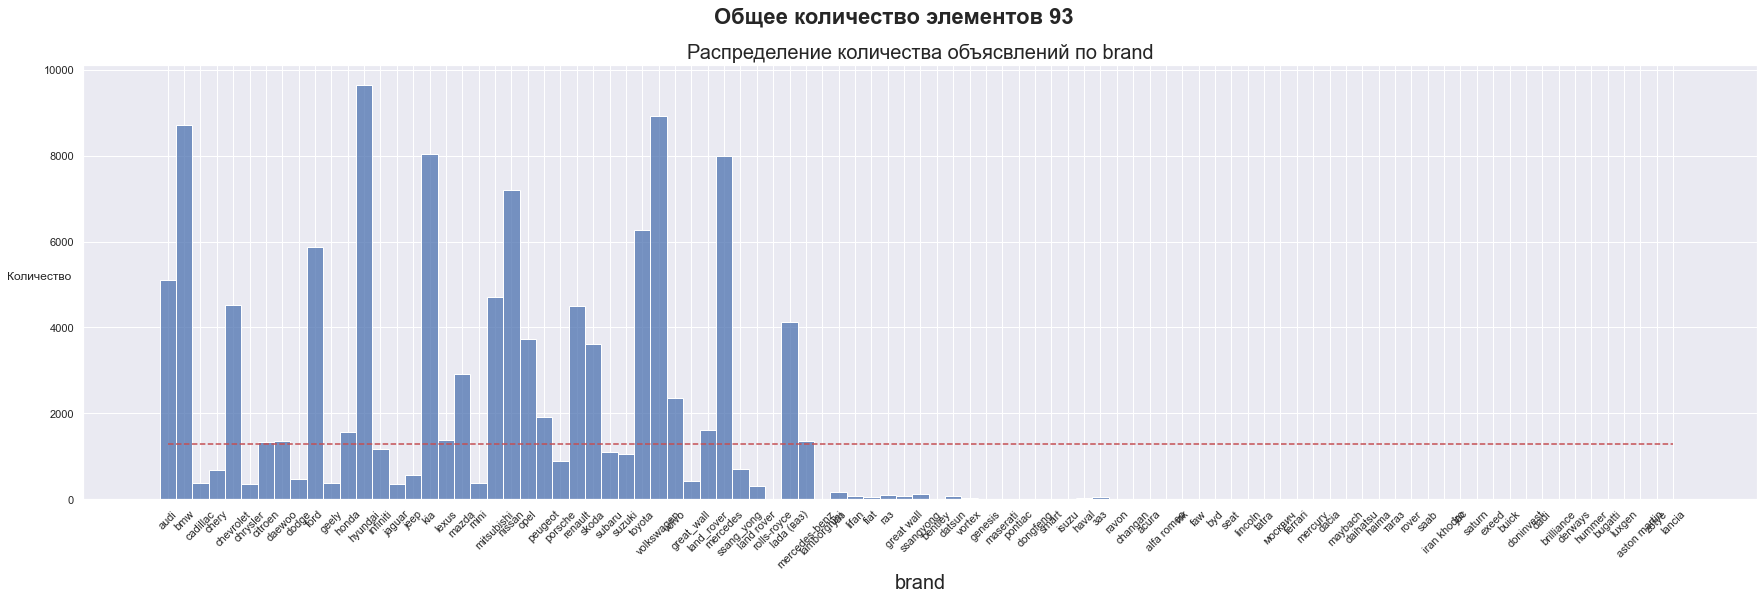

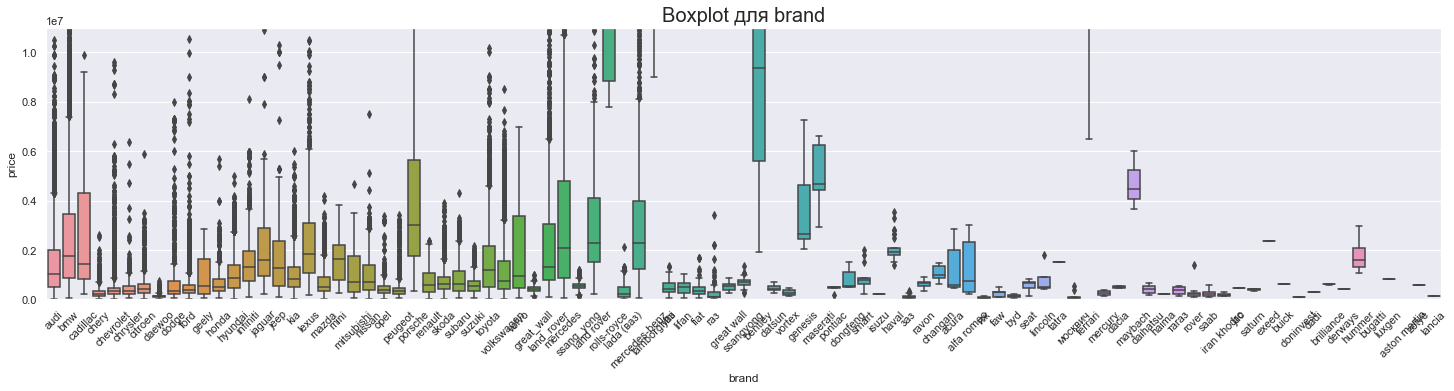

In [634]:
analiz_catigarial_feature(data, 'brand', 1)

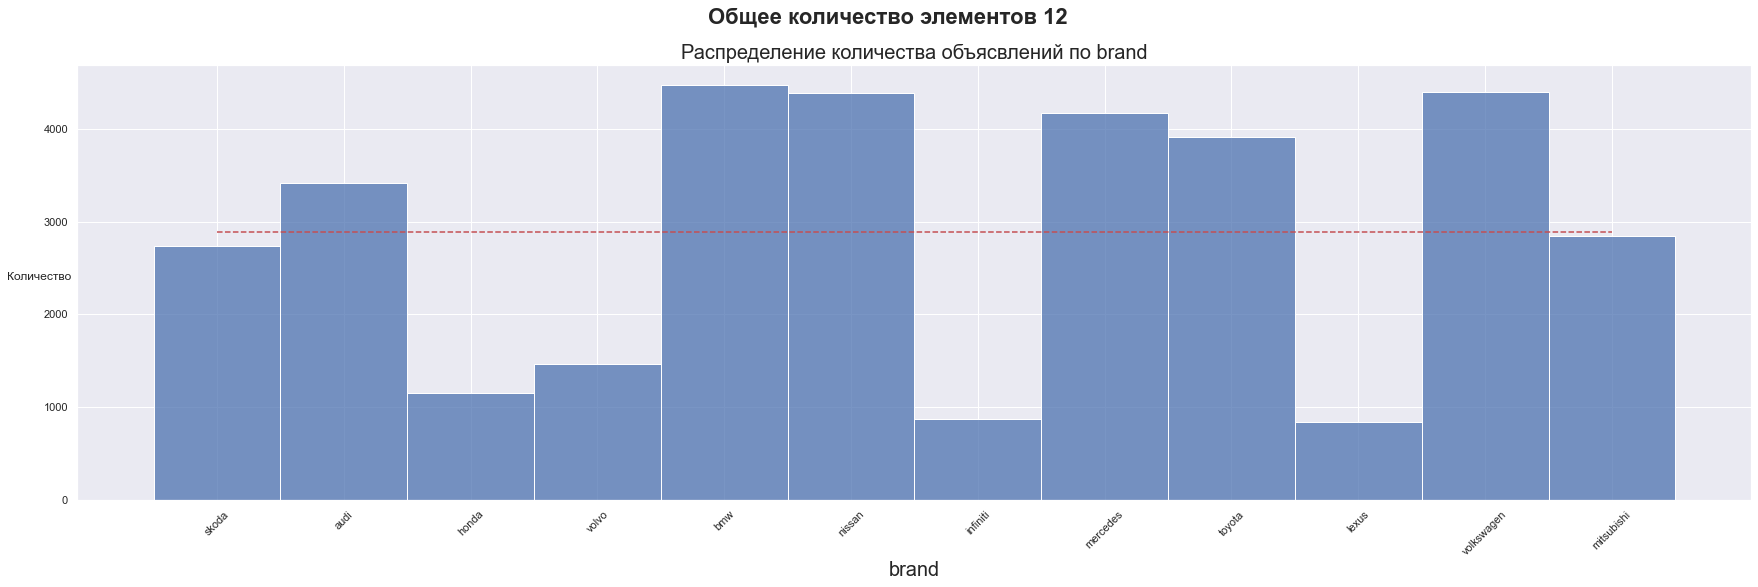

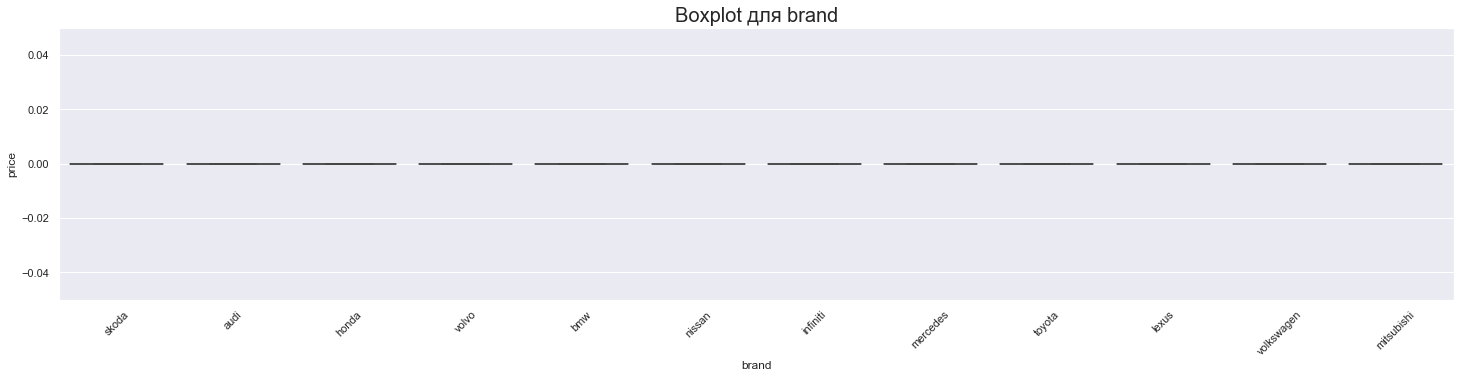

In [635]:
analiz_catigarial_feature(data, 'brand', 0)

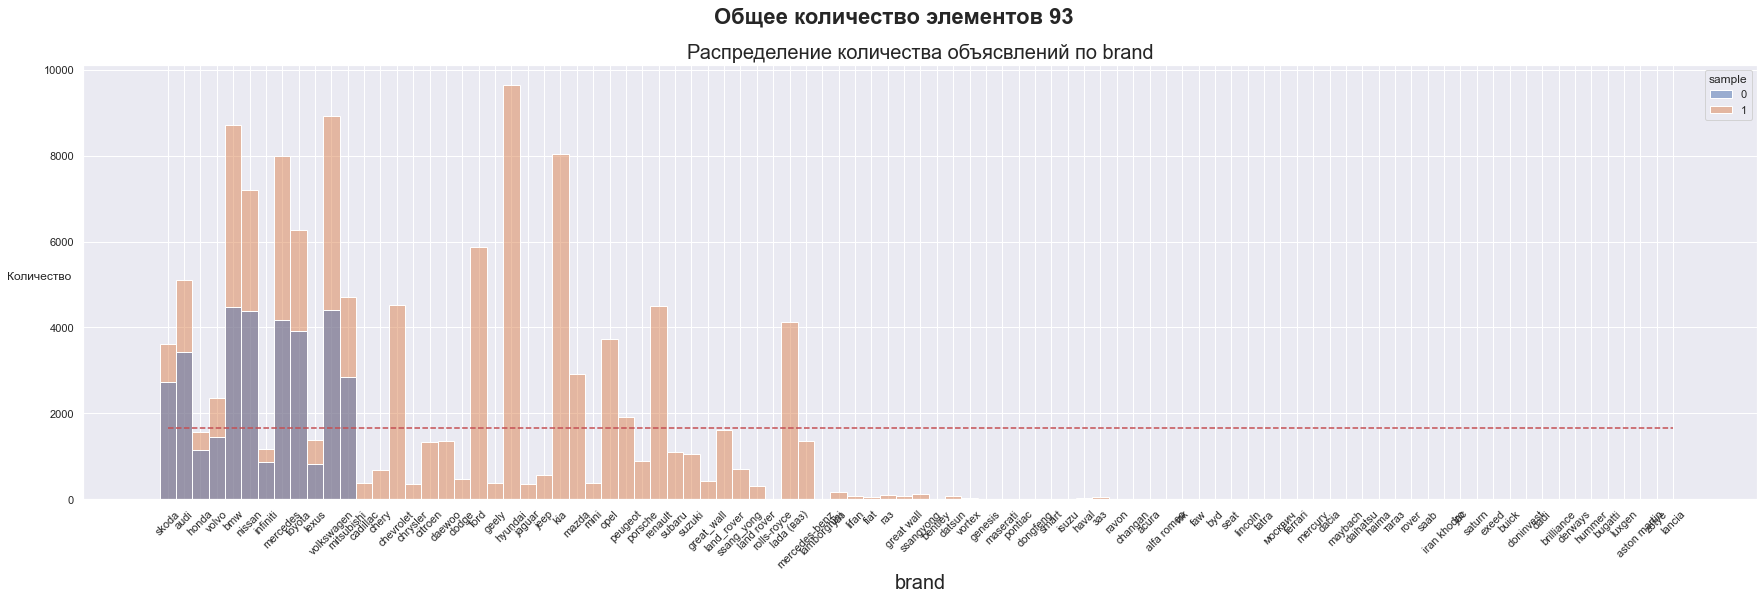

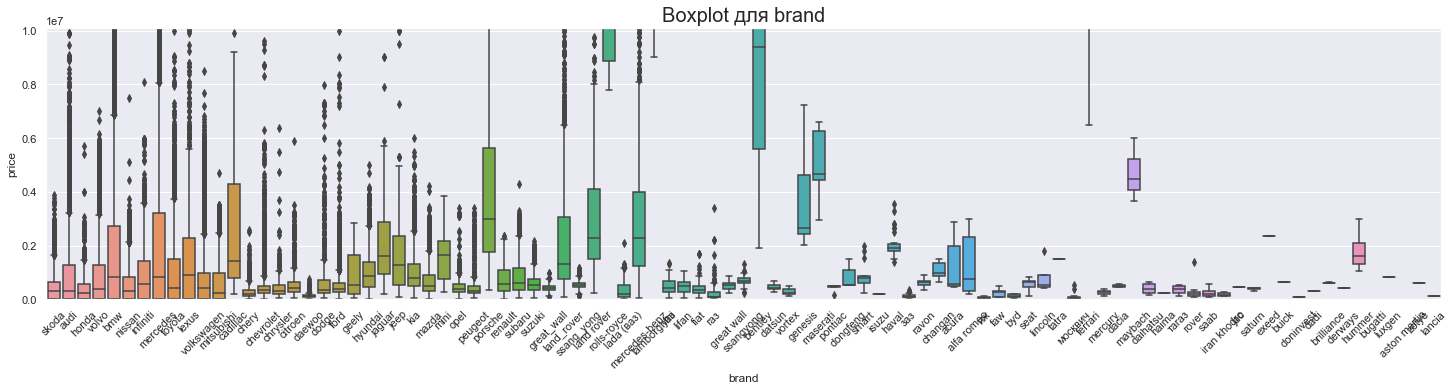

In [636]:
analiz_catigarial_feature(data, 'brand', 2)

**Вывод**: пропусков в признае нет, признак brand распределен неравномерно. В test представдены всего 12 брендов.
Представим этот признак как категориальный 

# bodyType 
- тип кузова 

In [637]:
getEmptyValue(data, 'bodyType')

Количество уникальных значений для train 25
Количество пропусков значений   для train 0
Количество уникальных значений для test 24
Количество пропусков значений   для test 0


In [638]:
definePopularColumn(data, 'bodyType', 1)

{'внедорожник 5 дв.': 43043,
 'седан': 42417,
 'хэтчбек 5 дв.': 12939,
 'универсал 5 дв.': 4799,
 'лифтбек': 4466,
 'минивэн': 2821,
 'компактвэн': 2484,
 'хэтчбек 3 дв.': 2242,
 'купе': 1779,
 'пикап двойная кабина': 697}

In [639]:
definePopularColumn(data, 'bodyType', 0)

{'седан': 13147,
 'внедорожник 5 дв.': 12228,
 'лифтбек': 2232,
 'хэтчбек 5 дв.': 2124,
 'универсал 5 дв.': 1276,
 'минивэн': 995,
 'купе': 824,
 'компактвэн': 489,
 'хэтчбек 3 дв.': 485,
 'пикап двойная кабина': 280}

In [640]:
defineDiffPopularCol(data, 'bodyType')

Значений которых нет в test Но есть в train
{'хэтчбек 4 дв.', 'спидстер'}
Значений которых нет в train Но есть в test
{'купе-хардтоп'}


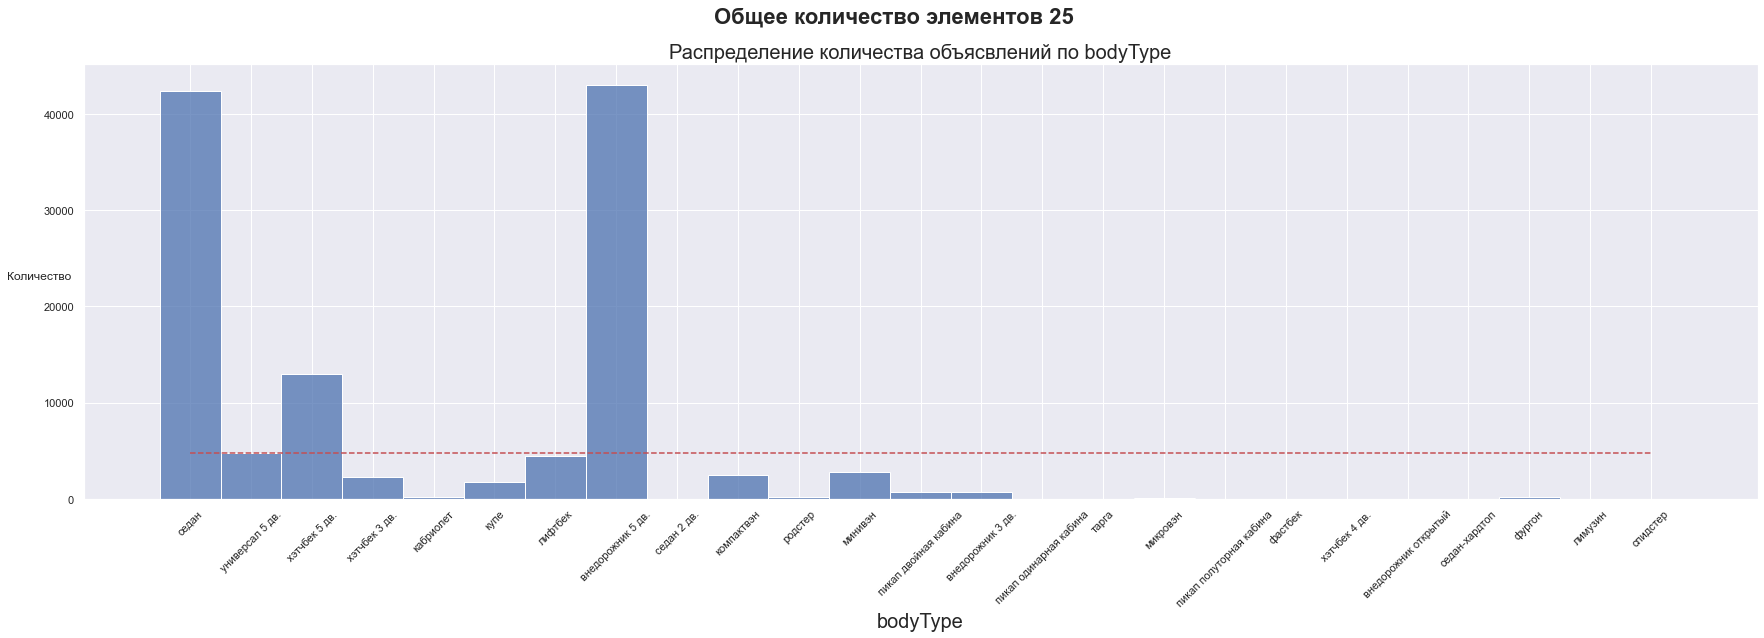

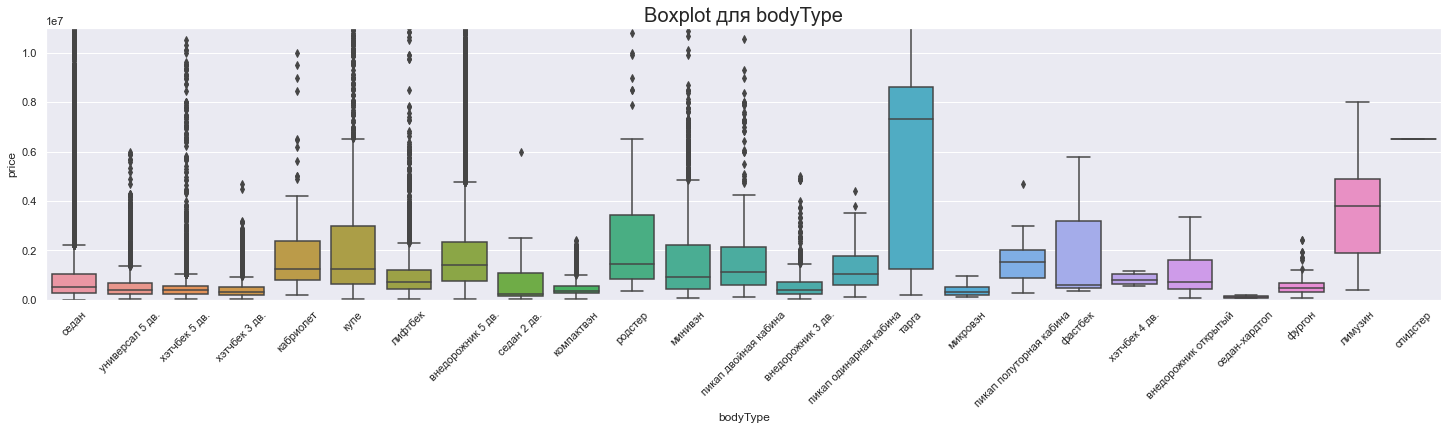

In [641]:
analiz_catigarial_feature(data, 'bodyType', 1)

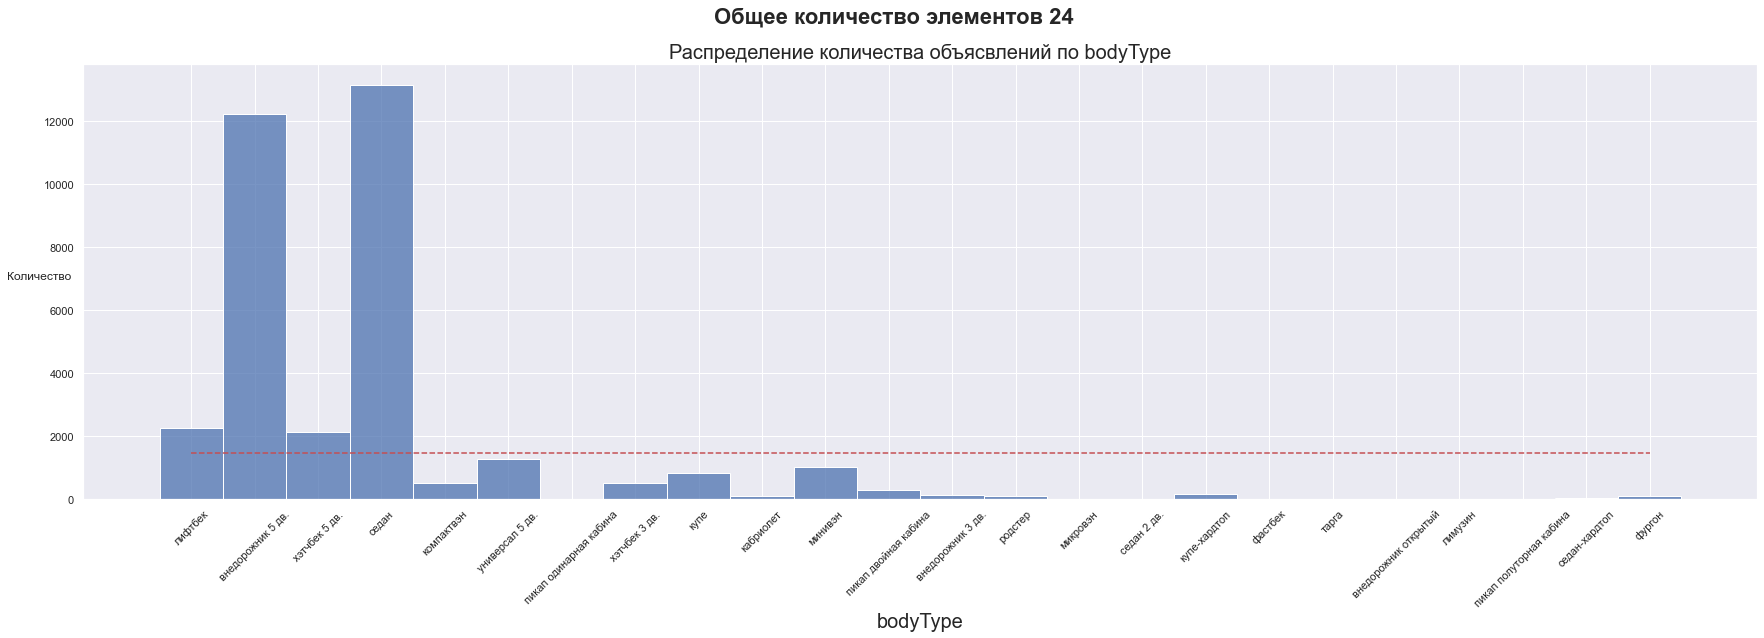

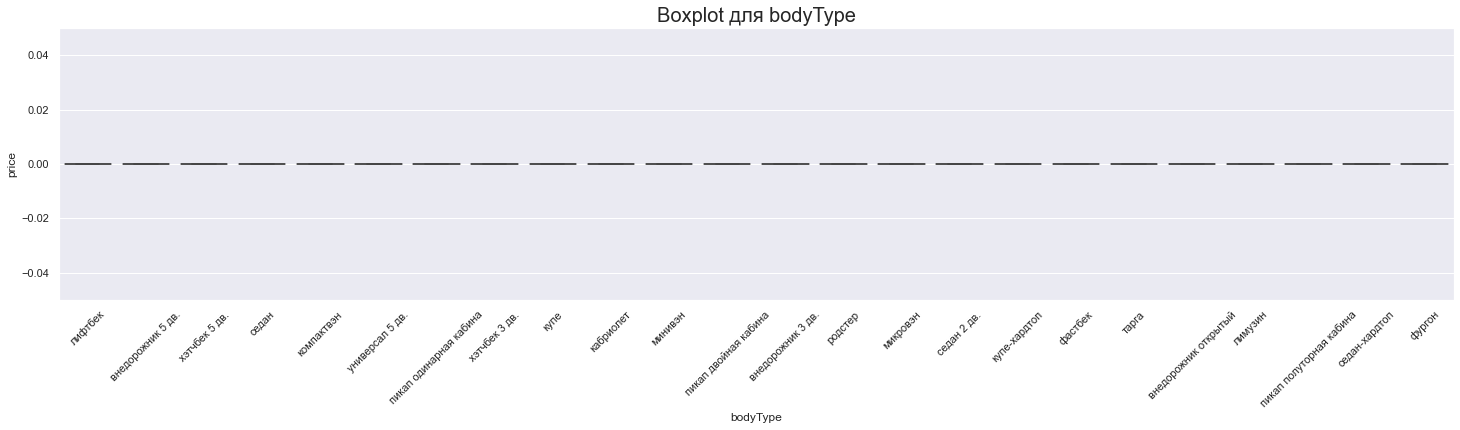

In [642]:
analiz_catigarial_feature(data, 'bodyType', 0)

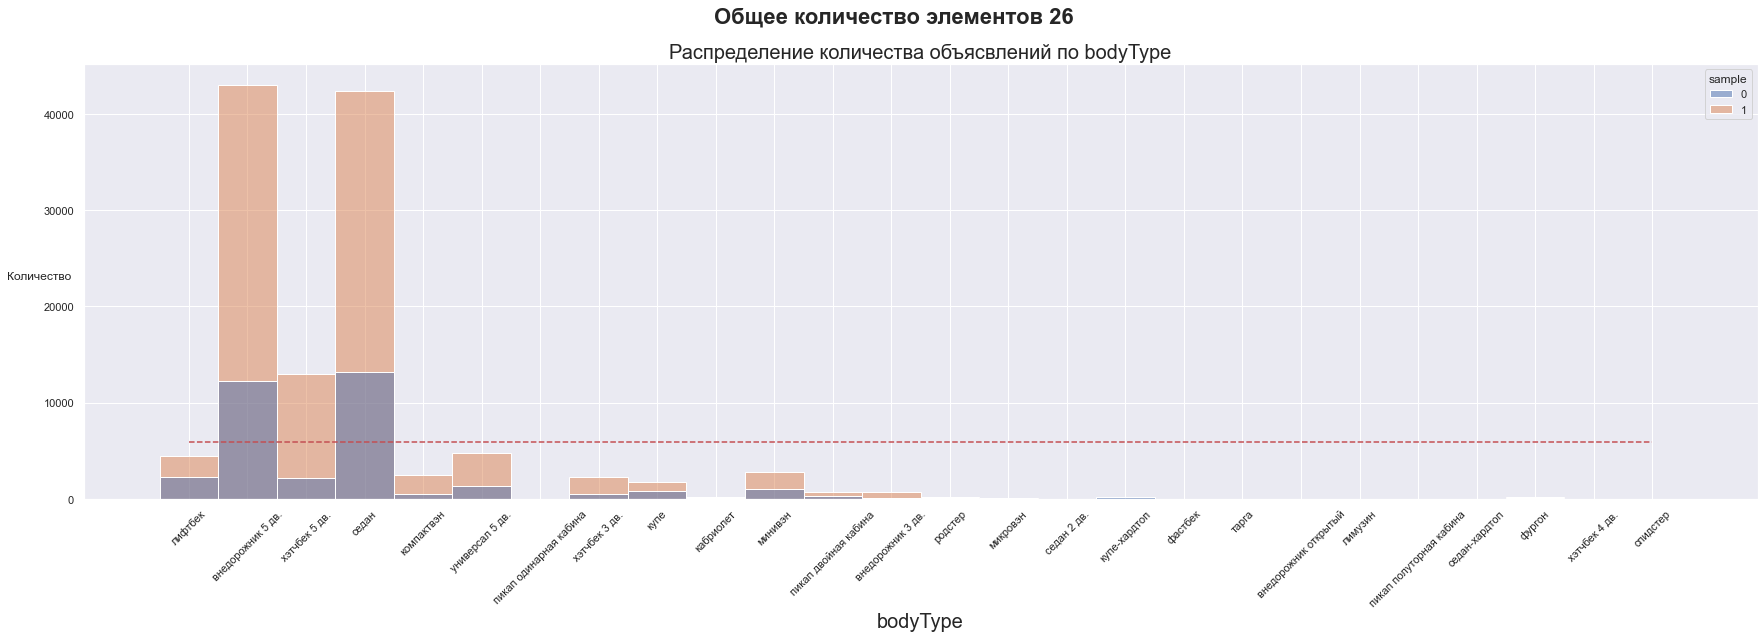

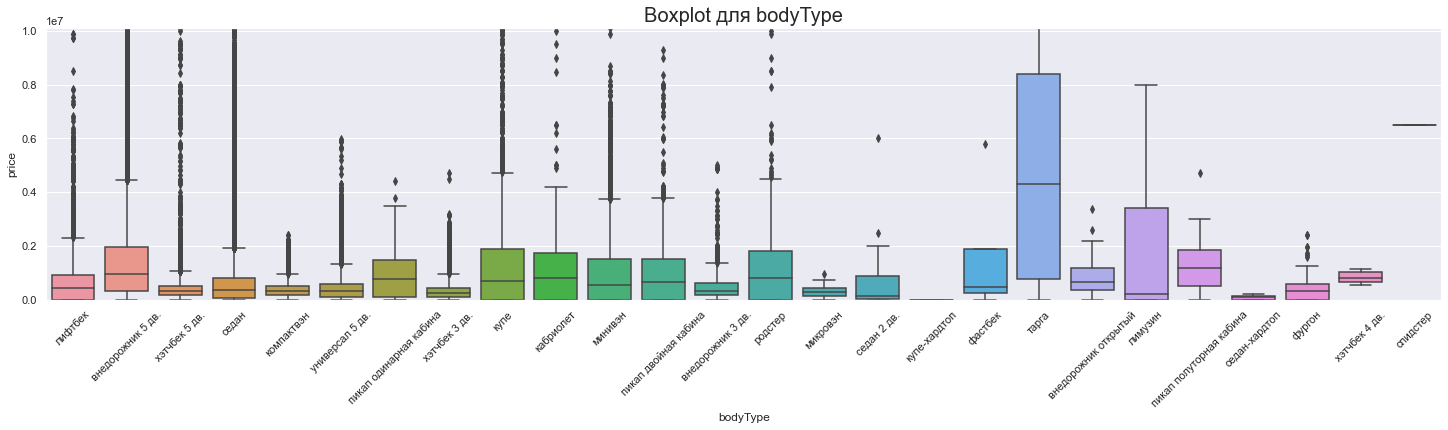

In [643]:
analiz_catigarial_feature(data, 'bodyType', 2)

**Вывод** - в тренировочной выборке представлены не все типы кузовов. Это связано с неполной выборкой и также присутсвует неравноменость выборки. Отнесем это признак к категориальному

# color

  цвет машины.


In [644]:
getEmptyValue(data, 'color')

Количество уникальных значений для train 16
Количество пропусков значений   для train 0
Количество уникальных значений для test 16
Количество пропусков значений   для test 0


Часто встречающие цвета!

In [645]:
definePopularColumn(data, 'color', 1)

{'чёрный': 31571,
 'белый': 22001,
 'серый': 15275,
 'серебристый': 14978,
 'синий': 11529,
 'красный': 6203,
 'коричневый': 5158,
 'зелёный': 3553,
 'бежевый': 2588,
 'голубой': 1762}

In [646]:
definePopularColumn(data, 'color', 0)

{'чёрный': 11010,
 'белый': 6133,
 'серебристый': 4113,
 'серый': 3984,
 'синий': 3289,
 'красный': 1531,
 'коричневый': 1501,
 'зелёный': 952,
 'бежевый': 639,
 'голубой': 457}

In [647]:
defineDiffPopularCol(data, 'color')

Значений которых нет в test Но есть в train
set()
Значений которых нет в train Но есть в test
set()


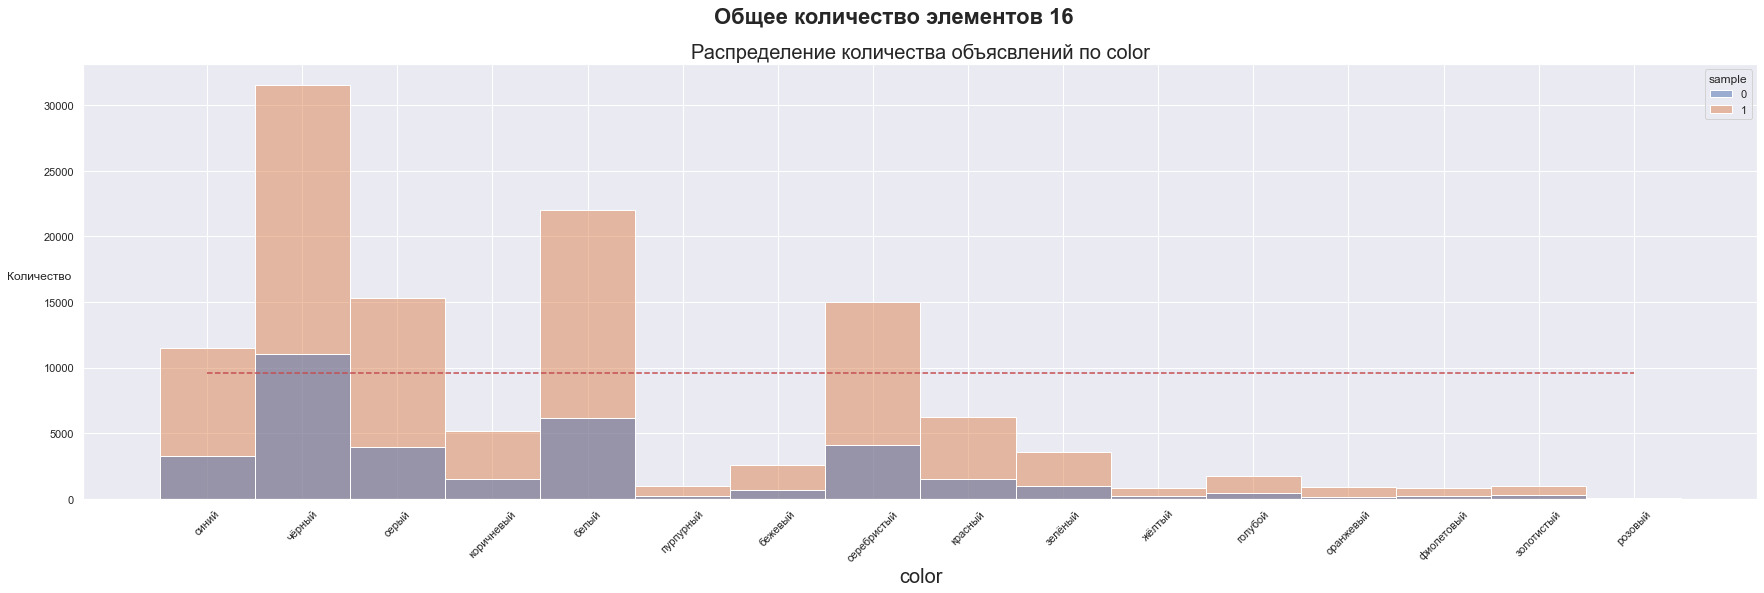

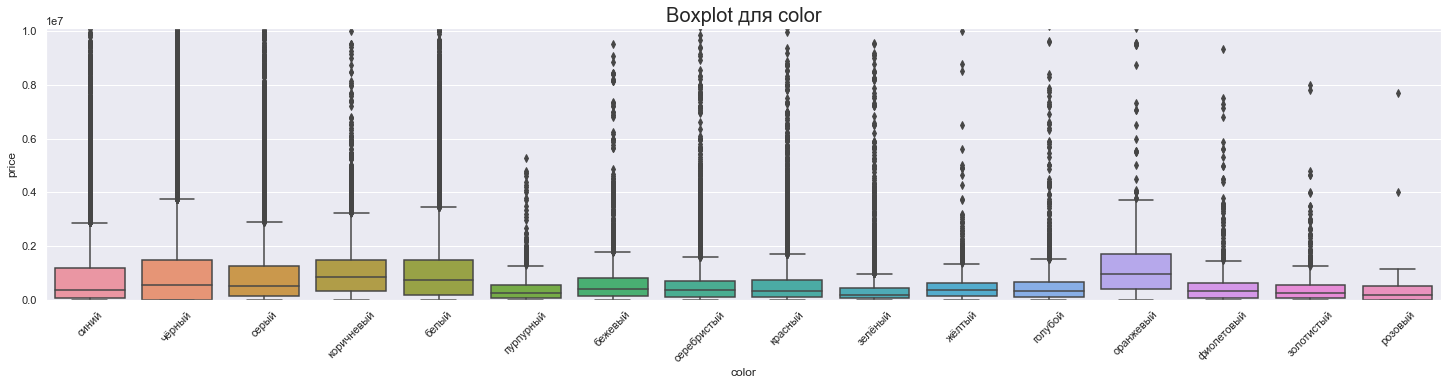

In [648]:
analiz_catigarial_feature(data, 'color', 2)

**Вывод** в train присутствут все цвета , которые есть в test. Представим как категориальный признак

# fuelType
тип топлива

In [649]:
getEmptyValue(data, 'fuelType')

Количество уникальных значений для train 6
Количество пропусков значений   для train 0
Количество уникальных значений для test 5
Количество пропусков значений   для test 0


In [650]:
definePopularColumn(data, 'fuelType', 1)

{'бензин': 101003,
 'дизель': 17387,
 'гибрид': 393,
 'бензин. газобаллонное оборудование': 271,
 'газ': 14,
 'электро': 2}

In [651]:
definePopularColumn(data, 'fuelType', 0)

{'бензин': 28601, 'дизель': 5800, 'гибрид': 223, 'электро': 55, 'газ': 7}

In [652]:
defineDiffPopularCol(data, 'fuelType')

Значений которых нет в test Но есть в train
{'бензин. газобаллонное оборудование'}
Значений которых нет в train Но есть в test
set()


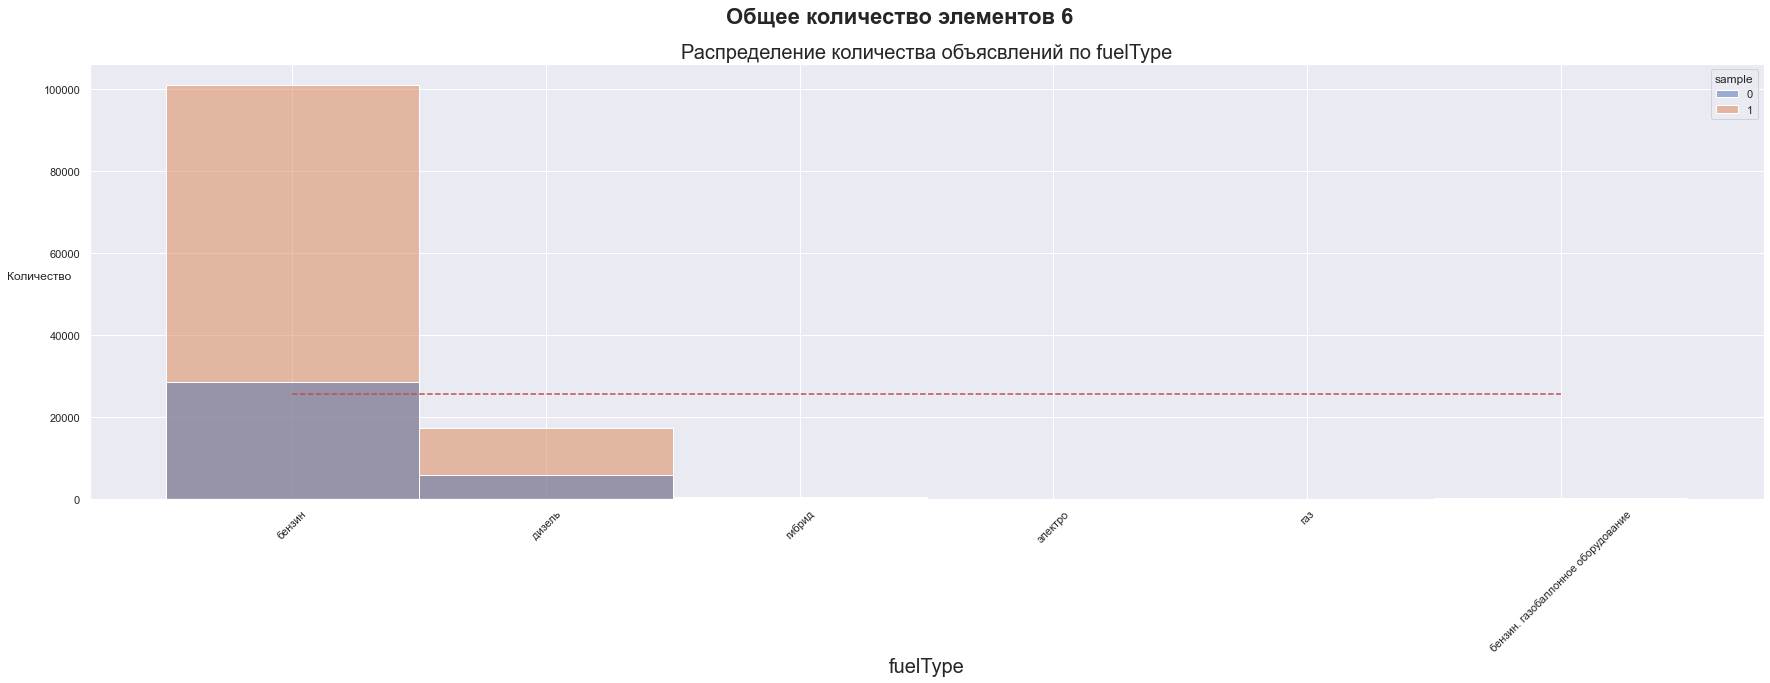

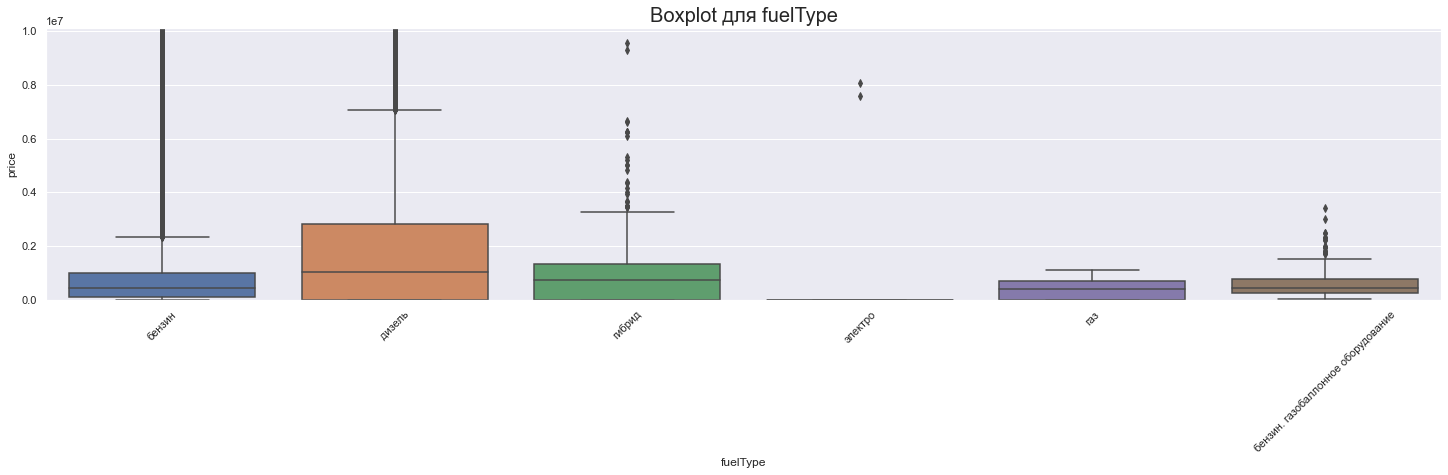

In [653]:
analiz_catigarial_feature(data, 'fuelType', 2)

**Вывод** - по рисункам видно, что машины на  бензине дешевле чем на дизиле. Пример как категориальный признак

# vehicleTransmission
- тип передачи

In [654]:
getEmptyValue(data, 'vehicleTransmission')

Количество уникальных значений для train 4
Количество пропусков значений   для train 0
Количество уникальных значений для test 4
Количество пропусков значений   для test 0


In [655]:
definePopularColumn(data, 'vehicleTransmission', 0)

{'автомат': 19596, 'механика': 7209, 'вариатор': 3999, 'робот': 3882}

In [656]:
defineDiffPopularCol(data, 'vehicleTransmission')

Значений которых нет в test Но есть в train
set()
Значений которых нет в train Но есть в test
set()


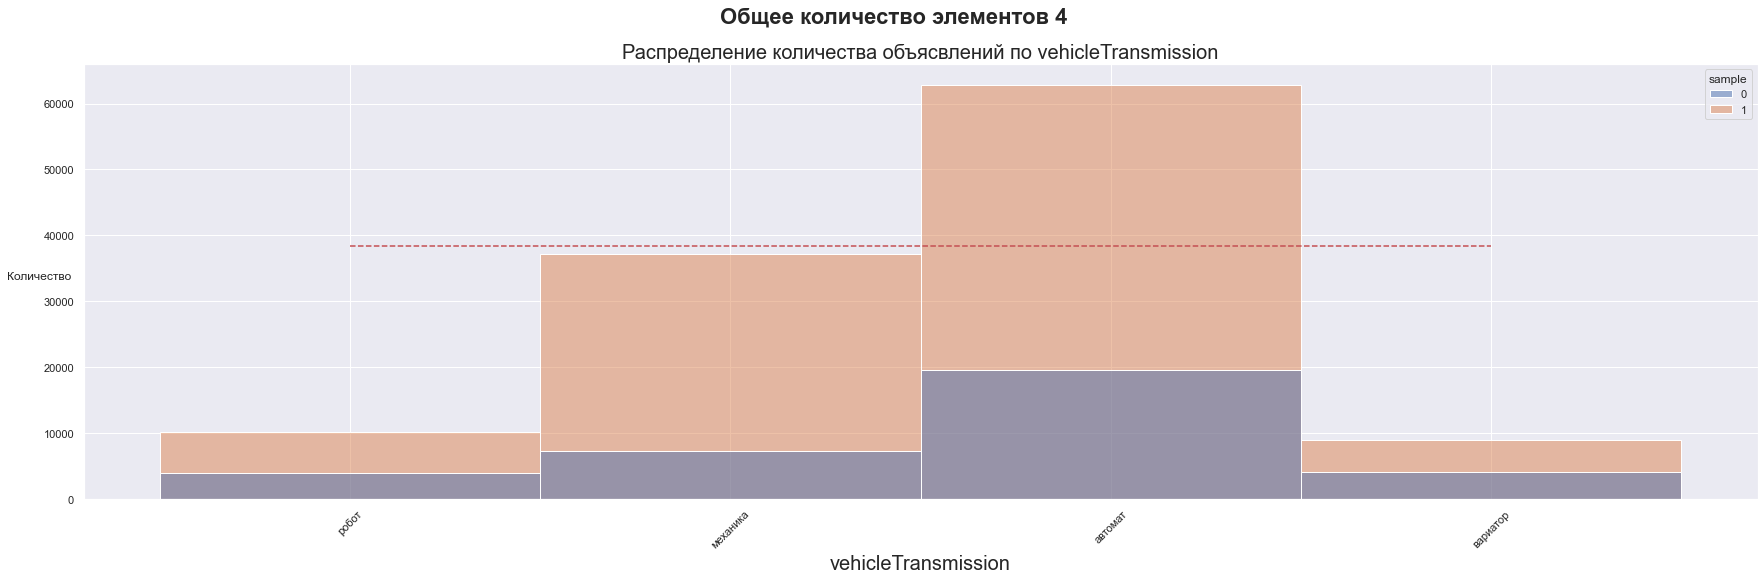

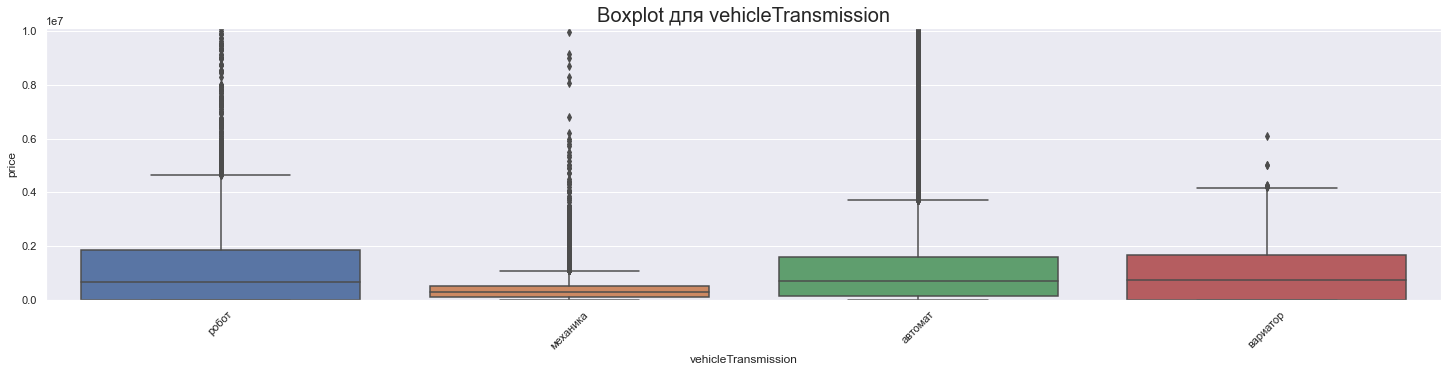

In [657]:
analiz_catigarial_feature(data, 'vehicleTransmission', 2)

**Вывод** - в целом механика дешевле всех. разные признаки имеют разные доверительные интервалы по ценам - что позволит отличать их между собой. Примем как категориальный тип

# drivertrain 
привод

In [658]:
getEmptyValue(data, 'drivertrain')

Количество уникальных значений для train 3
Количество пропусков значений   для train 0
Количество уникальных значений для test 3
Количество пропусков значений   для test 0


In [659]:
definePopularColumn(data, 'drivertrain', 1)

{'передний': 65387, 'полный': 44826, 'задний': 8857}

In [660]:
defineDiffPopularCol(data, 'drivertrain')

Значений которых нет в test Но есть в train
set()
Значений которых нет в train Но есть в test
set()


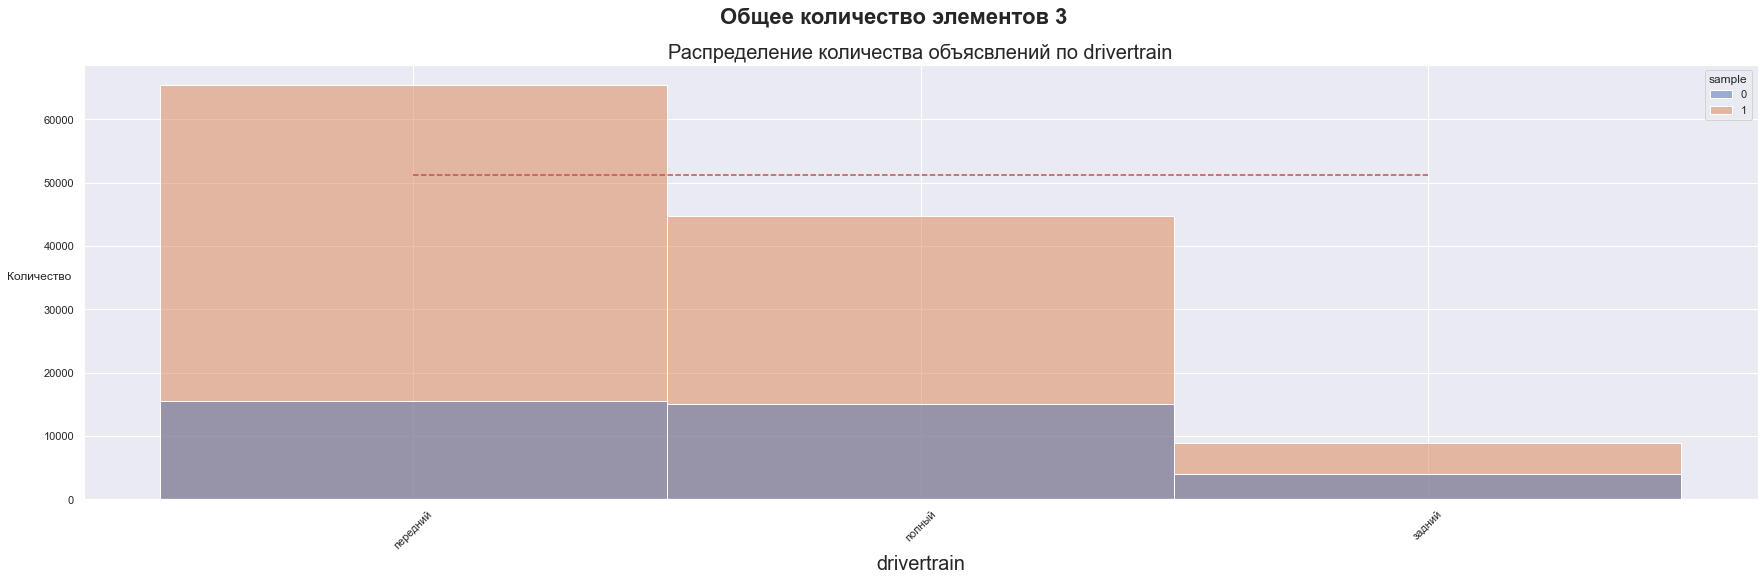

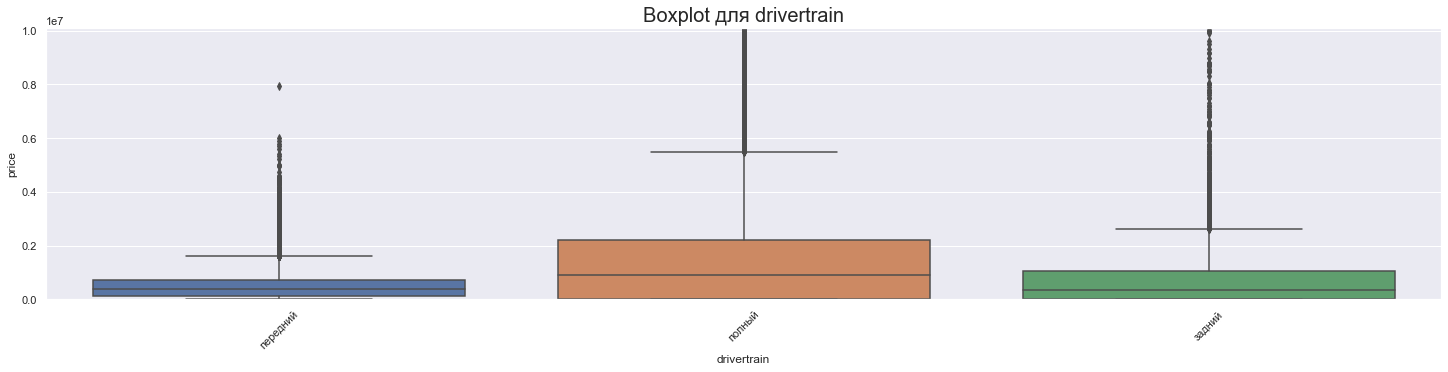

In [661]:
analiz_catigarial_feature(data, 'drivertrain', 2)

**Вывод** - в целом передний привод дешевле всех, полный привод заметно дороже. Примем его как категориальный признак

# vendor
производитель

In [662]:
getEmptyValue(data, 'vendor')

Количество уникальных значений для train 6
Количество пропусков значений   для train 0
Количество уникальных значений для test 2
Количество пропусков значений   для test 0


In [663]:
definePopularColumn(data, 'vendor', 1)

{'EUROPEAN': 53290,
 'JAPANESE': 27484,
 'ASIAN': 21627,
 'AMERICAN': 12173,
 'RUSSIAN': 4492,
 'ARABIC': 4}

In [664]:
defineDiffPopularCol(data, 'vendor')

Значений которых нет в test Но есть в train
{'ASIAN', 'AMERICAN', 'RUSSIAN', 'ARABIC'}
Значений которых нет в train Но есть в test
set()


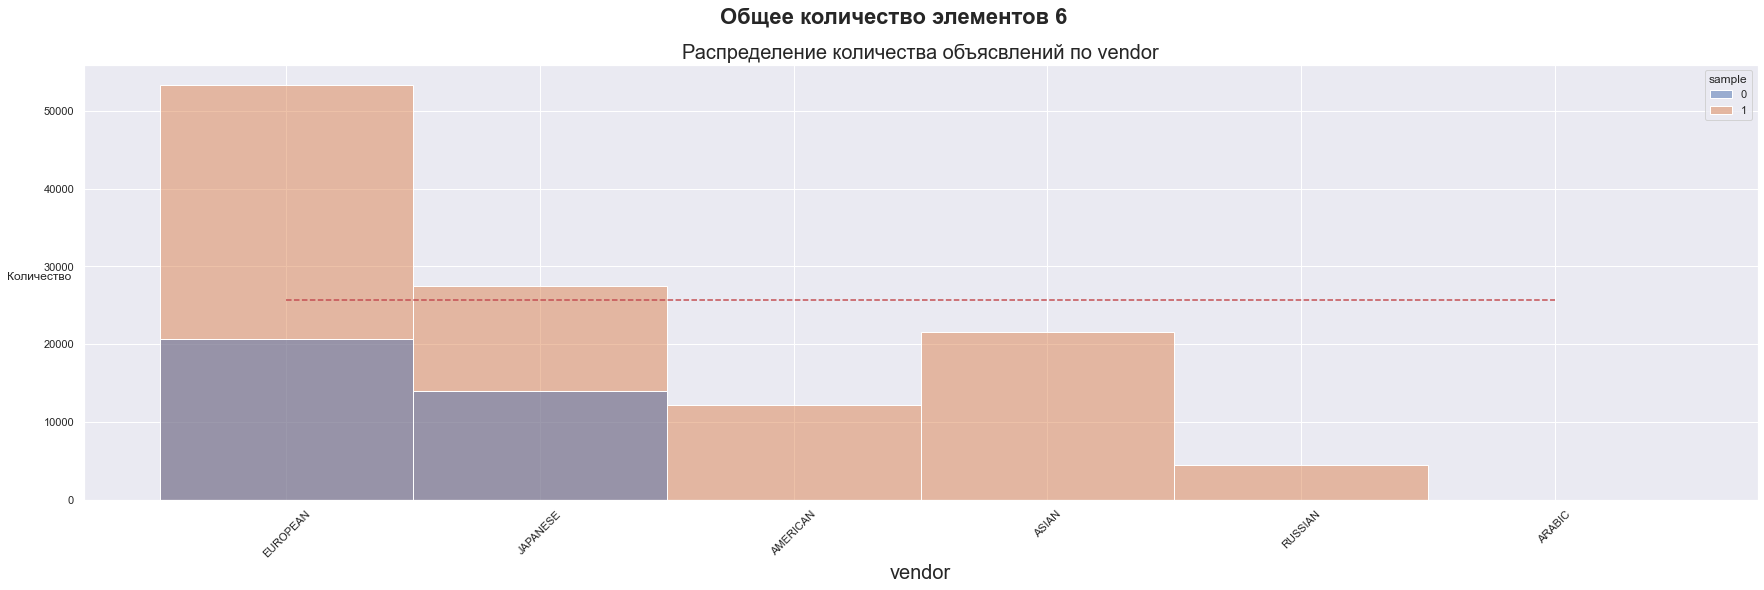

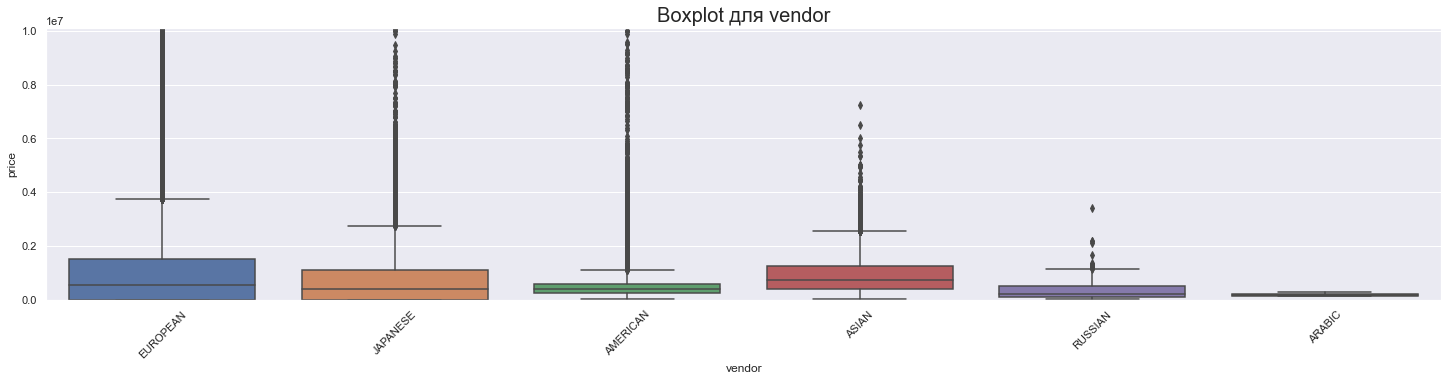

In [665]:
analiz_catigarial_feature(data, 'vendor', 2)

**Вывод** - в целом график показывает что реально русские машины самые дешевые! Примем его за категориальный признак

# ownersCount 
количество владельцев



In [666]:
getEmptyValue(data, 'ownersCount')

Количество уникальных значений для train 4
Количество пропусков значений   для train 0
Количество уникальных значений для test 3
Количество пропусков значений   для test 0


In [667]:
definePopularColumn(data, 'ownersCount', 1)

{'three more': 46834, 'one': 27622, 'two': 27336, 'non': 17278}

In [668]:
defineDiffPopularCol(data, 'ownersCount')

Значений которых нет в test Но есть в train
{'non'}
Значений которых нет в train Но есть в test
set()


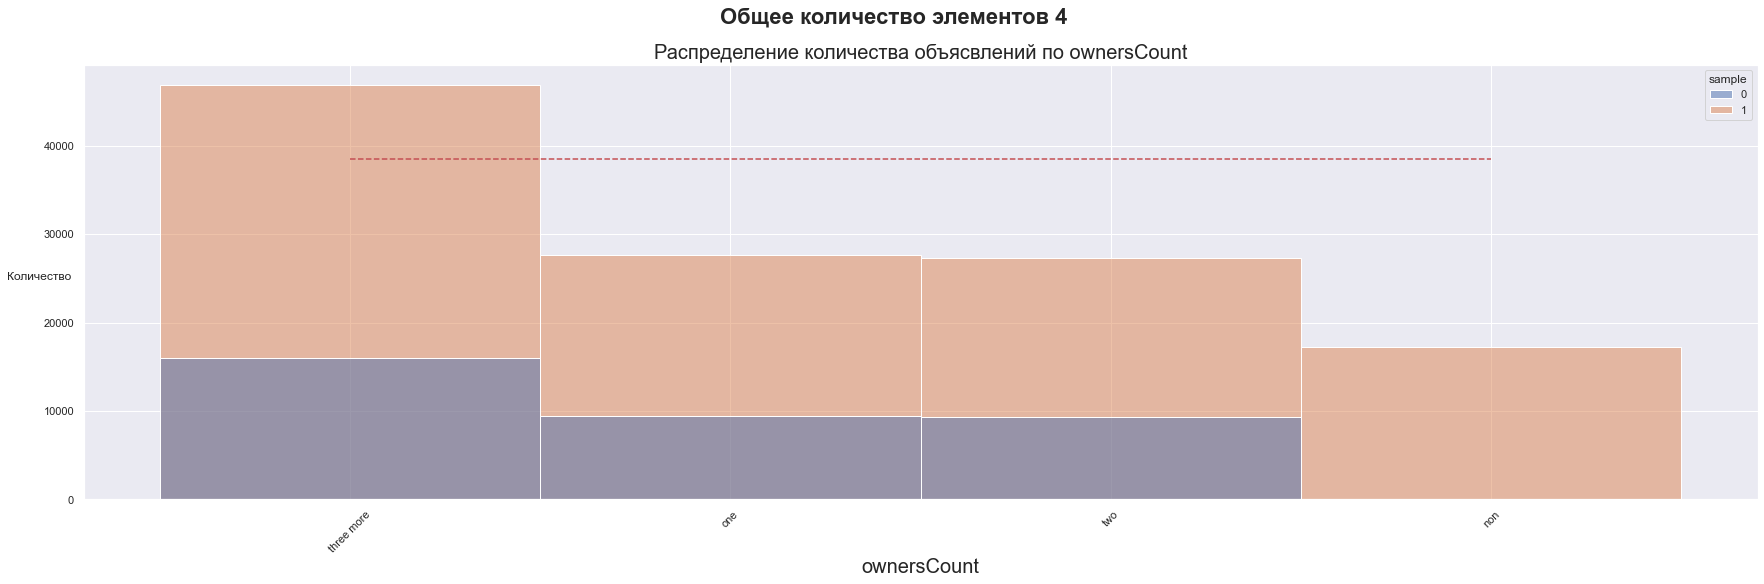

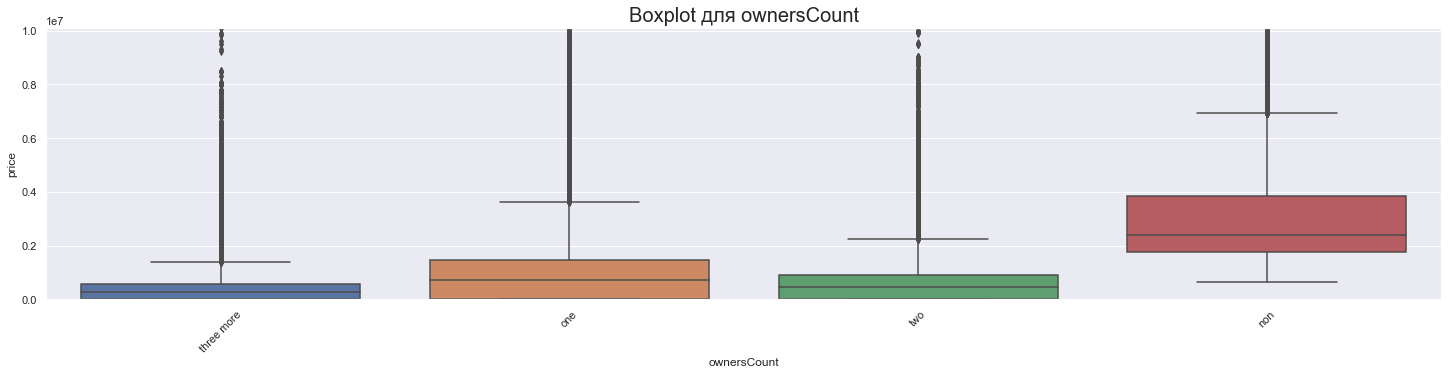

In [669]:
analiz_catigarial_feature(data, 'ownersCount', 2)

**Вывод** - с ростом количества владельцев цена уменьшается. Примем его за категориальный признак

# numberOfDoors 
    количество дверей

In [670]:
getEmptyValue(data, 'numberOfDoors')

Количество уникальных значений для train 5
Количество пропусков значений   для train 0
Количество уникальных значений для test 5
Количество пропусков значений   для test 0


In [671]:
definePopularColumn(data, 'numberOfDoors', 1)

{5: 69442, 4: 44398, 3: 2992, 2: 2237, 0: 1}

In [672]:
defineDiffPopularCol(data, 'numberOfDoors')

Значений которых нет в test Но есть в train
set()
Значений которых нет в train Но есть в test
set()


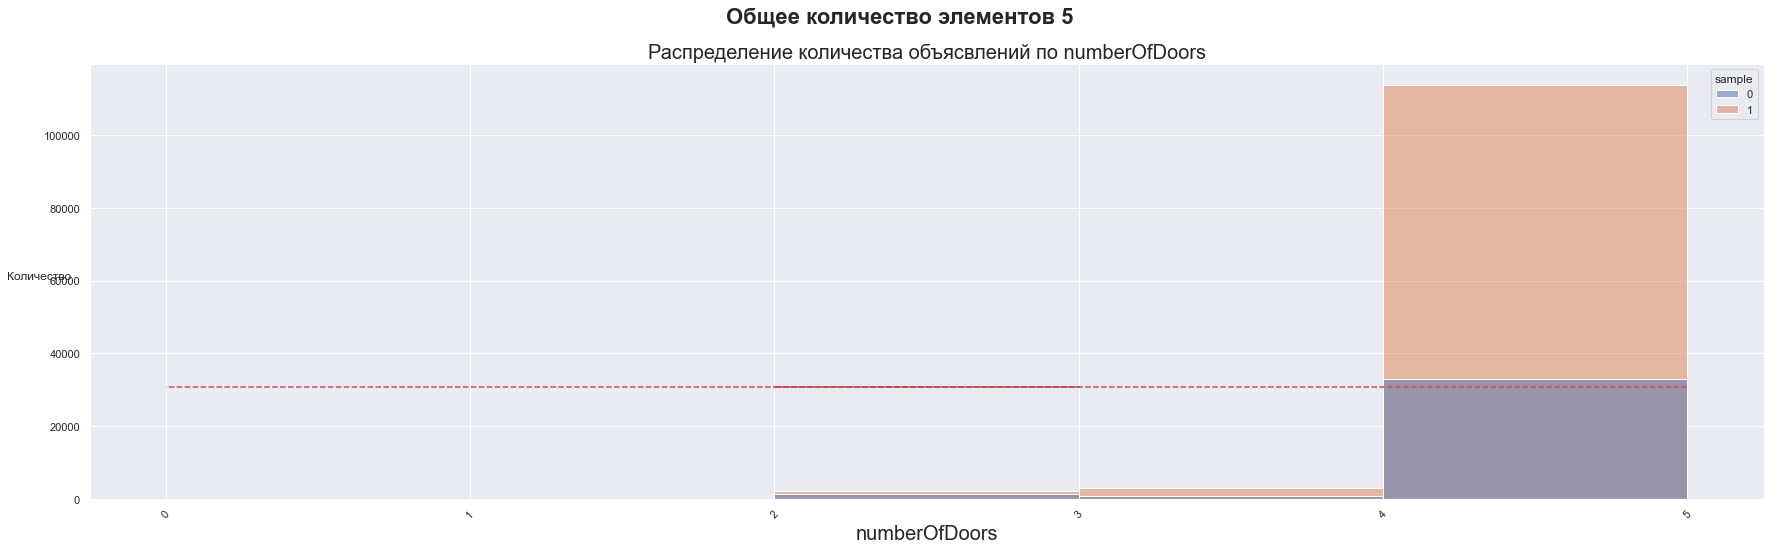

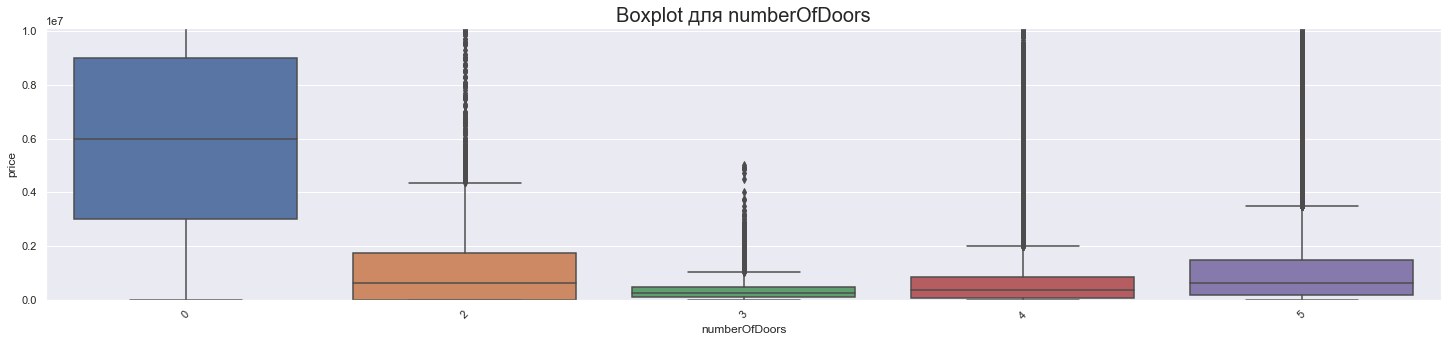

In [673]:
analiz_catigarial_feature(data, 'numberOfDoors', 2)

In [674]:
definePopularColumn(data, 'numberOfDoors', 1)

{5: 69442, 4: 44398, 3: 2992, 2: 2237, 0: 1}

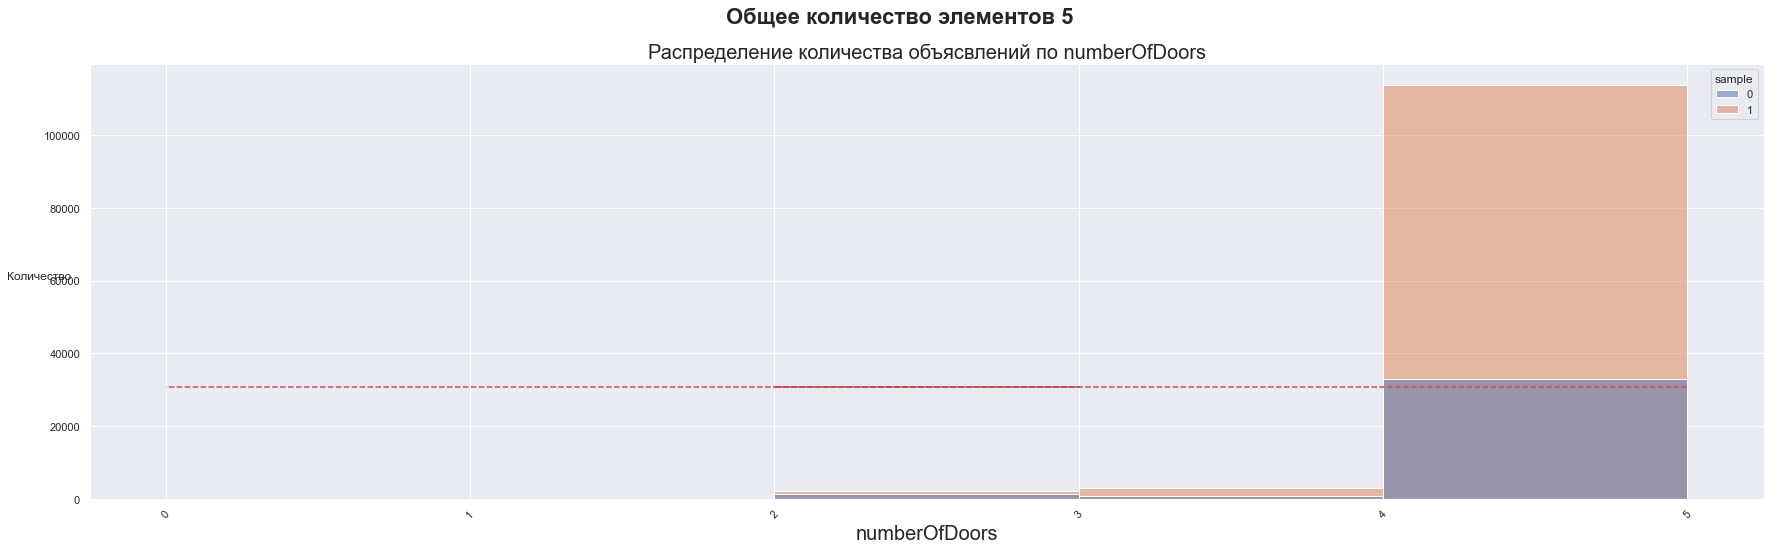

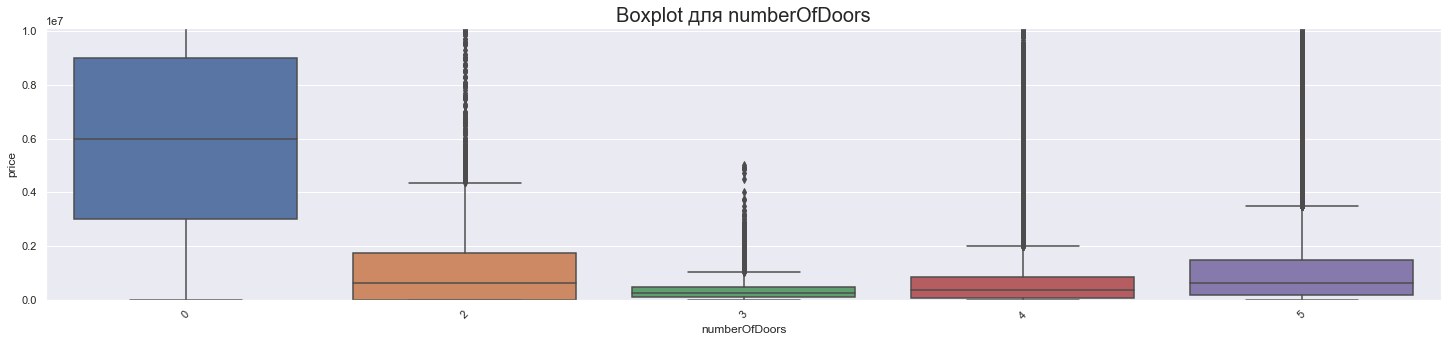

In [675]:
analiz_catigarial_feature(data, 'numberOfDoors', 2)


**Вывод** - удалим из признака значения 0 как ошибочное. примем данное значение как категориальное! 

# model  - модель

In [676]:
getEmptyValue(data, 'model')

Количество уникальных значений для train 1080
Количество пропусков значений   для train 0
Количество уникальных значений для test 544
Количество пропусков значений   для test 0


In [677]:
print(definePopularColumn(data, 'model', 1))

{'0           range_rover_sport                          rx                       ghost                   passat_cc                        2107                 ...                range_rover_sport                   nexia                   fabia    gle_klasse_coupe_amg                 solarisname: car_url, length: 30612, dtype: object': 30213, 'focus': 2457, 'solaris': 1763, '5er': 1668, 'astra': 1543, 'octavia': 1492, 'rio': 1463, 'e_klasse': 1426, '3er': 1414, 'passat': 1394}


In [678]:
defineDiffPopularCol(data, 'model')

Значений которых нет в test Но есть в train
{'actyon', 'chairman', '408', 'sebring', 'mokka', 'range_rover', 'patriot', '607', 'bx', 'c1', 'cobalt', 'mx_6', '4007', 'caravan', 'mk_cross', '180sx', 'ats', 'range_rover_sport', 'hoverh5', 'joice', 'tahoe', '106', 'c5', 'ranger', 'xj', '308', 'corvette', 'xfr', 'bonus', 'soul', 'agila', 'libety_na', 'retona', '911_gt3', 'vectra_opc', 'c4_aircross', 'cross_eastar', 'r1', 'justy', 'optima', 'equinox', 'equus', 'kaptur', 'dokker', 'insignia', 'grand_vitara', 'cowry', 'w110', 'xt5', 'raider', 'spark', 'intrepid', 'i20', '206', 'pt_cruiser', 'jumpy', 'suburban', '407', 'b9_tribeca', 'primastar', 'sts', '19', 'windstorm', 'premacy', 'neon', 'tiggo_4', 'mistral', 'bls', 'tuscani', 'baleno', 'cx_7', 'kimo', '3008', 'combo', 'bronco', 'pride', 'svx', 'espace', 'venga', 'c3_aircross', 'commander', 'qq6', 'avantime', 'xjr', 'xantia', 'emgrand', '323', 'shuma', 'cx_5', 'solio', 'damas', 'focus_rs', 'n_one', 'monterey', 'kei', 'stratus', 'volt', 'conto

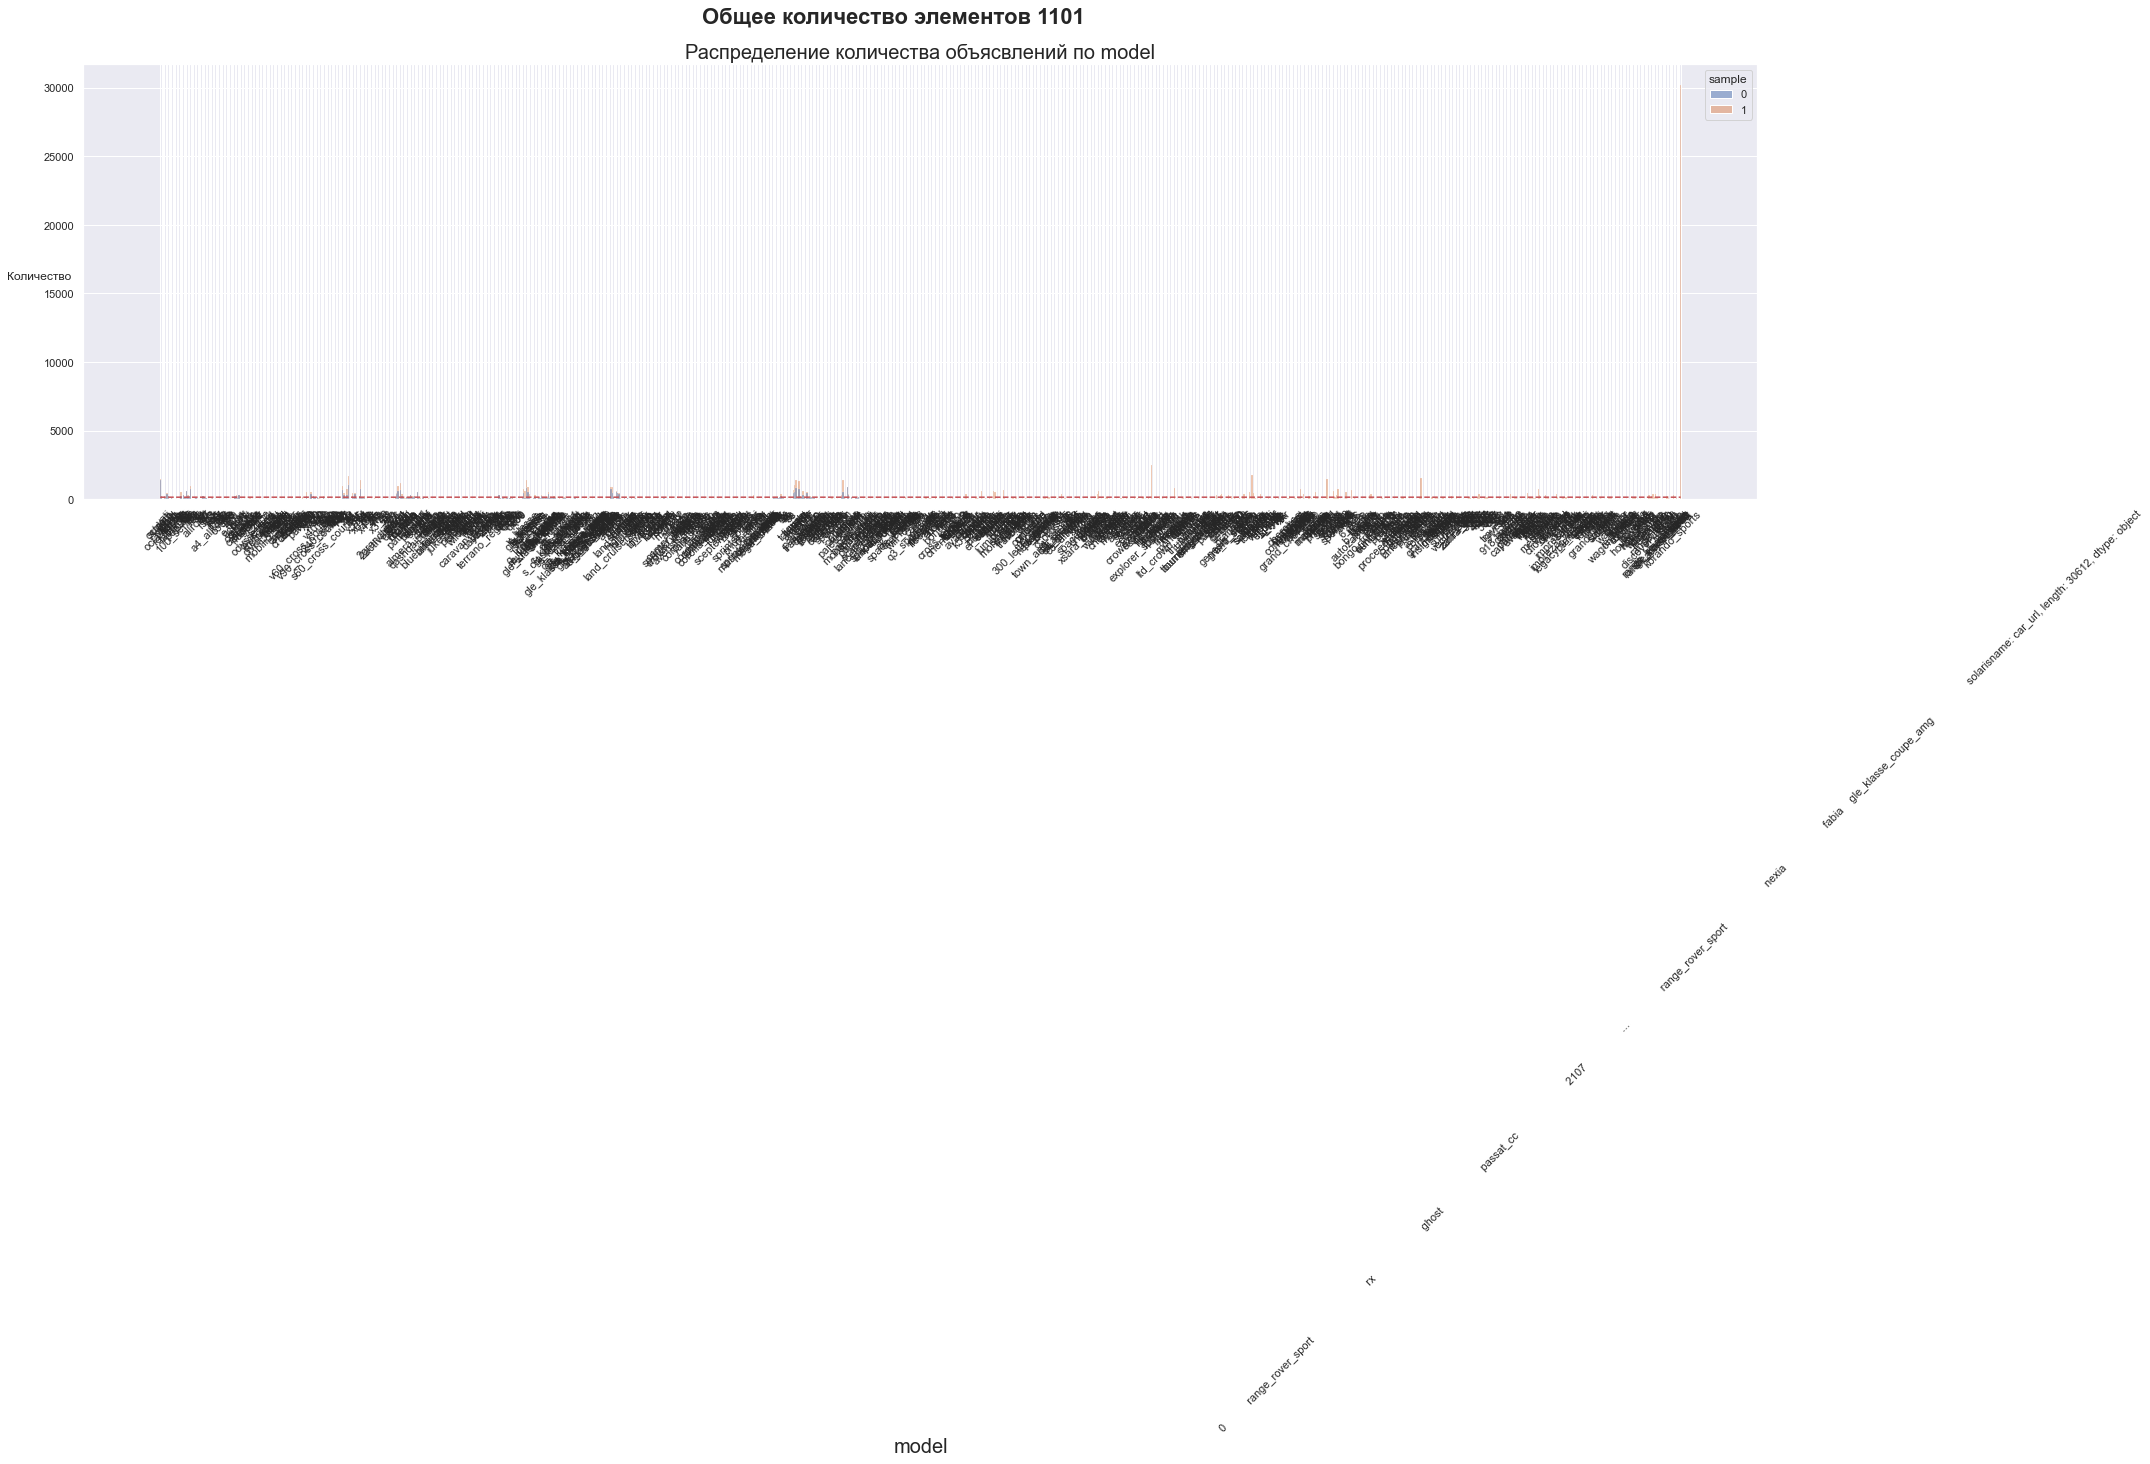

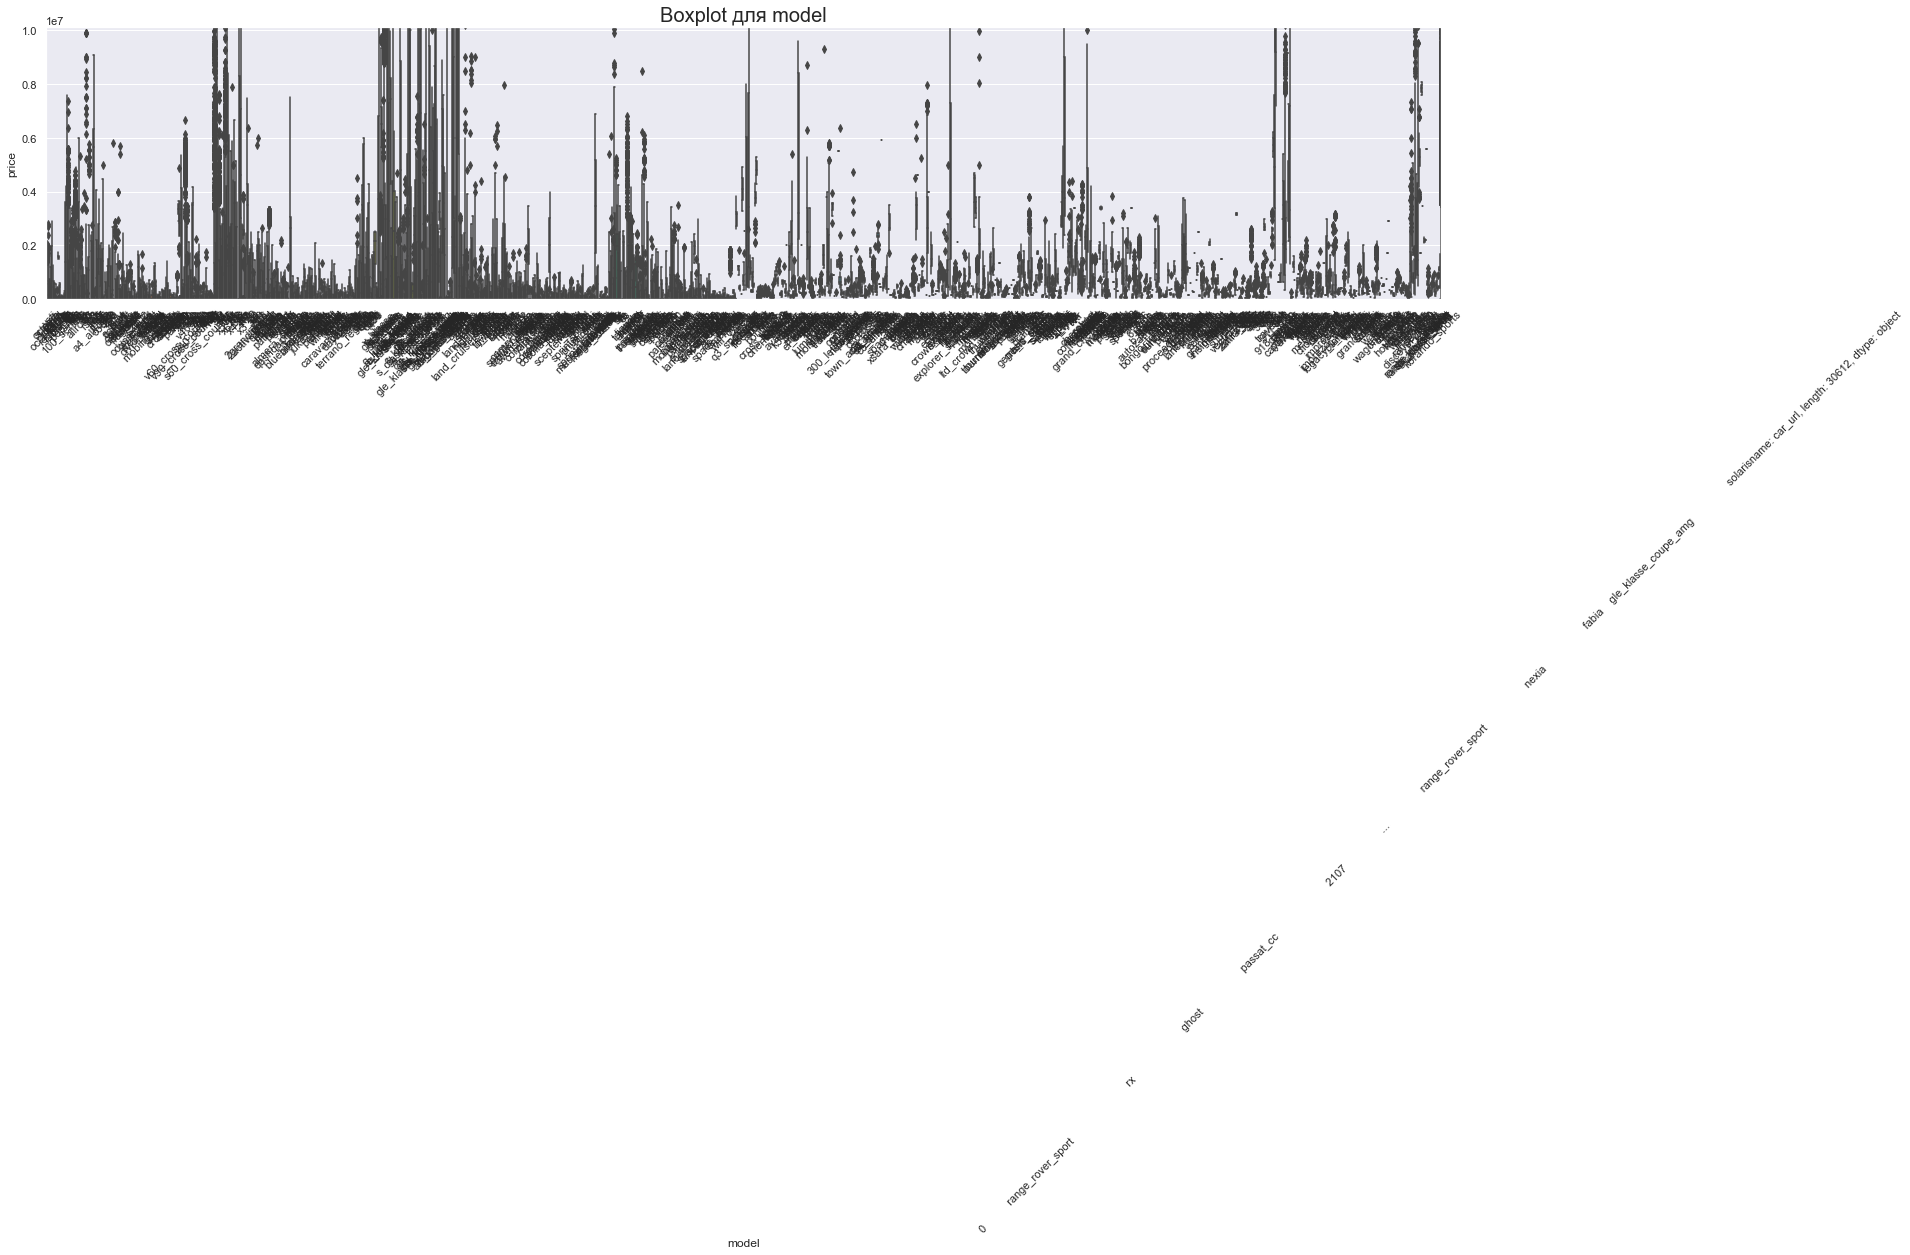

In [679]:
analiz_catigarial_feature(data, 'model', 2)

**вывод** - в датасете присутствует много моделей! Примем за категориальный признак

# Числовые признаки

## modelDate
дата модели авто

In [680]:
def analis_number_scatterplot(date, col):
    fig, axes = plt.subplots(figsize=(30, 8))

    sns.scatterplot(x=col, y="price", data=date)
    plt.xticks(rotation=45)
    plt.xlabel(col, fontsize=20)
    plt.title('распределенеи по годам - ' + col, fontsize=20)
    plt.show()

def analis_number_boxplot(data, col):
    fig, axes = plt.subplots(figsize=(30, 8))
    sns.boxplot(data[col])
    plt.xticks(rotation=45)
    plt.xlabel(col, fontsize=20)
    plt.title('boxplot - ' + col, fontsize=20)
    plt.show()

def analiz_number_feature(data, col, sample = 1):
    
    if sample == 0 or sample == 1:
        train = data.query('sample == ' + str(sample))
    else:
        train = data
    fig, axes = plt.subplots(figsize=(30, 8))

    sns.distplot(train[col])
    plt.xticks(rotation=45)
    plt.xlabel(col, fontsize=20)
    plt.ylabel('Кол.', rotation='horizontal', fontsize=20)
    plt.title('Распределение  числового признака - ' + col, fontsize=20)
    plt.show()
    analis_number_boxplot(train, col)
    analis_number_scatterplot(train, col)


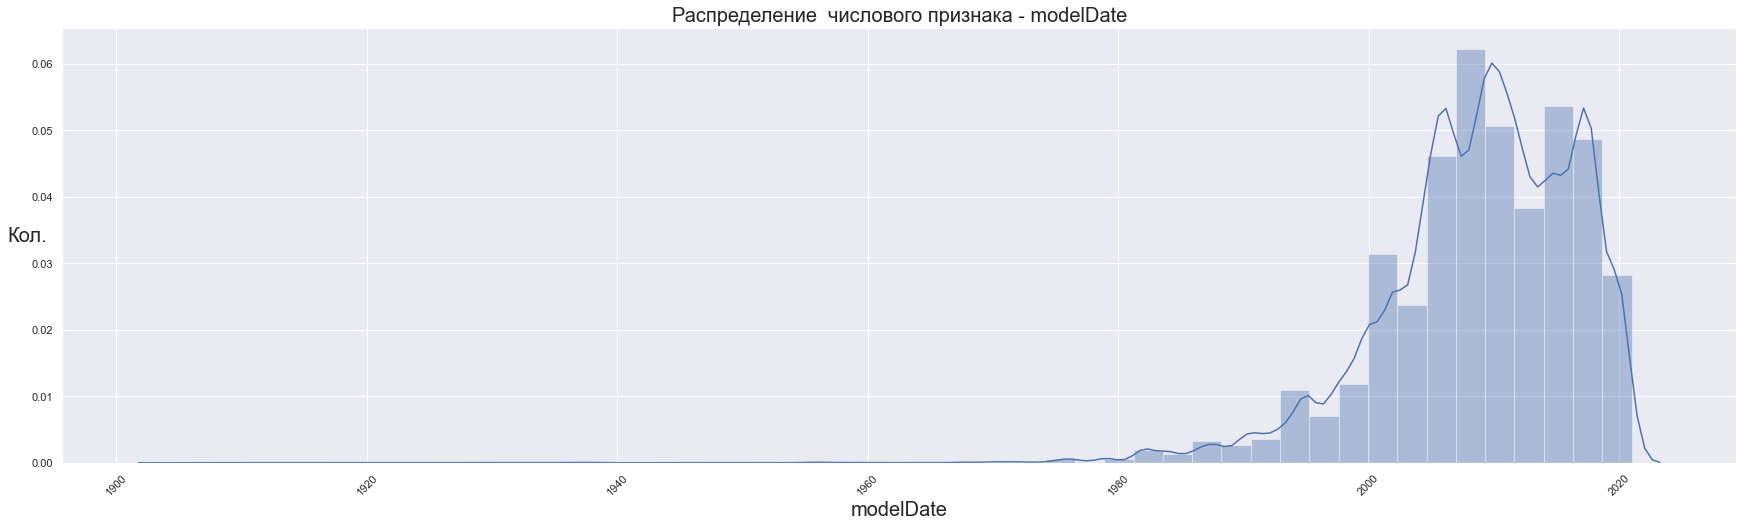

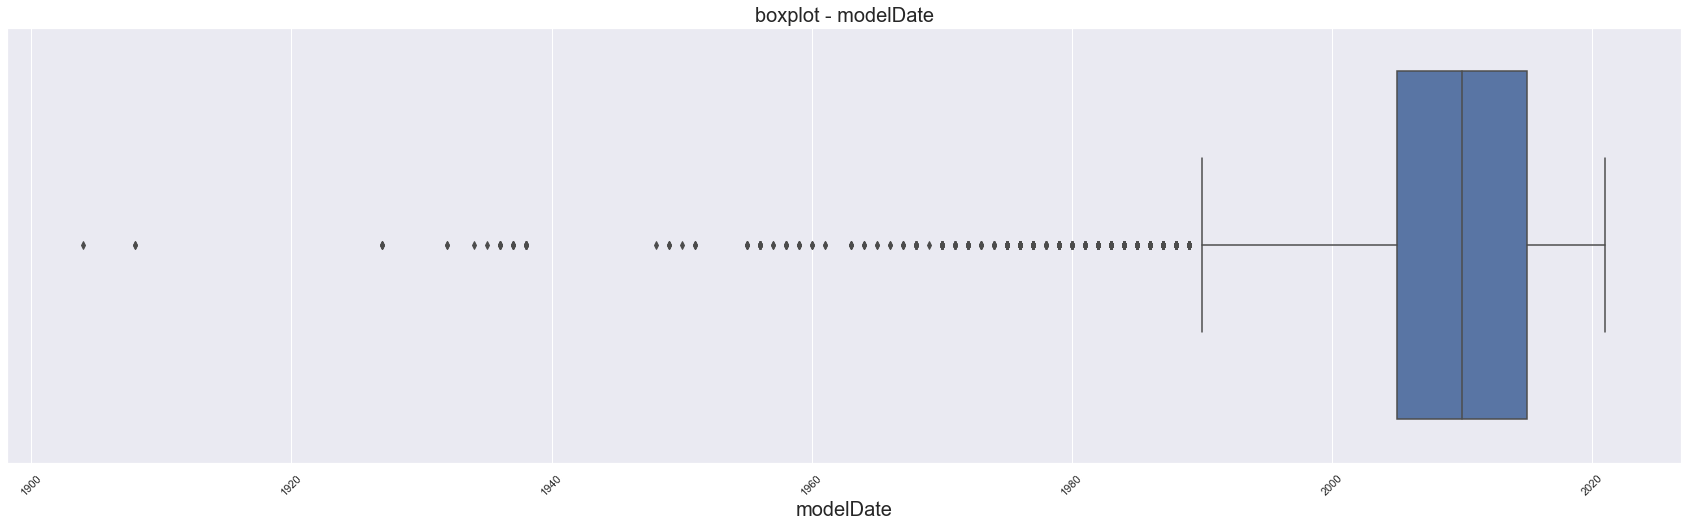

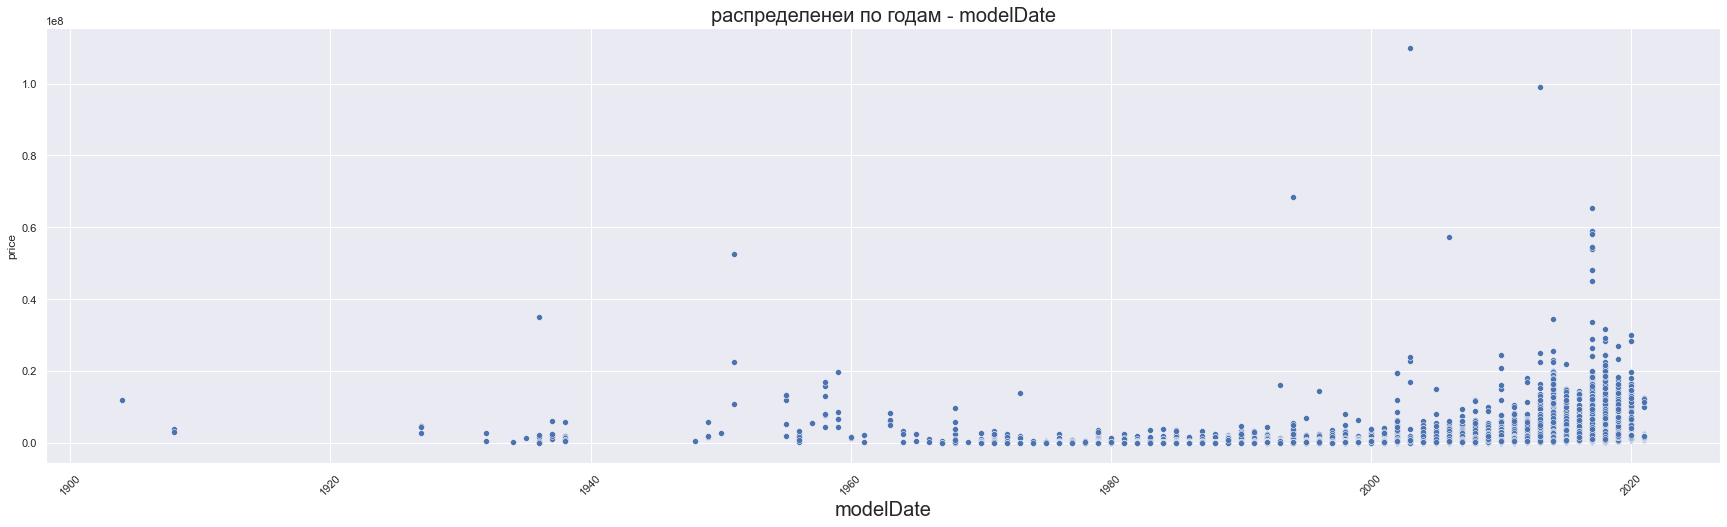

In [681]:
analiz_number_feature(data, 'modelDate', 1)

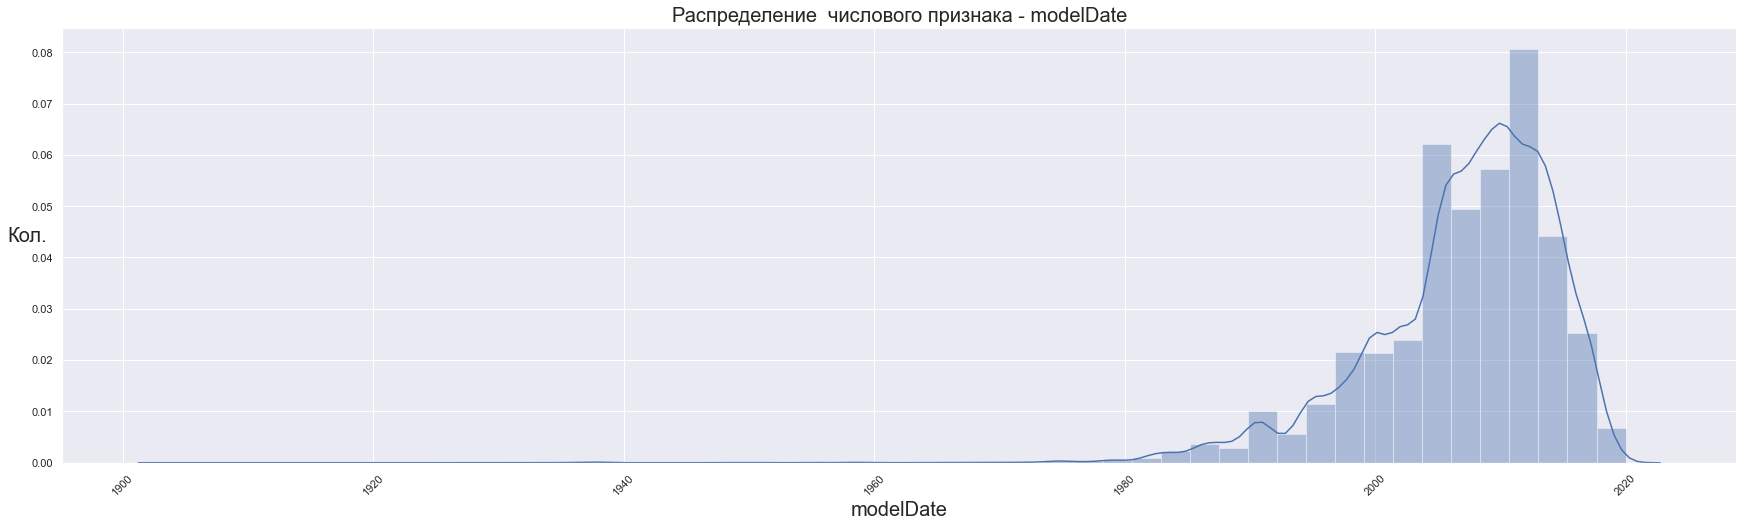

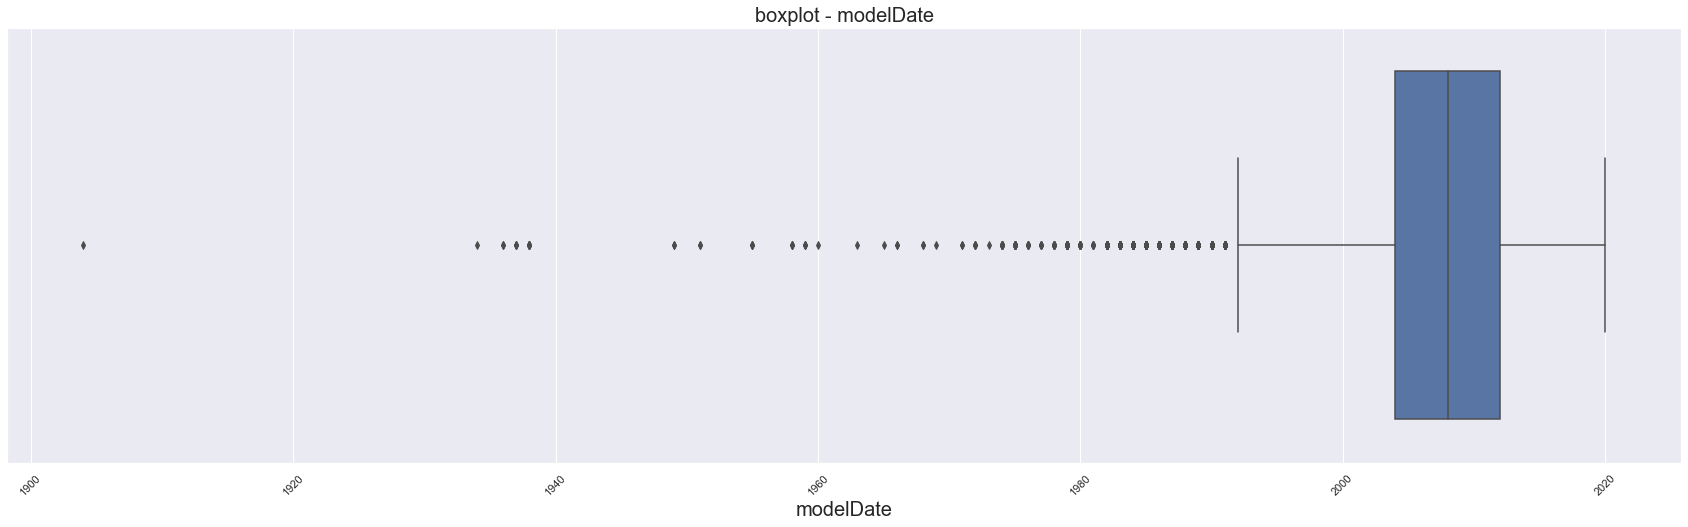

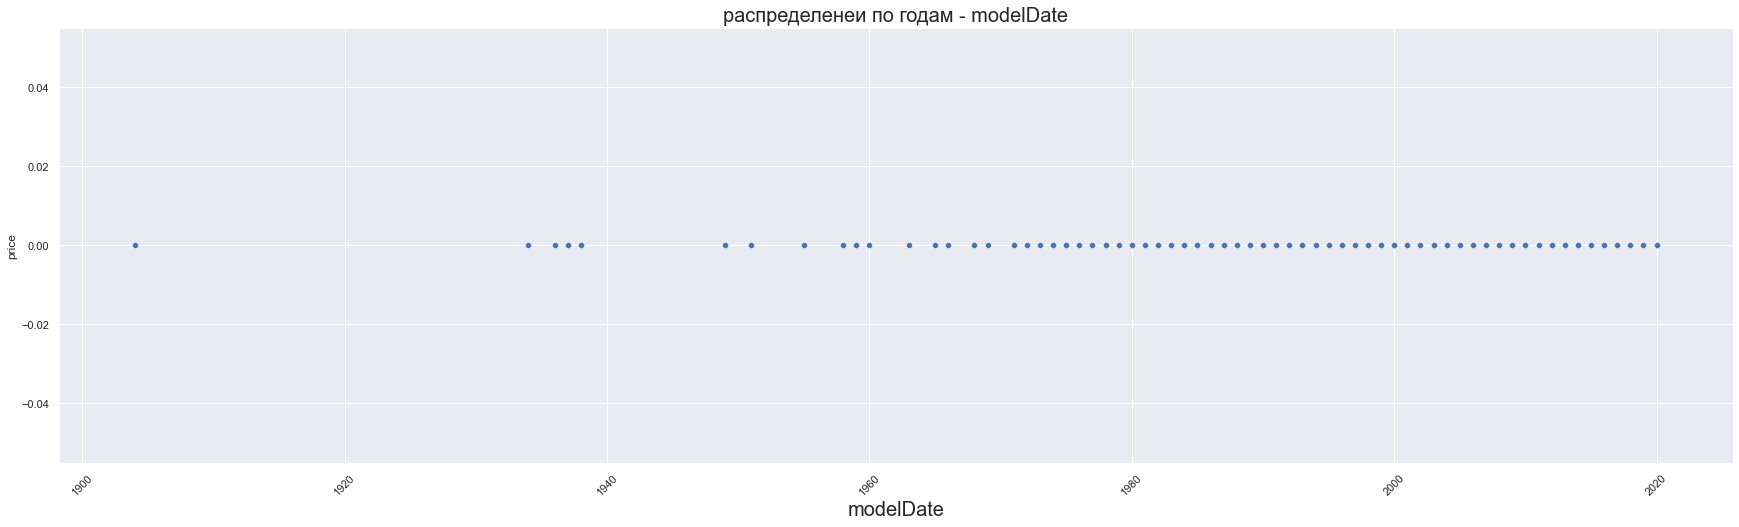

In [682]:
analiz_number_feature(data, 'modelDate', 0)

**Вывод** - modelDate будем использоват как числовой параметр
 
# productionDate

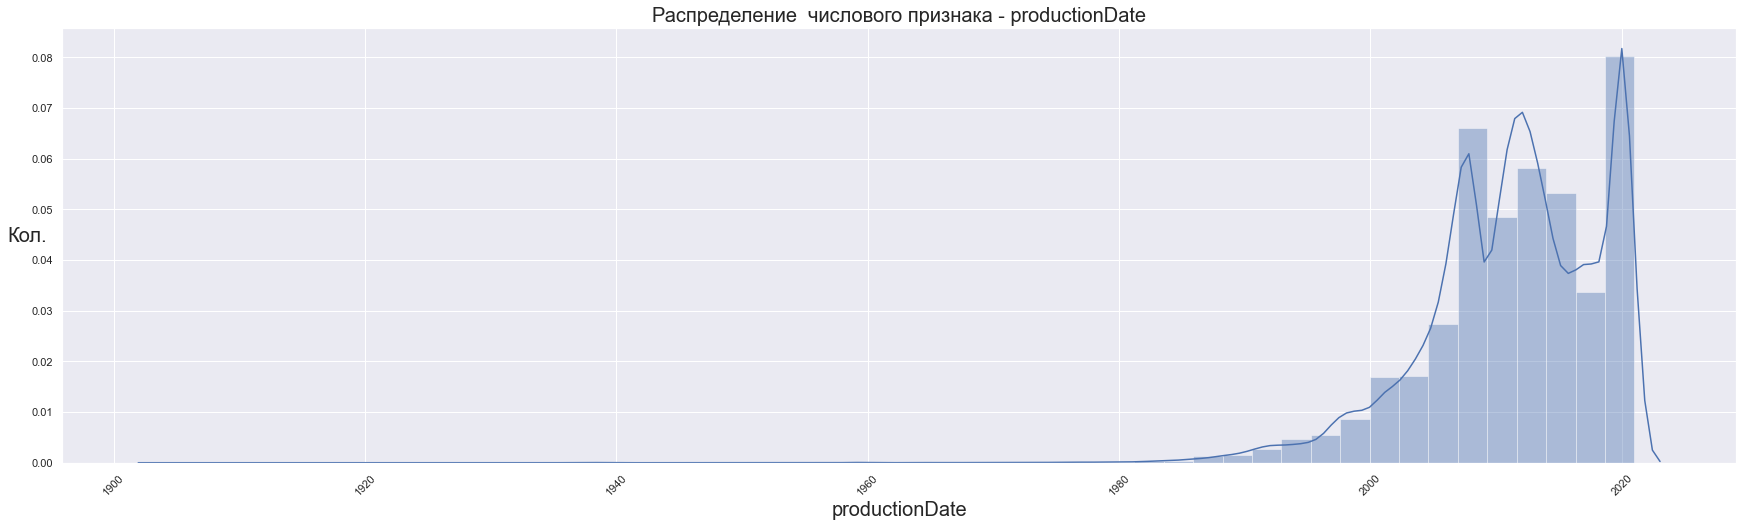

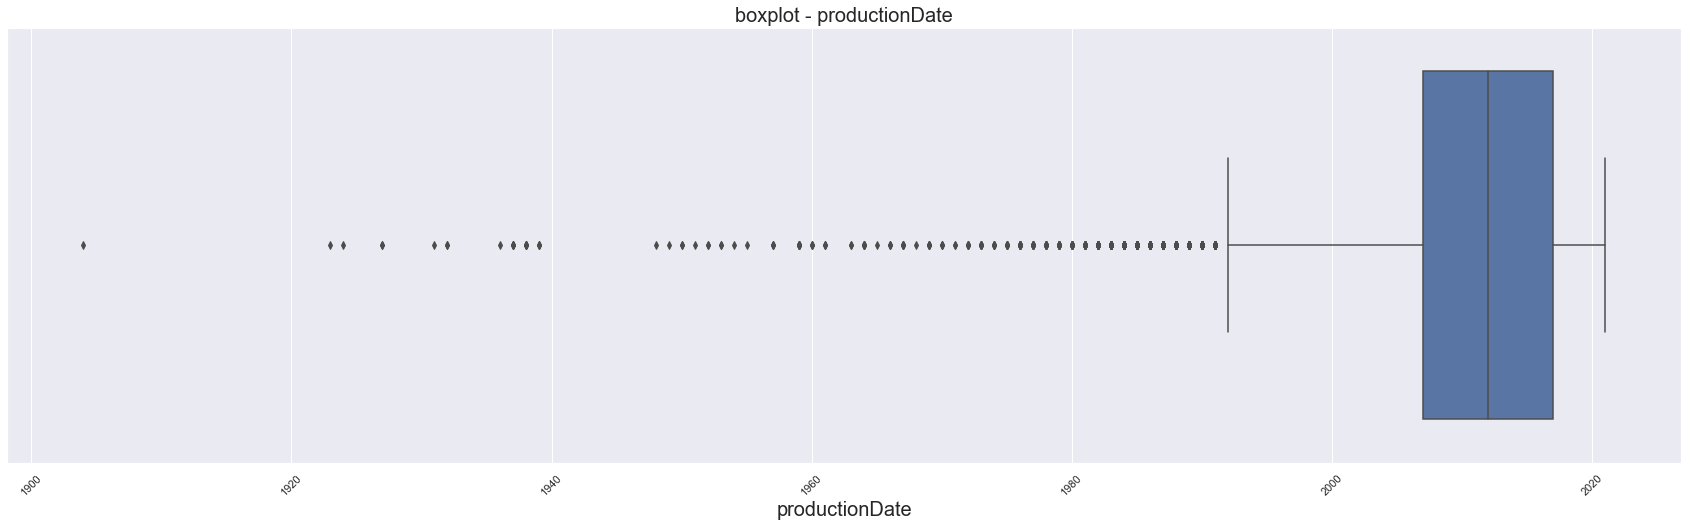

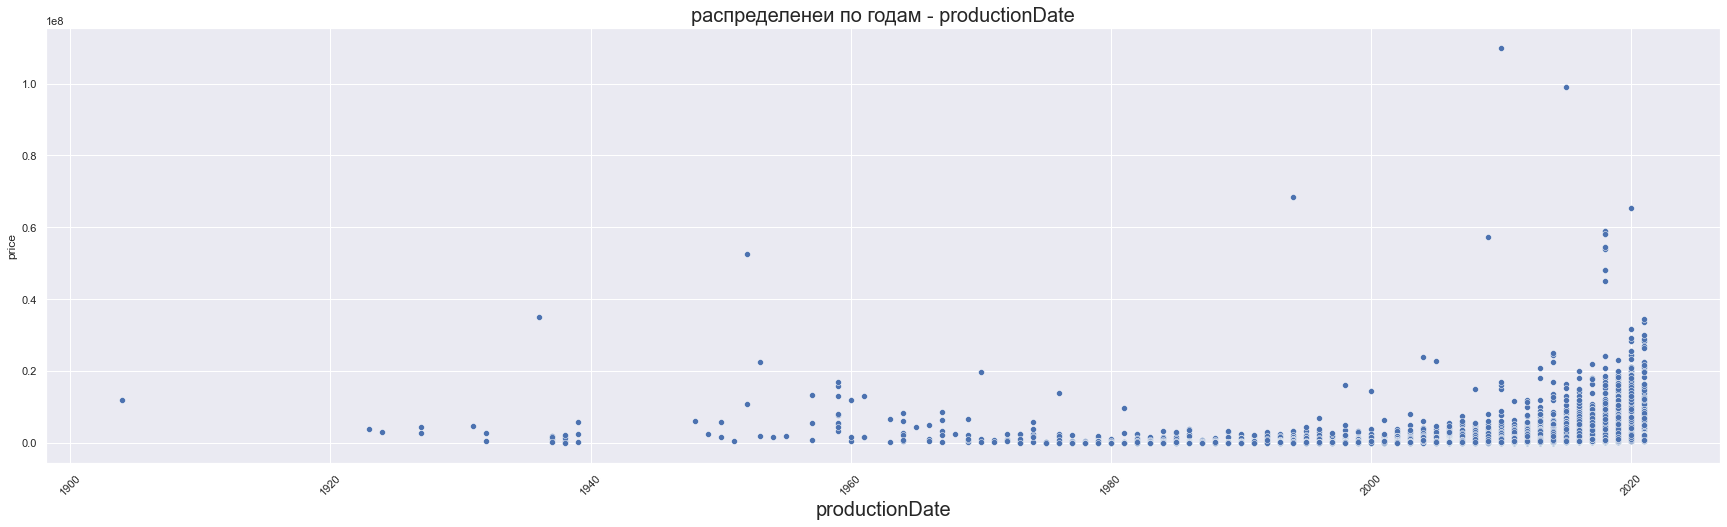

In [683]:
analiz_number_feature(data, 'productionDate', 1)

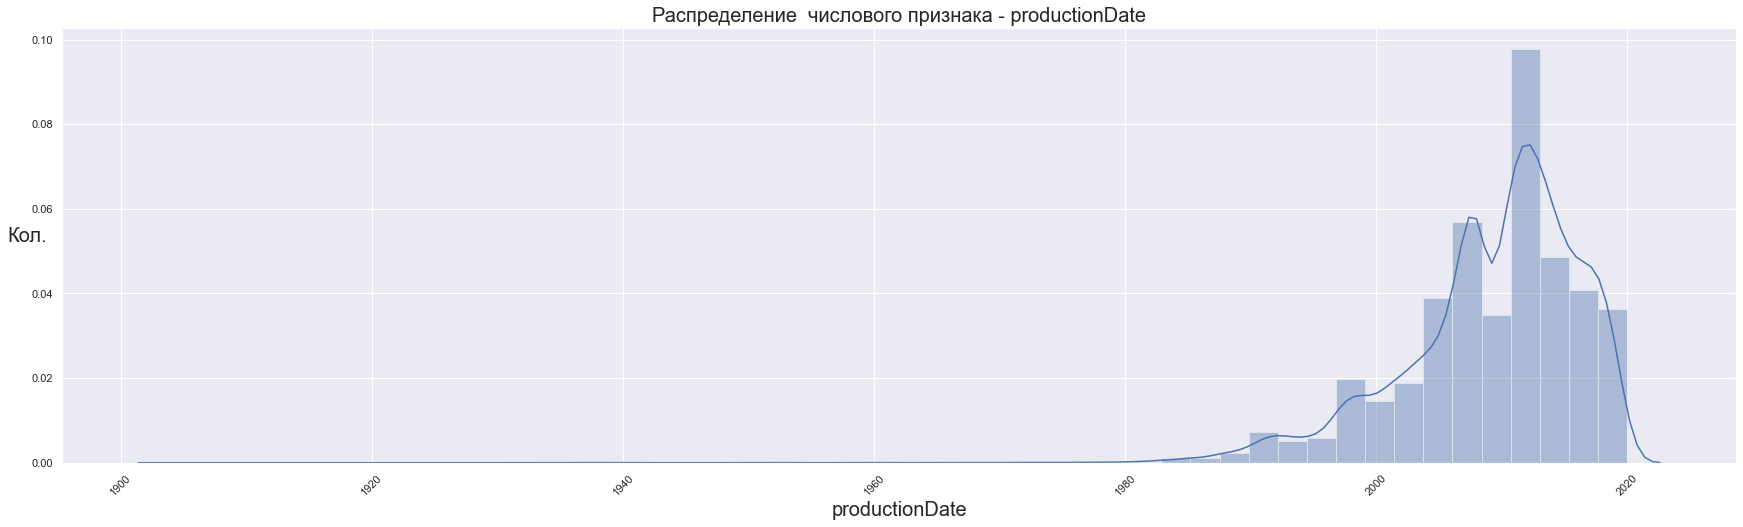

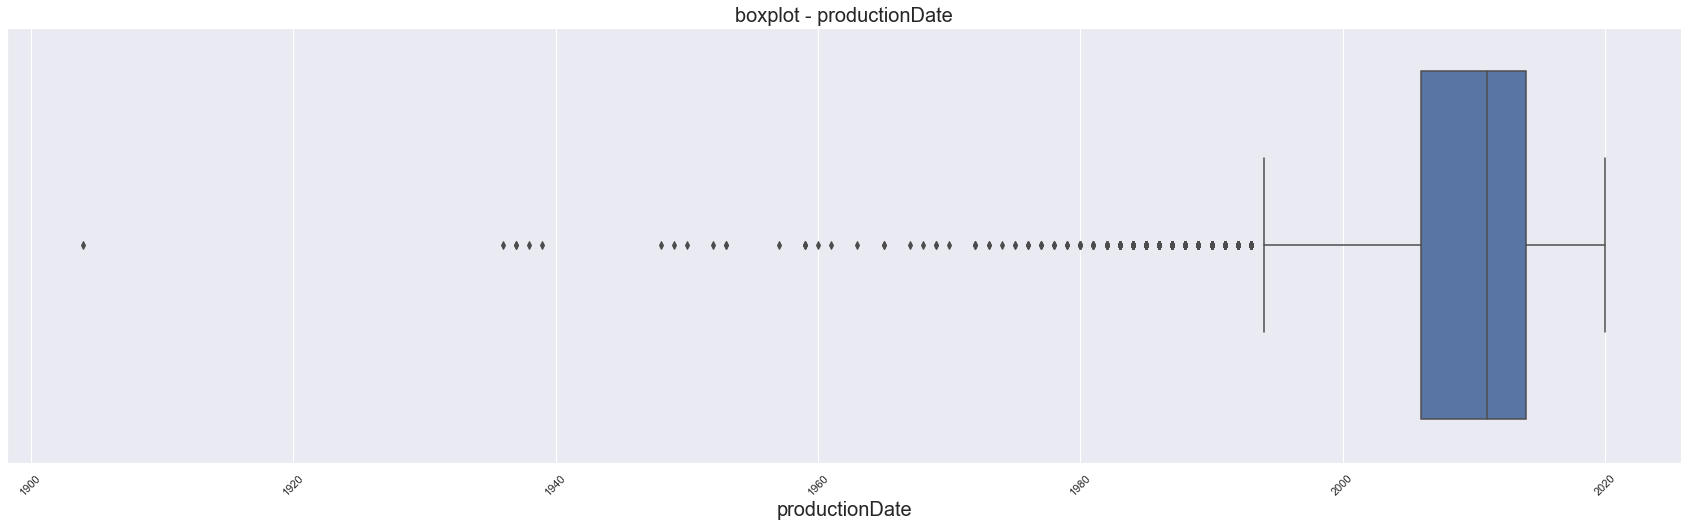

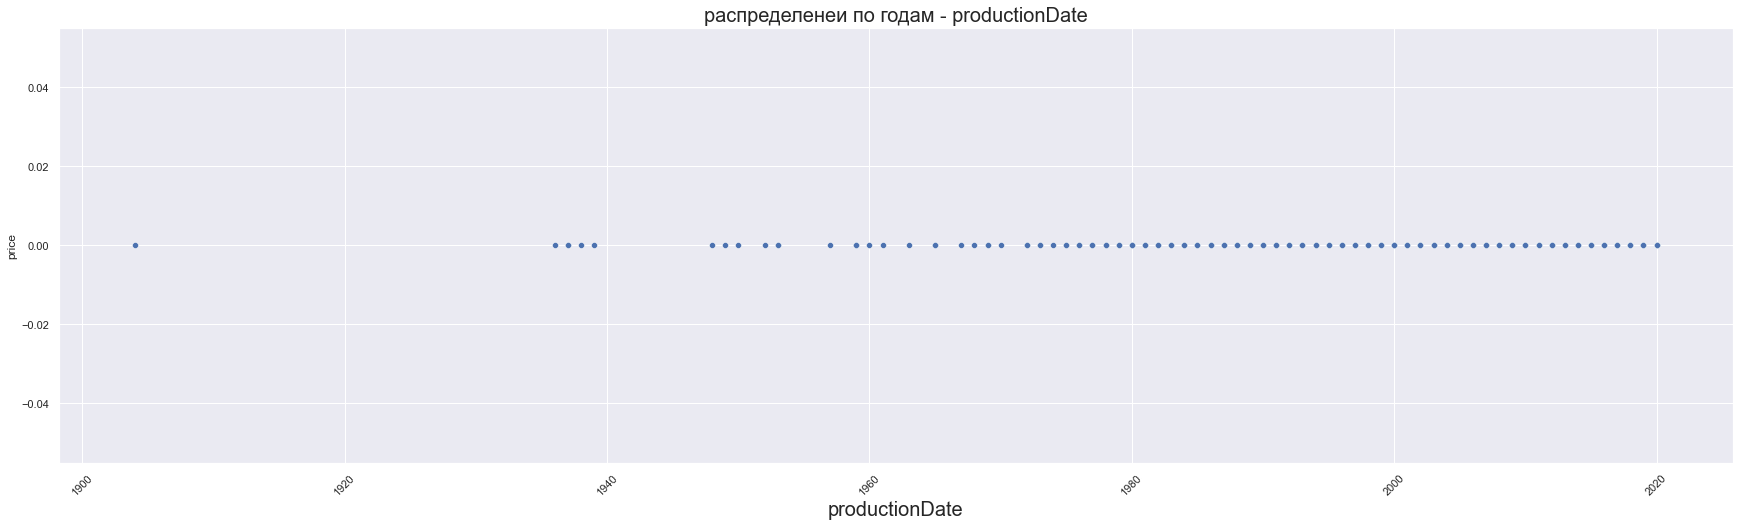

In [684]:
analiz_number_feature(data, 'productionDate', 0)

In [685]:
train[train['productionDate'] < 1950][['bodyType', 'vendor', 'price']]

bodyType    vendor       price
302            седан  EUROPEAN  2000000.00
5802     седан 2 дв.  EUROPEAN  1000000.00
5803     седан 2 дв.  EUROPEAN  2500000.00
5804     седан 2 дв.  EUROPEAN  6000000.00
5805     седан 2 дв.  EUROPEAN  2000000.00
5806           седан  EUROPEAN   440000.00
5807           седан  EUROPEAN  1700000.00
22540  хэтчбек 3 дв.  AMERICAN  4703812.00
22541  хэтчбек 3 дв.  AMERICAN  4500000.00
22542  хэтчбек 3 дв.  AMERICAN  2700000.00
22543      кабриолет  AMERICAN  3800000.00
22544      кабриолет  AMERICAN  3000000.00
23566          седан  AMERICAN  2700000.00
23567          седан  AMERICAN   480000.00
23568        фастбек  AMERICAN  5800000.00
51445          седан  EUROPEAN  2500000.00
53955          седан  EUROPEAN  1500000.00
54056          седан  EUROPEAN   210000.00
54057          седан  EUROPEAN   135000.00
61452  хэтчбек 3 дв.  EUROPEAN   300000.00
87551      кабриолет  EUROPEAN 12000000.00
88134          седан  EUROPEAN 35000000.00
88135          седан  EUROPEAN  2300000.00

**Вывод** - modelDate будем использоват как числовой параметр. Видно можно добавить признак раритетности авто.
 
# production_model
разница  в годах между производством авто и годом ее модели

In [686]:
data['production_model'] = data['productionDate'] - data['modelDate']

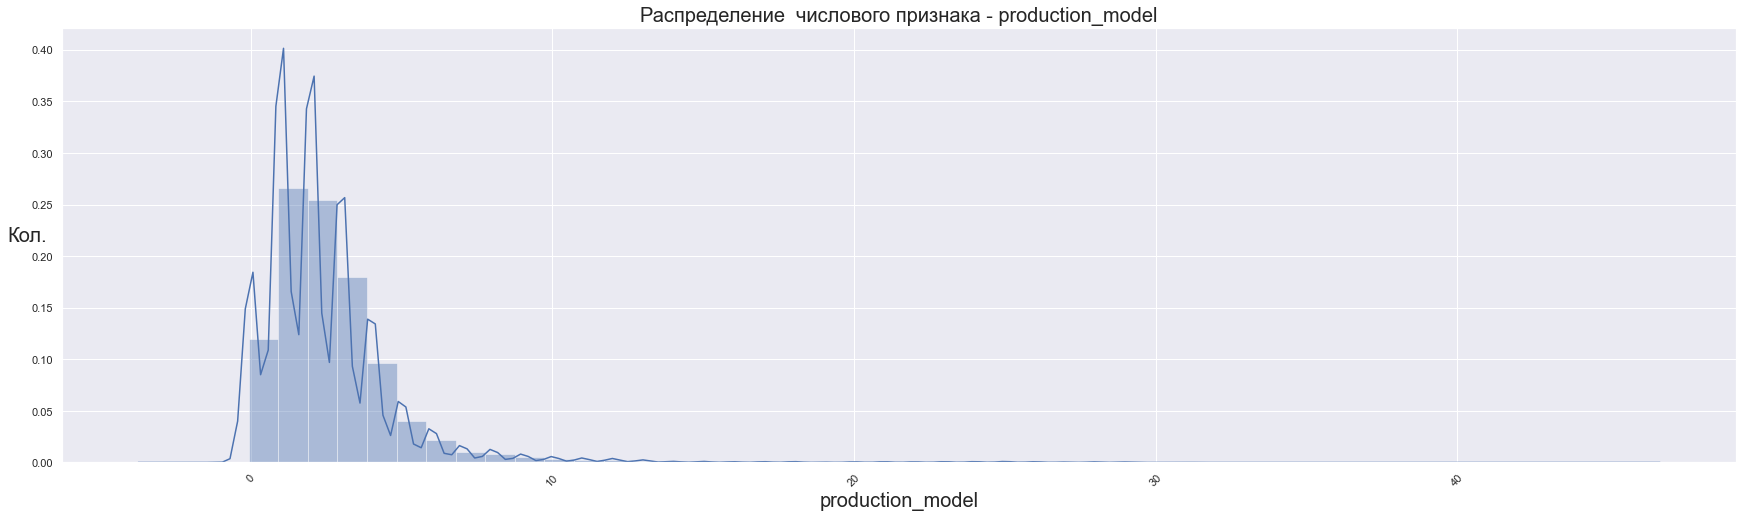

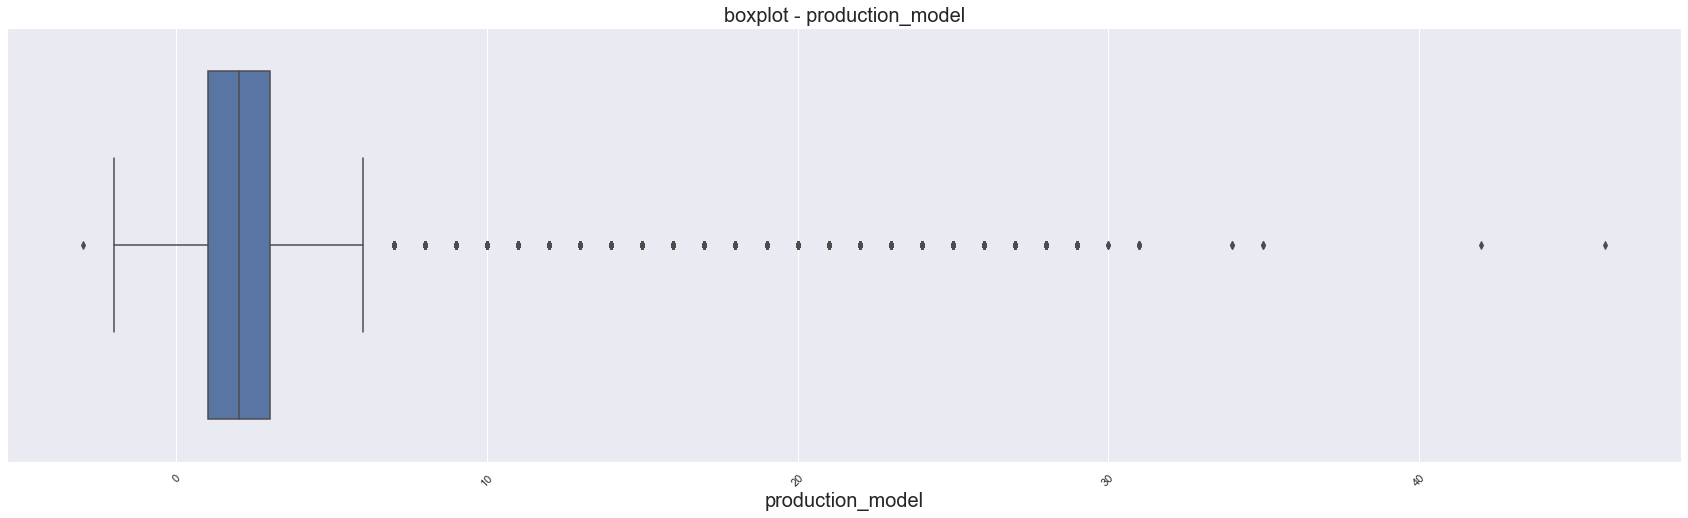

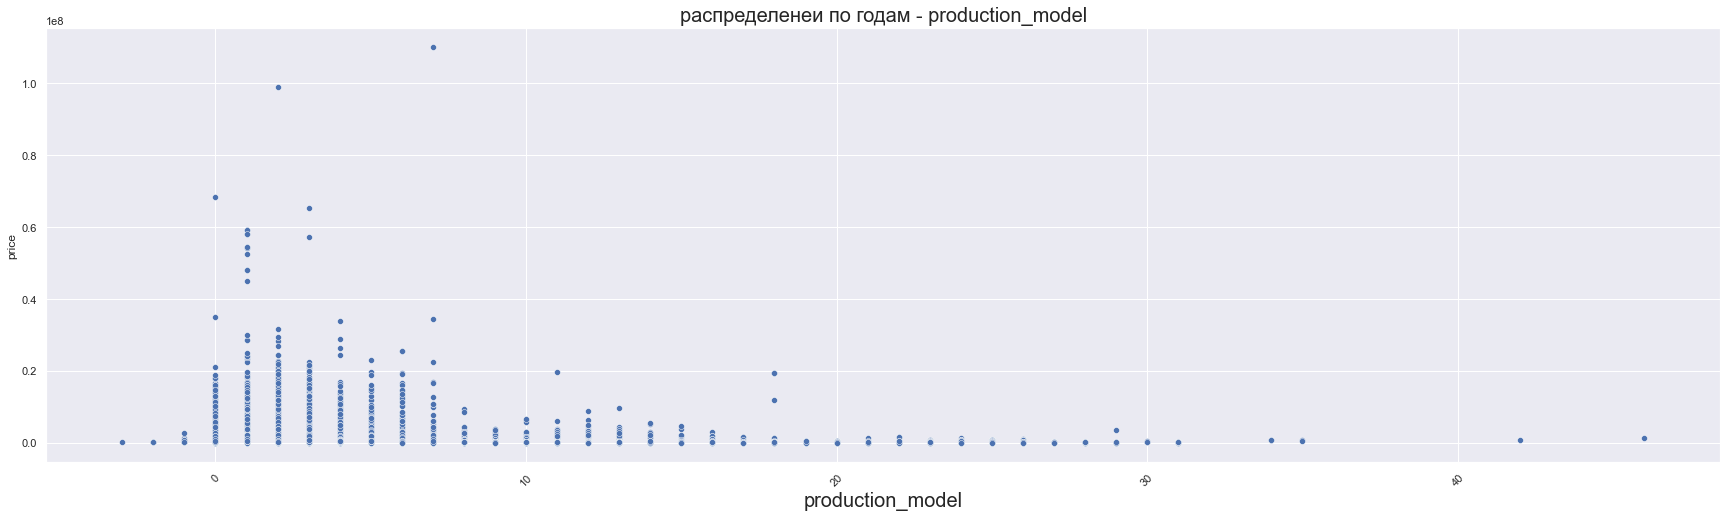

In [687]:
analiz_number_feature(data, 'production_model', 1)

In [688]:
data[data['production_model'] < 0]

car_url           bodyType  \
21068   https://auto.ru/cars/used/sale/toyota/camry/11...              седан   
27908   https://auto.ru/cars/used/sale/mitsubishi/dion...         компактвэн   
28045   https://auto.ru/cars/used/sale/mitsubishi/dion...         компактвэн   
28581   https://auto.ru/cars/used/sale/mitsubishi/dion...         компактвэн   
28762   https://auto.ru/cars/used/sale/mitsubishi/dion...         компактвэн   
46671                                                 NaN              седан   
60746                                                 NaN  внедорожник 5 дв.   
76926                                                 NaN         компактвэн   
76928                                                 NaN         компактвэн   
76929                                                 NaN         компактвэн   
76930                                                 NaN         компактвэн   
76931                                                 NaN         компактвэн   
76932                                                 NaN         компактвэн   
86437                                                 NaN      хэтчбек 3 дв.   
86514                                                 NaN      хэтчбек 3 дв.   
86748                                                 NaN      хэтчбек 3 дв.   
97869                                                 NaN           микровэн   
99789                                                 NaN              седан   
122608                                                NaN            минивэн   
124108  https://auto.ru/cars/used/sale/subaru/forester...  внедорожник 5 дв.   
124389  https://auto.ru/cars/used/sale/mitsubishi/dion...         компактвэн   
127060  https://auto.ru/cars/used/sale/subaru/forester...  внедорожник 5 дв.   
131607  https://auto.ru/cars/used/sale/opel/astra/1105...      хэтчбек 3 дв.   
135548  https://auto.ru/cars/used/sale/bmw/5er/1105602...              седан   
140194  https://auto.ru/cars/used/sale/volkswagen/pass...              седан   
148330  https://auto.ru/cars/used/sale/uaz/patriot/110...  внедорожник 5 дв.   

             brand        color fuelType  modelDate  numberOfDoors  \
21068       toyota       чёрный   бензин       2017              4   
27908   mitsubishi       чёрный   бензин       2002              5   
28045   mitsubishi      бежевый   бензин       2002              5   
28581   mitsubishi       чёрный   бензин       2002              5   
28762   mitsubishi      зелёный   бензин       2002              5   
46671        chery       чёрный   бензин       2010              4   
60746      hyundai        белый   бензин       1997              5   
76926   mitsubishi       чёрный   бензин       2002              5   
76928   mitsubishi       чёрный   бензин       2002              5   
76929   mitsubishi      бежевый   бензин       2002              5   
76930   mitsubishi       чёрный   бензин       2002              5   
76931   mitsubishi      зелёный   бензин       2002              5   
76932   mitsubishi  серебристый   бензин       2002              5   
86437         opel      красный   бензин       2012              3   
86514         opel      красный   бензин       2012              3   
86748         opel      красный   бензин       2012              3   
97869       subaru        белый   бензин       2009              5   
99789       toyota       чёрный   бензин       2017              4   
122608    mercedes        белый   дизель       1996              4   
124108      subaru  серебристый   бензин       2011              5   
124389  mitsubishi  серебристый   бензин       2002              5   
127060      subaru  серебристый   бензин       2011              5   
131607        opel       чёрный   бензин       2012              3   
135548         bmw  серебристый   дизель       2017              4   
140194  volkswagen   коричневый   бензин       2011              4   
148330         уаз      голубой   дизель       2005              5   

По данным видно что это скорее всего ошибка. Отрицательные значения приравняем к 0


In [689]:
data['production_model'] = data['production_model'].apply(lambda x : x if x > 0 else 0)

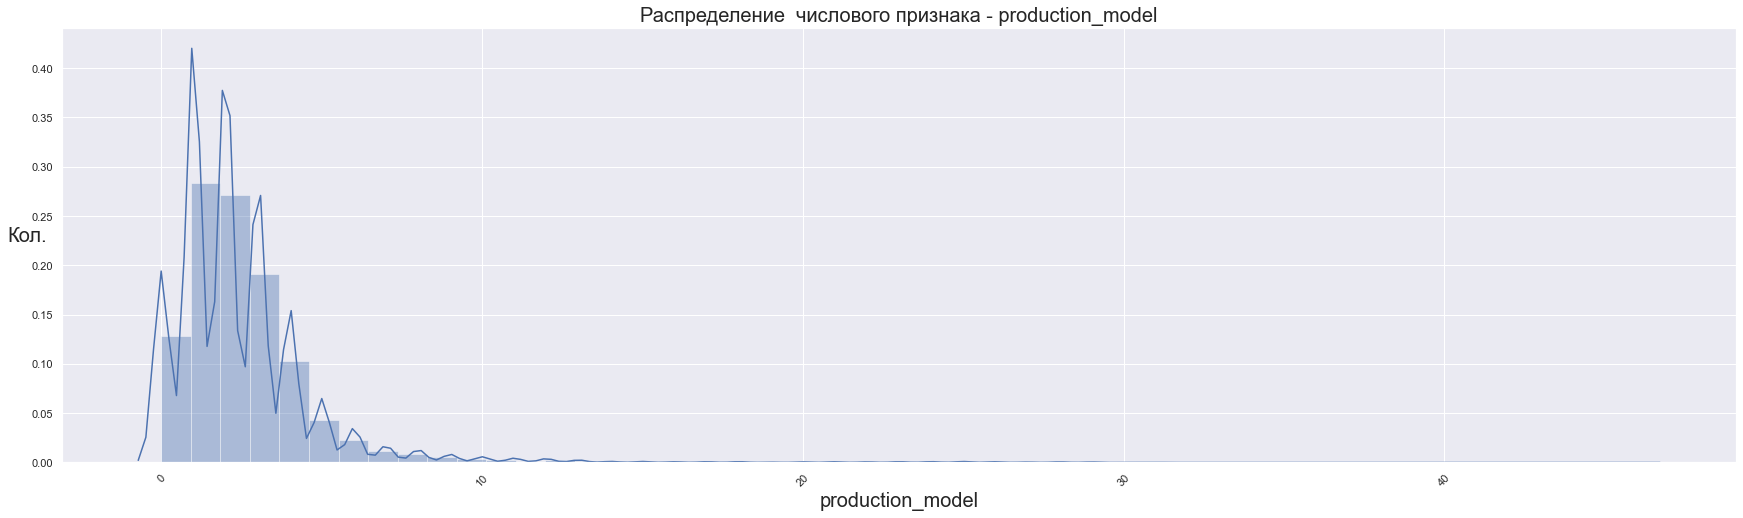

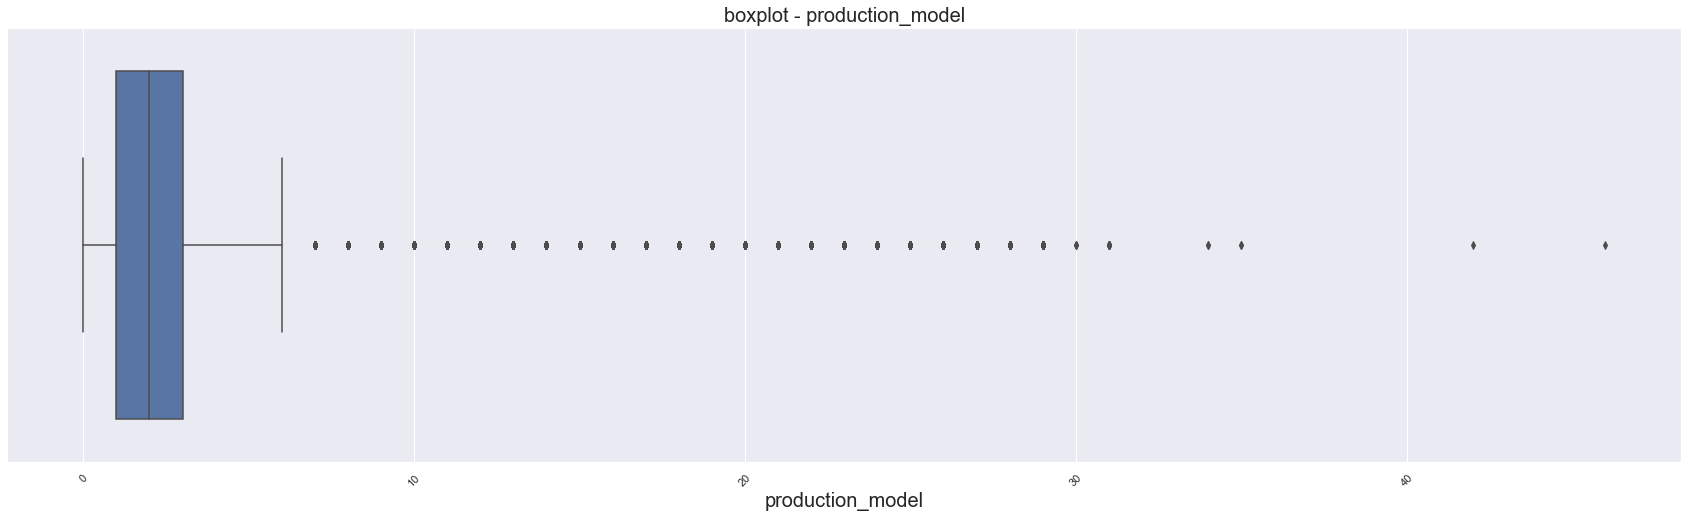

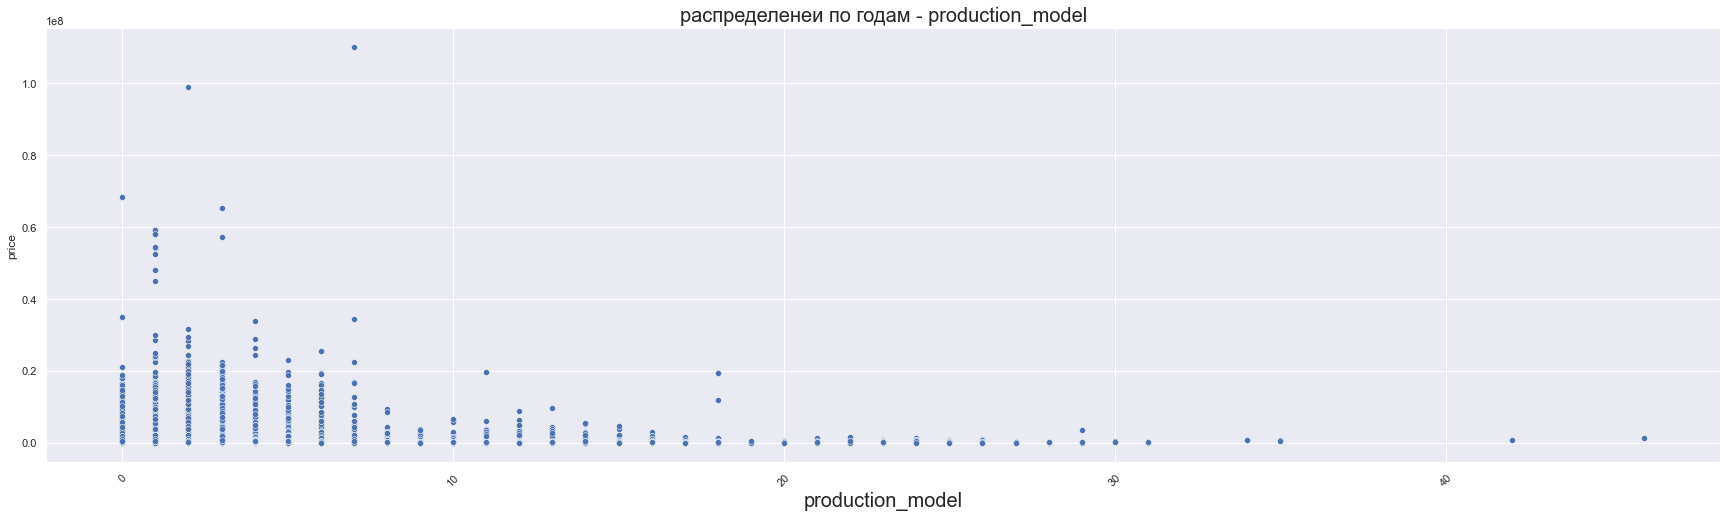

In [690]:
analiz_number_feature(data, 'production_model', 1)

**Вывод** - чем больше разница тем цена уменьшается

# enginePower
 мощность


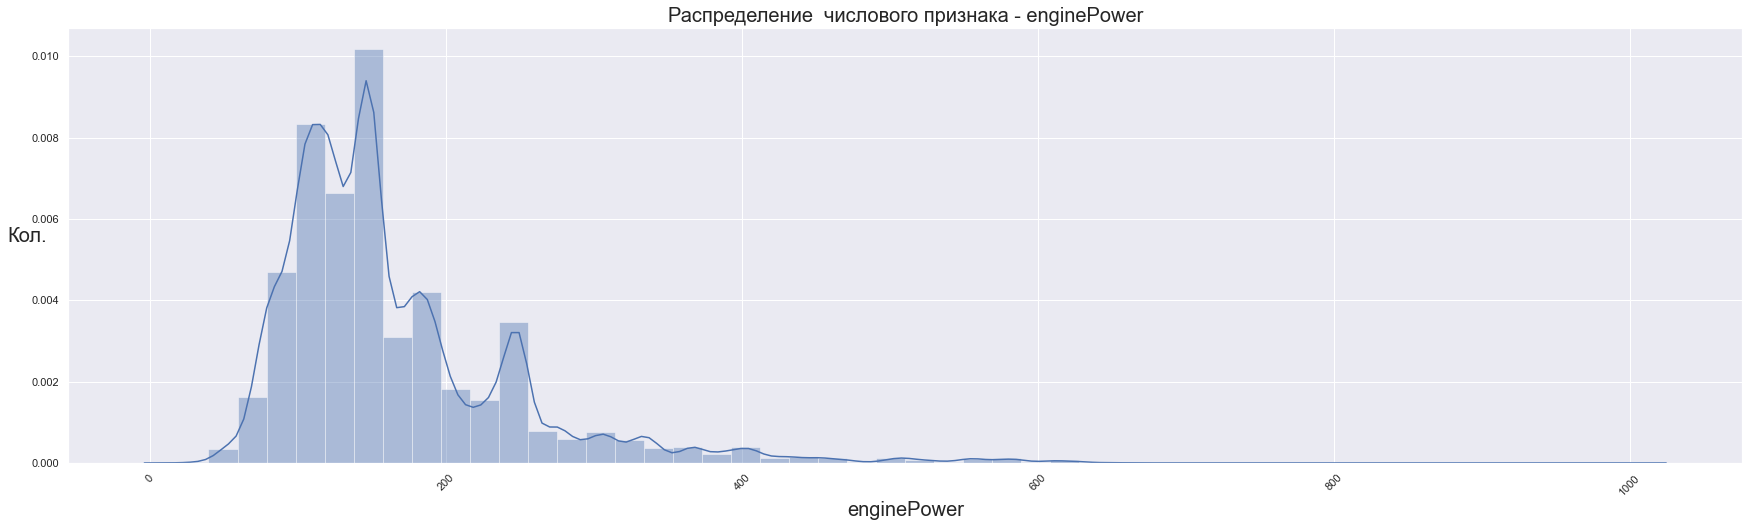

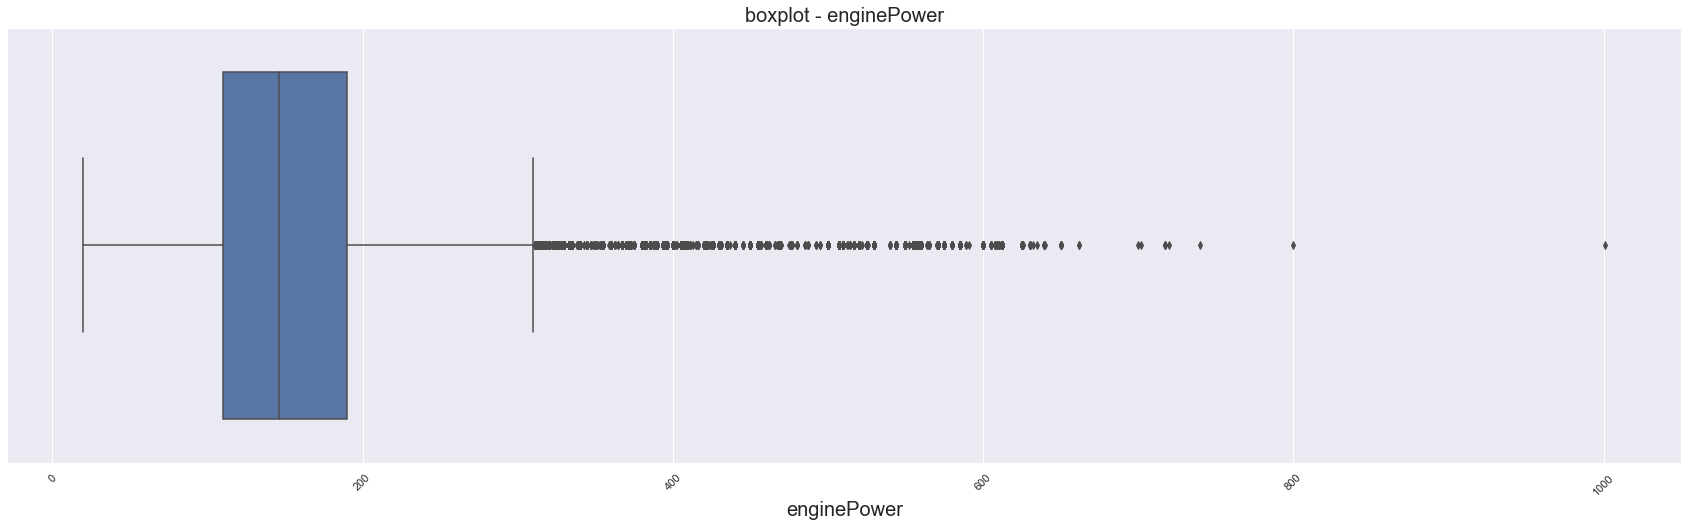

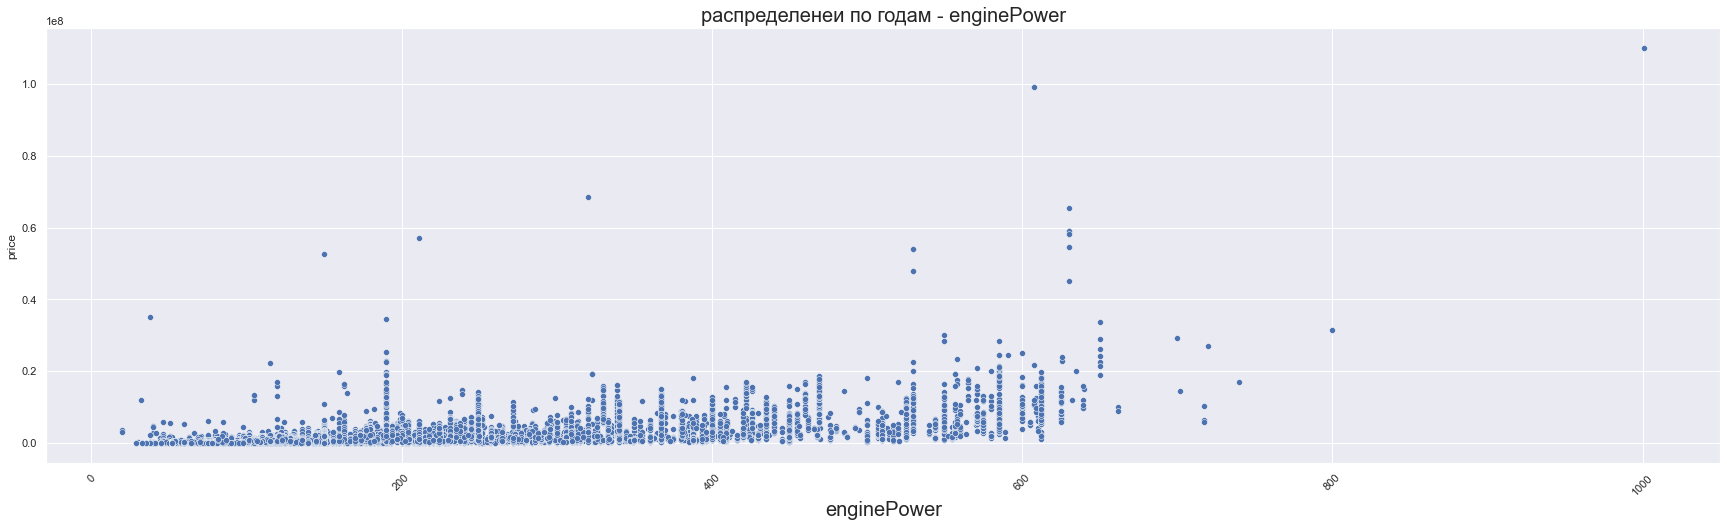

In [691]:
analiz_number_feature(data, 'enginePower', 1)

**Вывод**  - как и ожидалось тем больше мощность тем выше цена

# engineDisplacement
объем двигателя


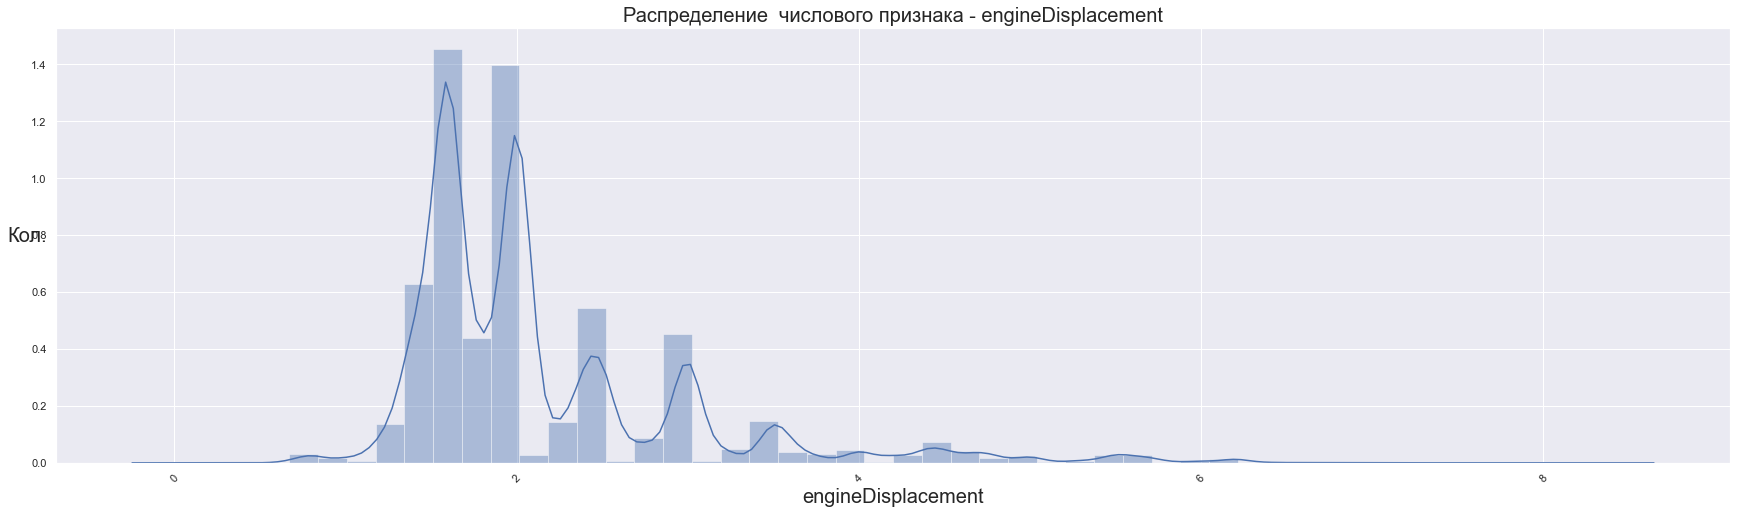

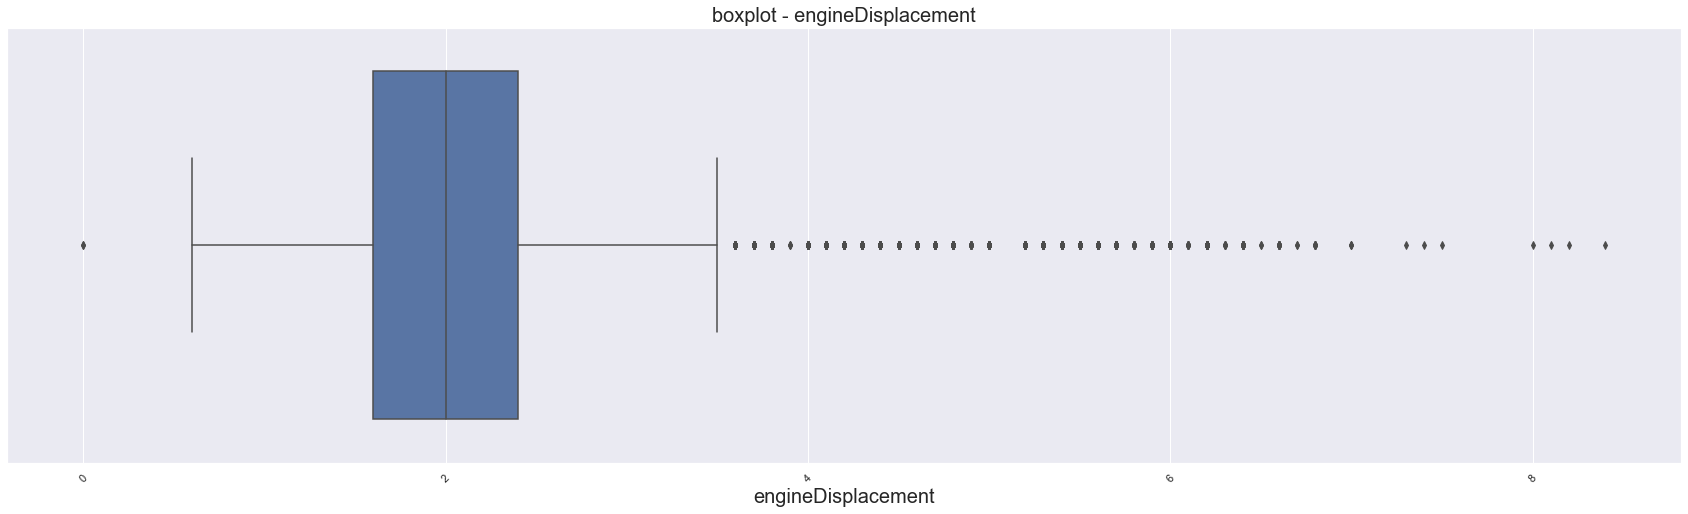

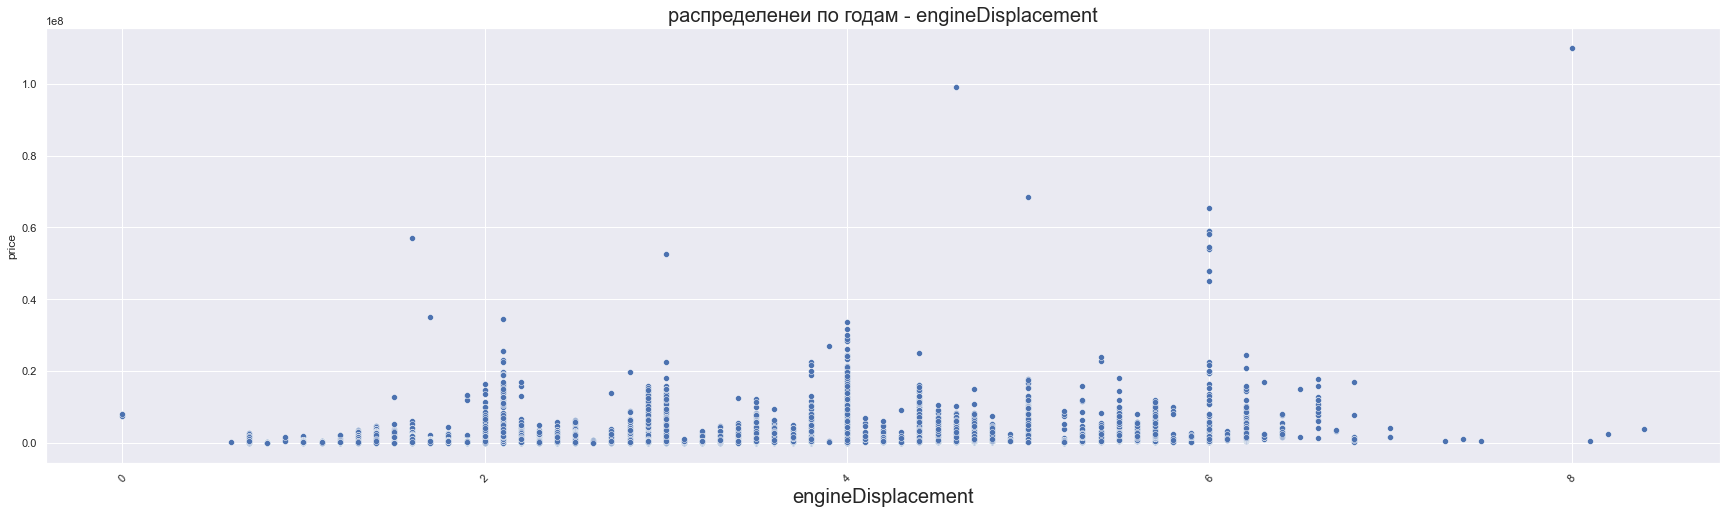

In [692]:
analiz_number_feature(data, 'engineDisplacement', 1)

In [693]:
data[data['engineDisplacement'] < 0]

car_url           bodyType  \
5241   https://auto.ru/cars/used/sale/audi/e_tron/110...  внедорожник 5 дв.   
7992   https://auto.ru/cars/used/sale/bmw/i3/11010431...      хэтчбек 5 дв.   
8252   https://auto.ru/cars/used/sale/bmw/i3/11012780...      хэтчбек 5 дв.   
8350   https://auto.ru/cars/used/sale/bmw/i3/11002716...      хэтчбек 5 дв.   
8684   https://auto.ru/cars/used/sale/bmw/i3/11011745...      хэтчбек 5 дв.   
8722   https://auto.ru/cars/used/sale/bmw/i3/11000973...      хэтчбек 5 дв.   
8917   https://auto.ru/cars/used/sale/bmw/i3/11008715...      хэтчбек 5 дв.   
10817  https://auto.ru/cars/used/sale/bmw/i3/11012664...      хэтчбек 5 дв.   
10936  https://auto.ru/cars/used/sale/bmw/i3/10996733...      хэтчбек 5 дв.   
11043  https://auto.ru/cars/used/sale/bmw/i3/10993761...      хэтчбек 5 дв.   
11302  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
11682  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
11714  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
11719  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
11754  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
11878  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
11974  https://auto.ru/cars/used/sale/nissan/leaf/108...      хэтчбек 5 дв.   
12072  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
12085  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12100  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12250  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12287  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12334  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
12466  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
12481  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
12558  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12582  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12678  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12749  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12854  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12916  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12948  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
12950  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
13052  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
13104  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
13105  https://auto.ru/cars/used/sale/nissan/leaf/108...      хэтчбек 5 дв.   
13478  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
13633  https://auto.ru/cars/used/sale/nissan/leaf/100...      хэтчбек 5 дв.   
13660  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
13720  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
13812  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
13915  https://auto.ru/cars/used/sale/nissan/leaf/108...      хэтчбек 5 дв.   
13952  https://auto.ru/cars/used/sale/nissan/leaf/110...      хэтчбек 5 дв.   
13989  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
14147  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
14419  https://auto.ru/cars/used/sale/nissan/leaf/109...      хэтчбек 5 дв.   
23869  https://auto.ru/cars/used/sale/volkswagen/golf...      хэтчбек 5 дв.   
23948  https://auto.ru/cars/used/sale/volkswagen/golf...      хэтчбек 5 дв.   
27064  https://auto.ru/cars/used/sale/mitsubishi/i_mi...      хэтчбек 5 дв.   
28241  https://auto.ru/cars/used/sale/mitsubishi/i_mi...      хэтчбек 5 дв.   
32668  https://auto.

**Вывод**  - явной связи ценой с объемом двигателя не прослежтивается. Отрицательные заначения  - это как бы пометил что значения неизвестны. (Видно что электромашины) Это может быть связано с возрастом авто

# car_age
вычислим как start_year  минус production_model

In [694]:
data['car_age'] = data['start_year'] - data['productionDate']

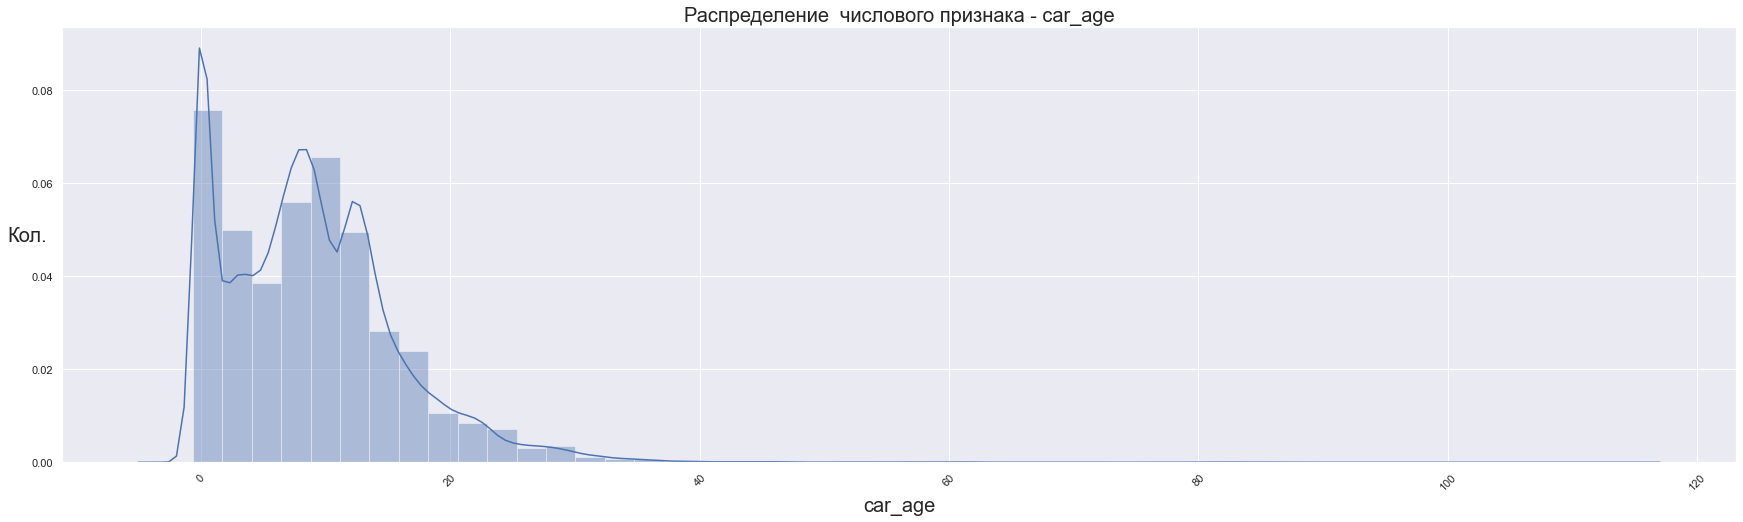

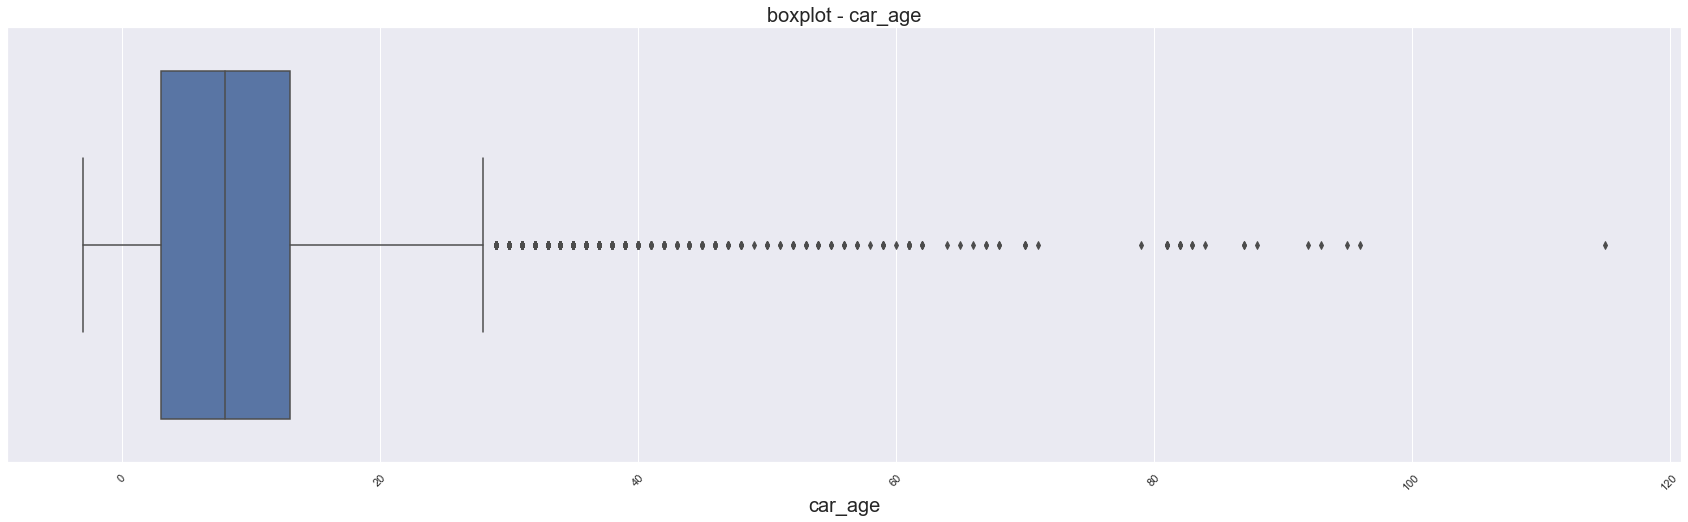

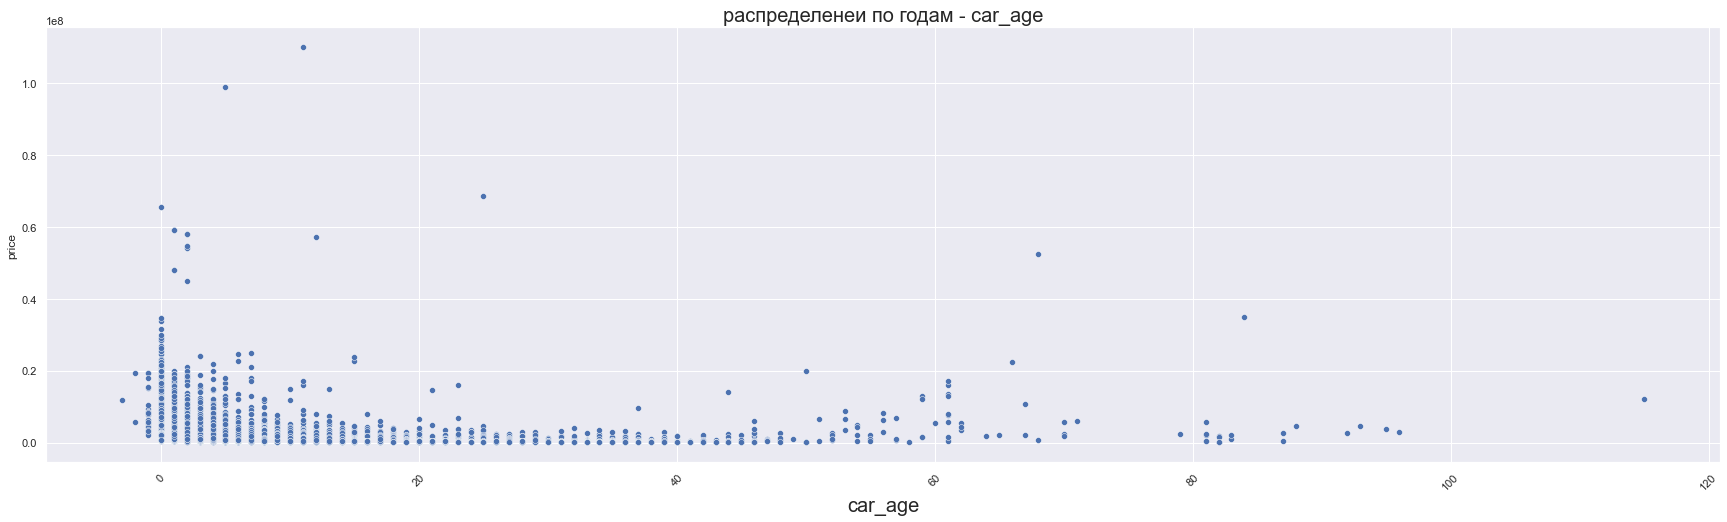

In [695]:
analiz_number_feature(data, 'car_age', 1)

In [696]:
data[data['car_age'] < 0]

car_url              bodyType      brand      color fuelType  \
43352      NaN     внедорожник 5 дв.        bmw      белый   бензин   
46264      NaN     внедорожник 5 дв.   cadillac     чёрный   бензин   
46265      NaN     внедорожник 5 дв.   cadillac     чёрный   бензин   
46267      NaN     внедорожник 5 дв.   cadillac     чёрный   бензин   
48441      NaN               минивэн  chevrolet      белый   бензин   
48442      NaN               минивэн  chevrolet      синий   бензин   
48443      NaN               минивэн  chevrolet      серый   бензин   
48444      NaN               минивэн  chevrolet      синий   бензин   
50300      NaN  пикап двойная кабина  chevrolet     чёрный   бензин   
50576      NaN                 седан   chrysler      серый   бензин   
53148      NaN               минивэн      dodge      синий   бензин   
53300      NaN     внедорожник 5 дв.      dodge  пурпурный   бензин   
53935      NaN  пикап двойная кабина       ford      белый   бензин   
53944      NaN  пикап двойная кабина       ford      белый   дизель   
53947      NaN  пикап двойная кабина       ford      синий   бензин   
58014      NaN                  купе       ford     чёрный   бензин   
59589      NaN               минивэн      honda      белый   бензин   
59593      NaN               минивэн      honda      синий   бензин   
73433      NaN     внедорожник 5 дв.      lexus     чёрный   бензин   
98853      NaN     внедорожник 5 дв.     toyota      белый   бензин   
102322     NaN         хэтчбек 5 дв.     toyota    голубой   гибрид   
103330     NaN     внедорожник 5 дв.     toyota      белый   бензин   
103334     NaN     внедорожник 5 дв.     toyota      серый   бензин   
103354     NaN               минивэн     toyota      белый   бензин   
103357     NaN               минивэн     toyota    красный   бензин   
115092     NaN         хэтчбек 5 дв.   mercedes      белый   бензин   
116883     NaN                 седан   mercedes     чёрный   бензин   
117073     NaN                 седан   mercedes     чёрный   бензин   
118125     NaN     внедорожник 5 дв.   mercedes     чёрный   бензин   

        modelDate  numberOfDoors  productionDate vehicleTransmission  \
43352        2019              5            2020             автомат   
46264        2014              5            2019             автомат   
46265        2014              5            2019             автомат   
46267        2014              5            2019             автомат   
48441        2002              5            2020             автомат   
48442        2002              5            2020             автомат   
48443        2002              5            2020             автомат   
48444        2002              5            2020             автомат   
50300        2015              4            2020             автомат   
50576        2015              4            2020             автомат   
53148        2007              5            2020             автомат   
53300        2013              5            2020             автомат   
53935        2017              4            2020             автомат   
53944        2017              4            2020             автомат   
53947        2017              4            2020             автомат   
58014        2017              2            2020            механика   
59589        2018              5            2020             автомат   
59593        2018              5            2020             автомат   
73433        2015              5            2020             автомат   
98853        2013              5            2020             автомат   
102322       2015              5            2020             автомат   
103330       2017              5            2020             автомат   
103334       2017              5            2020             автомат   
103354       2010              5            2020             автомат   
103357       2010              5            2020             автомат   
1150

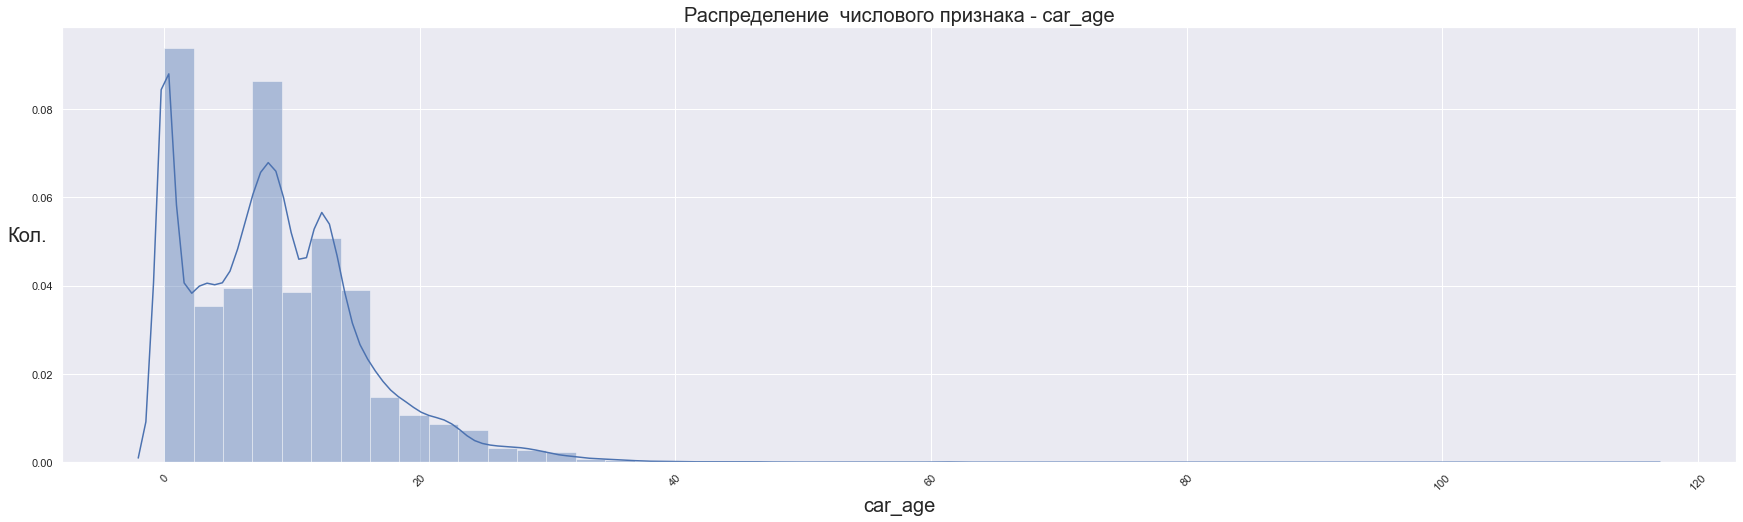

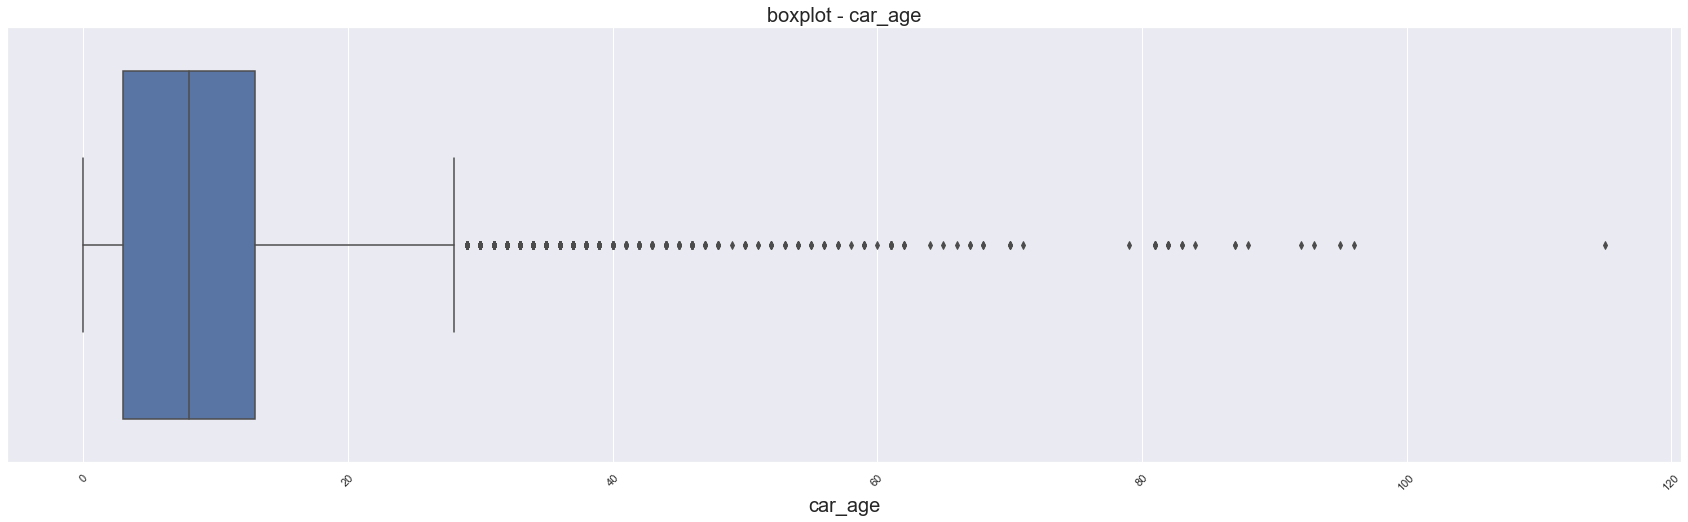

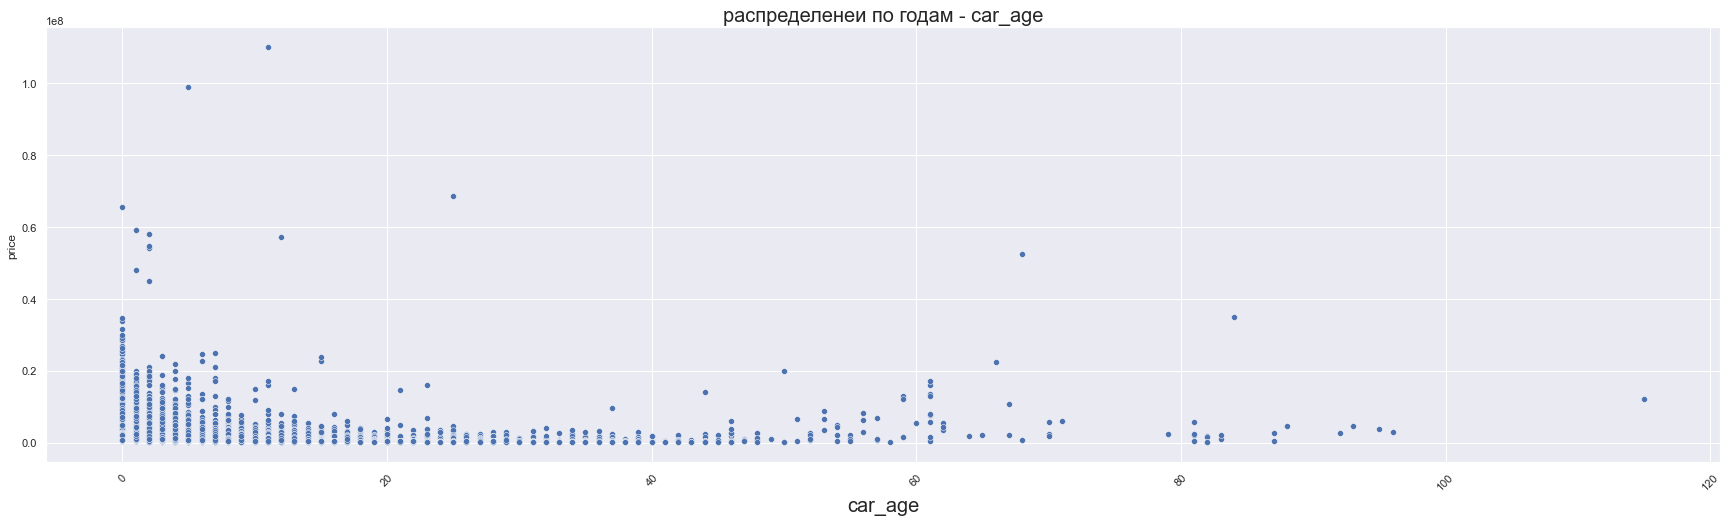

In [697]:
data['car_age'] = data['car_age'].apply(lambda x : x if x > 0 else 0)
analiz_number_feature(data, 'car_age', 1)

**Вывод**  - этот признак напрямую влияет на цену. Отрицатльные значения приравняем к 0, очень похоже на ошибку

# mileage
пробег и установим бинарный признак новая/неновое авто.


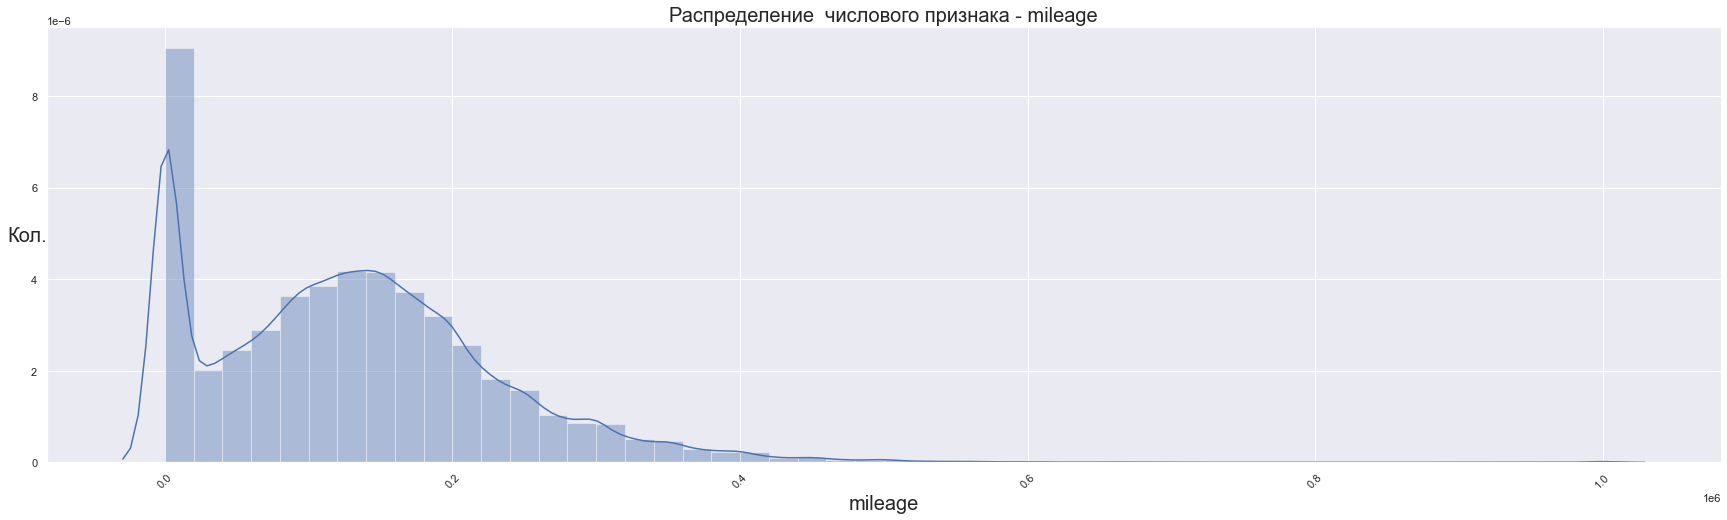

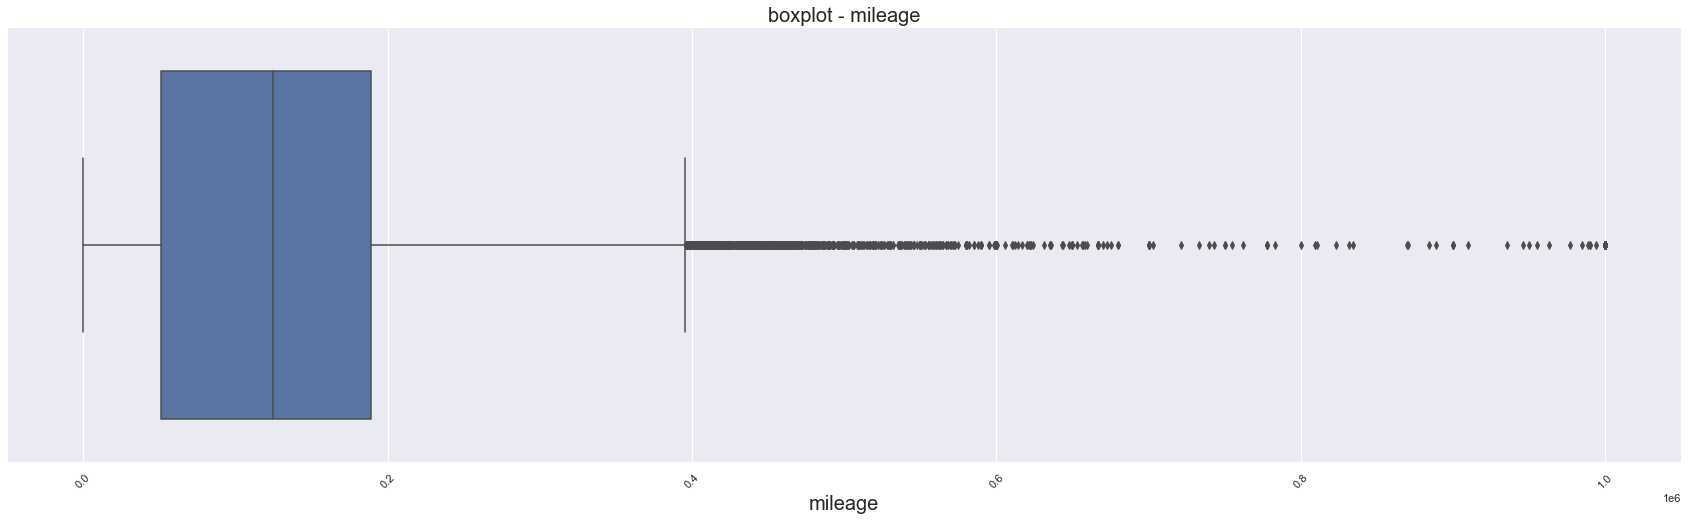

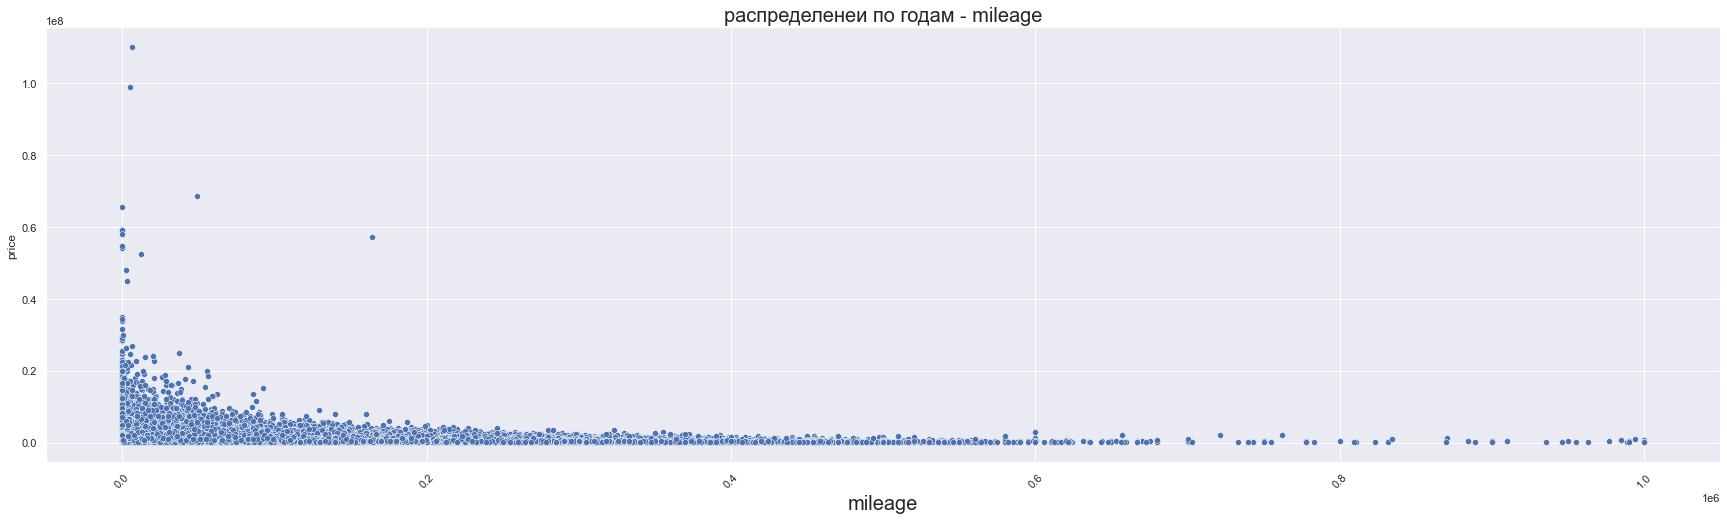

In [698]:
analiz_number_feature(data, 'mileage', 1)

**Вывод**  - этот признак  напрямую влияет на цену, цена убывает с возрастанием пробега

# racing
 Время разгона , неизвестные значения примем за -1 

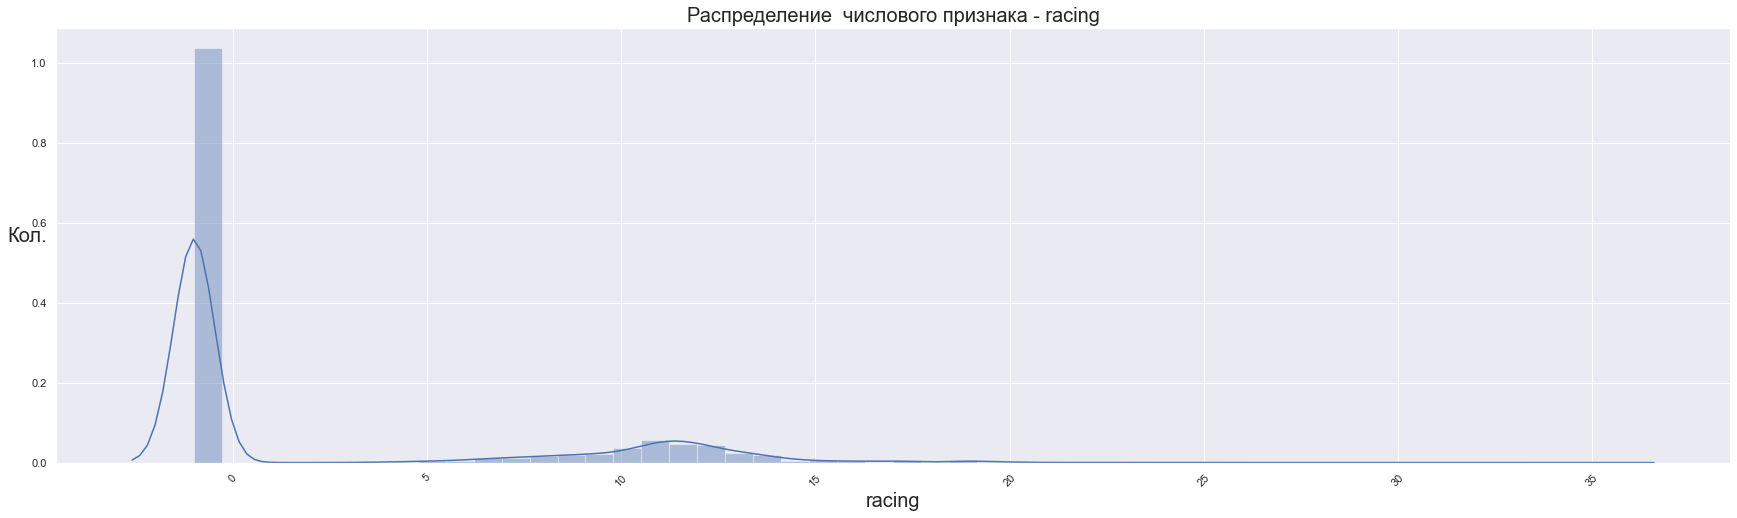

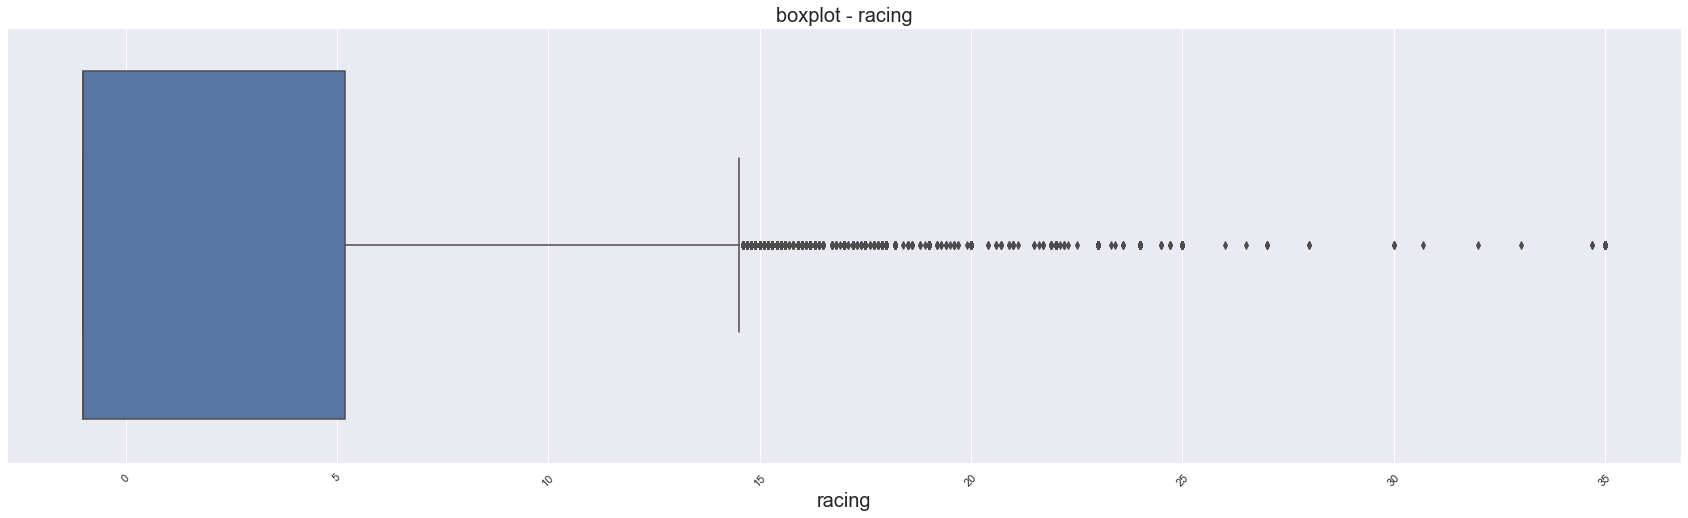

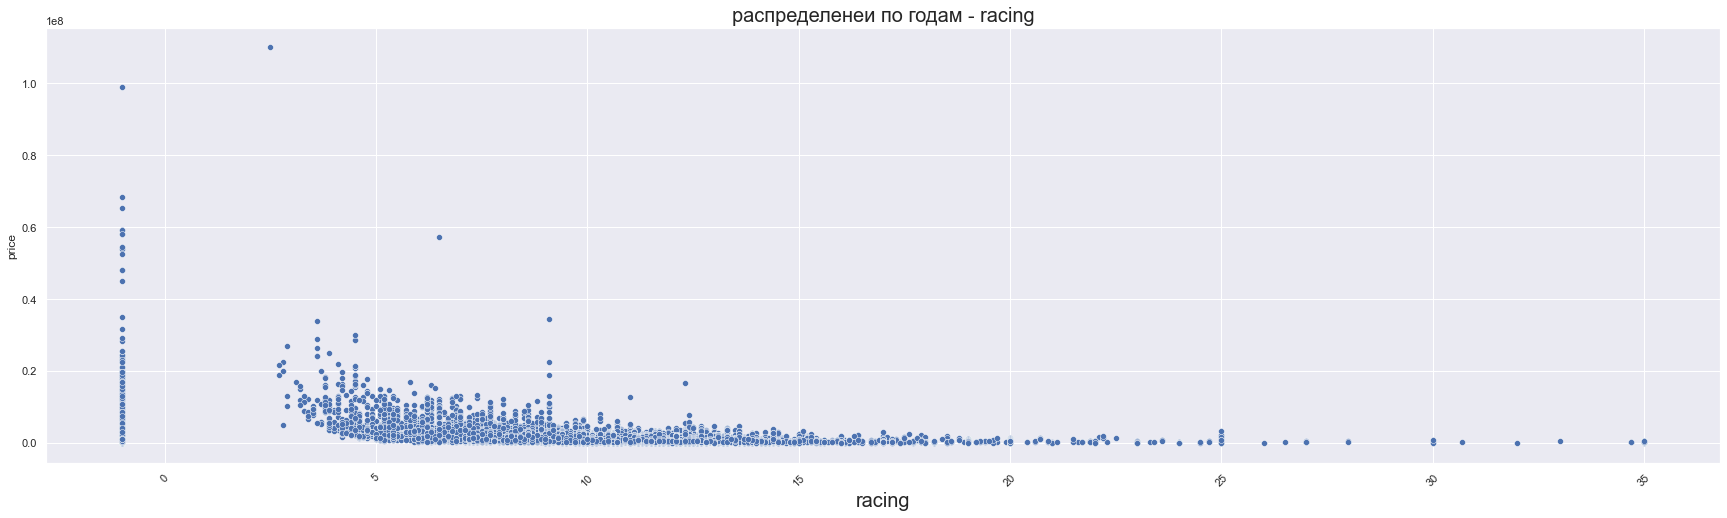

In [699]:
analiz_number_feature(data, 'racing', 1)

**Вывод**  - этот признак  напрямую влияет на цену, цена убывает с возрастанием разгона

# descrip_lenth
    Длина опсиания

In [700]:
data['descrip_lenth'] = data['description'].apply(lambda x: len(str(x)))

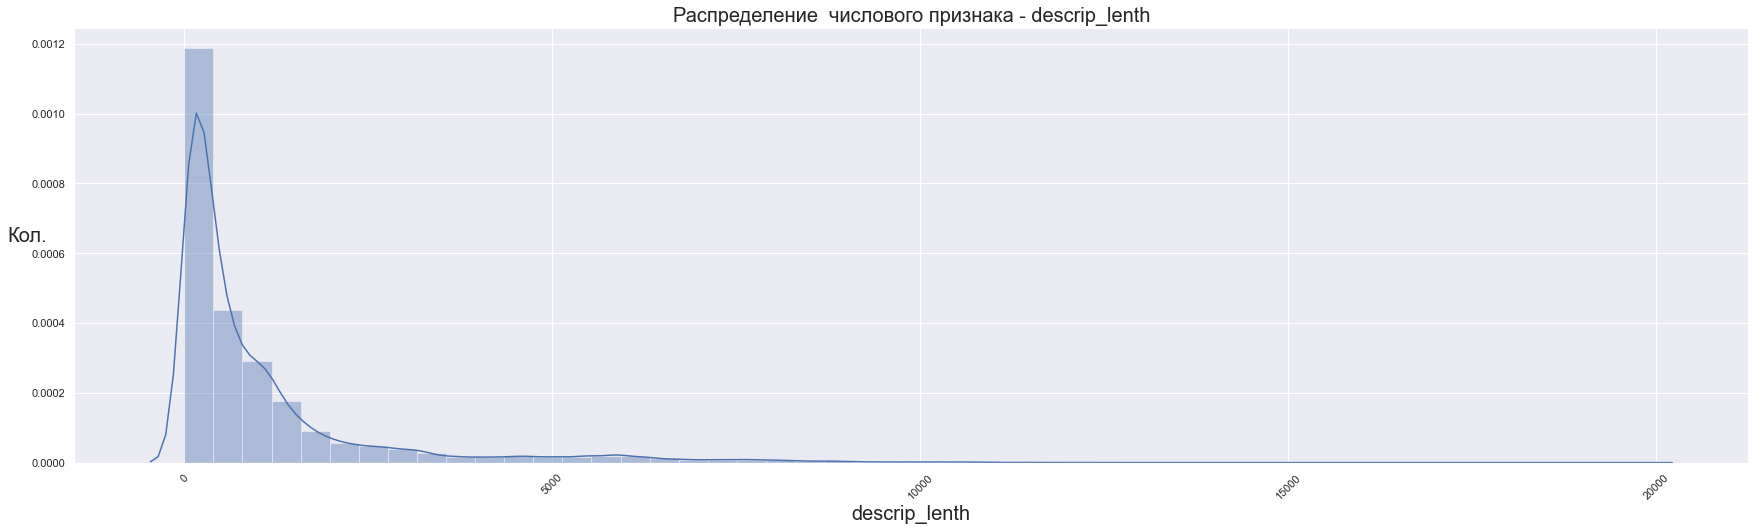

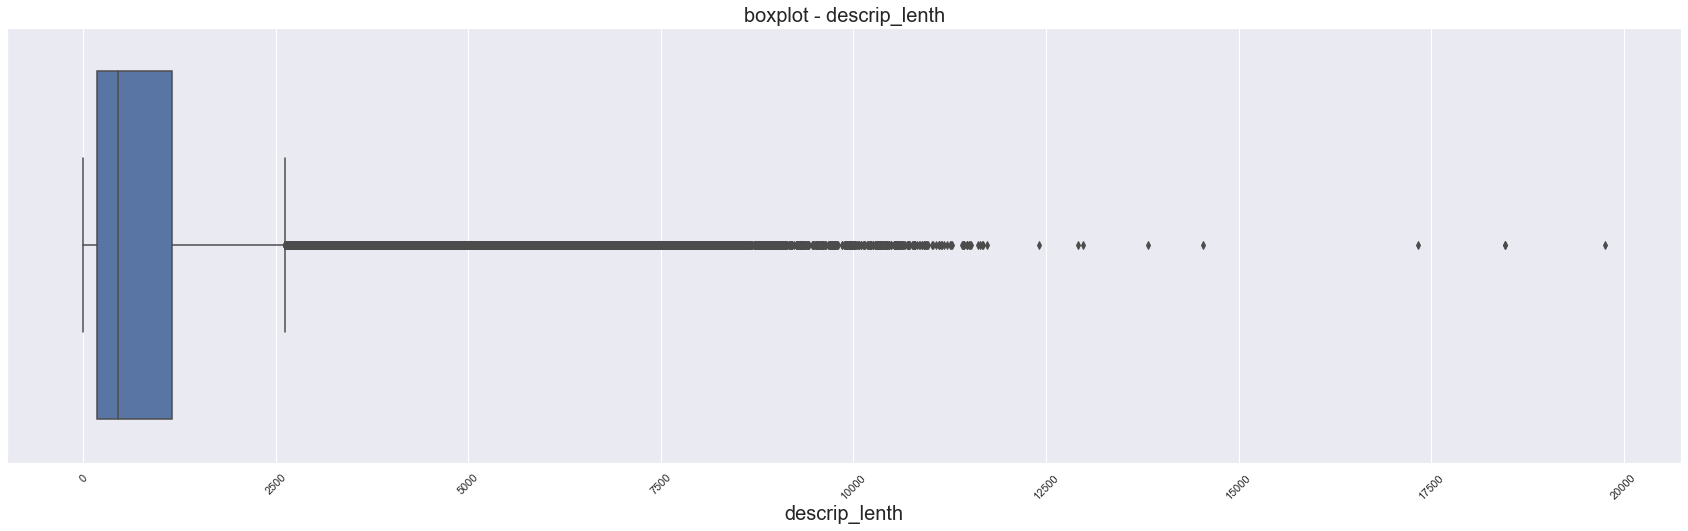

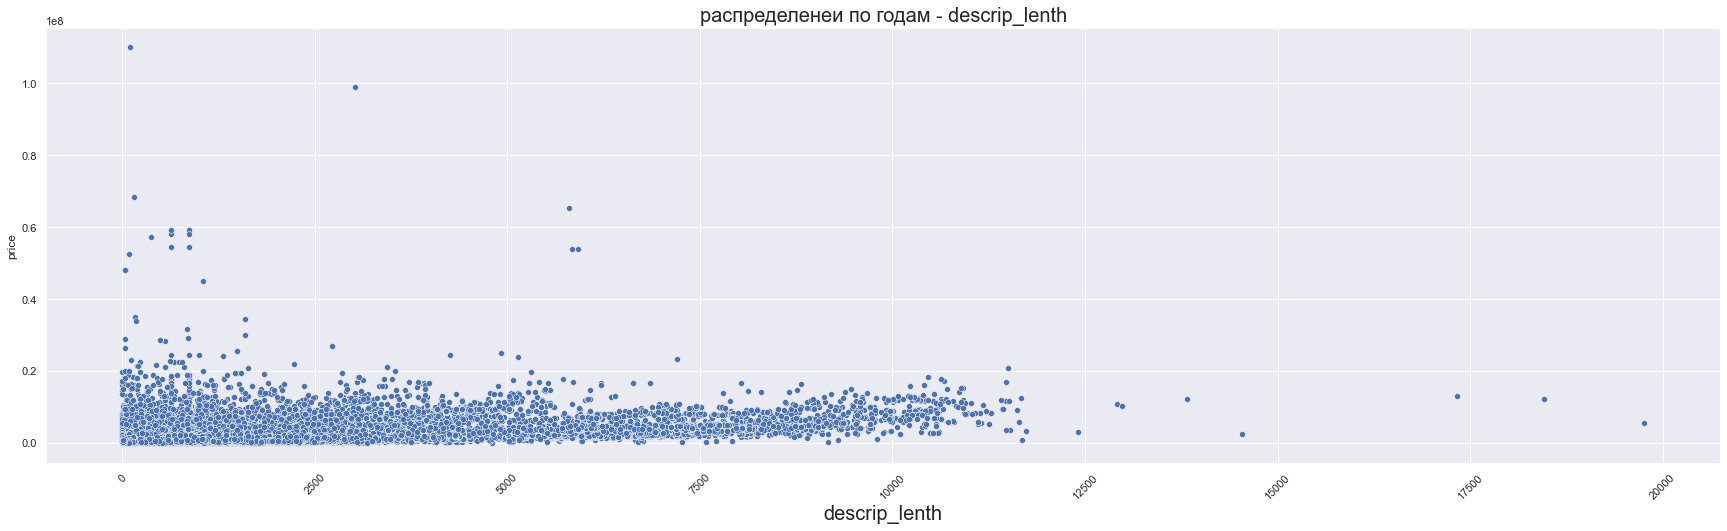

In [701]:
analiz_number_feature(data, 'descrip_lenth', 1)

**Вывод**  - ярко выраженной зависимости не налюдается

# mileage_year
    Пробег среднйи за год


In [702]:
data['mileage_year'] = pd.to_numeric(data['mileage'] / data['car_age']).round(2)
data['mileage_year'].replace([np.inf, -np.inf], np.nan, inplace=True)
data['mileage_year'].fillna(0, inplace=True)
data['mileage_year'] = data['mileage_year'].astype(int)

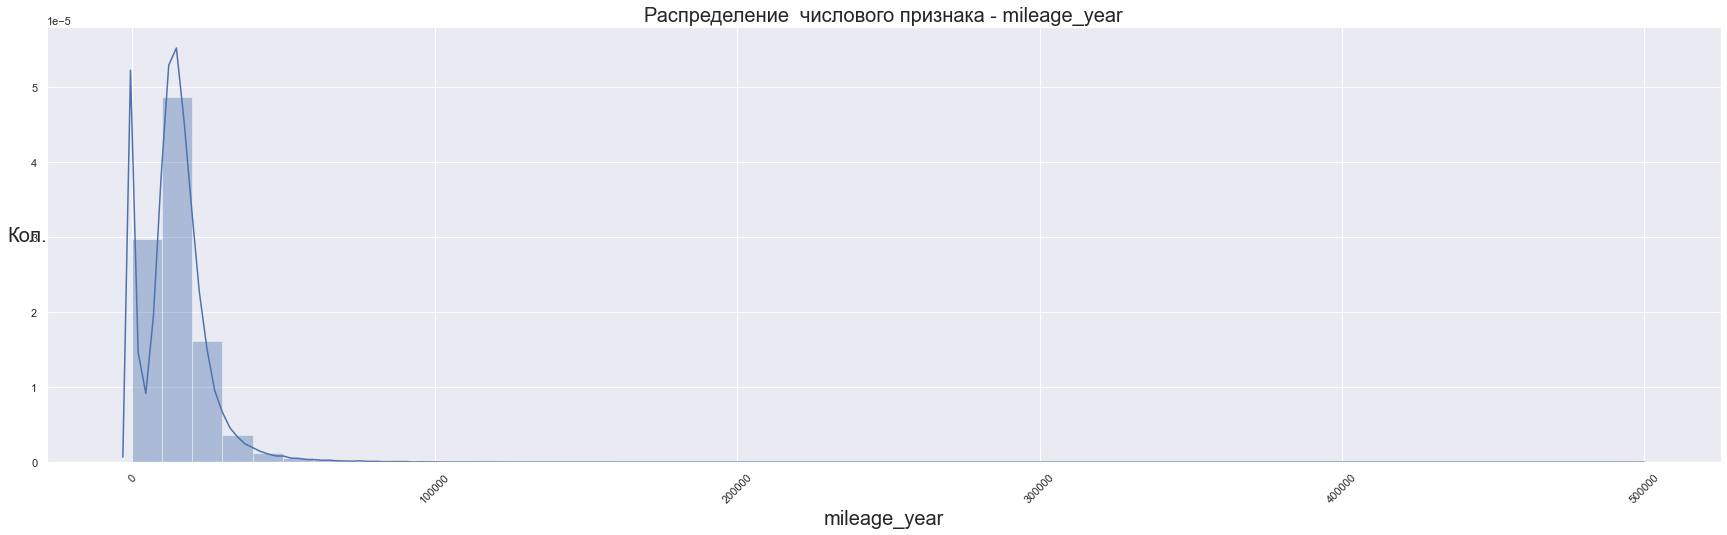

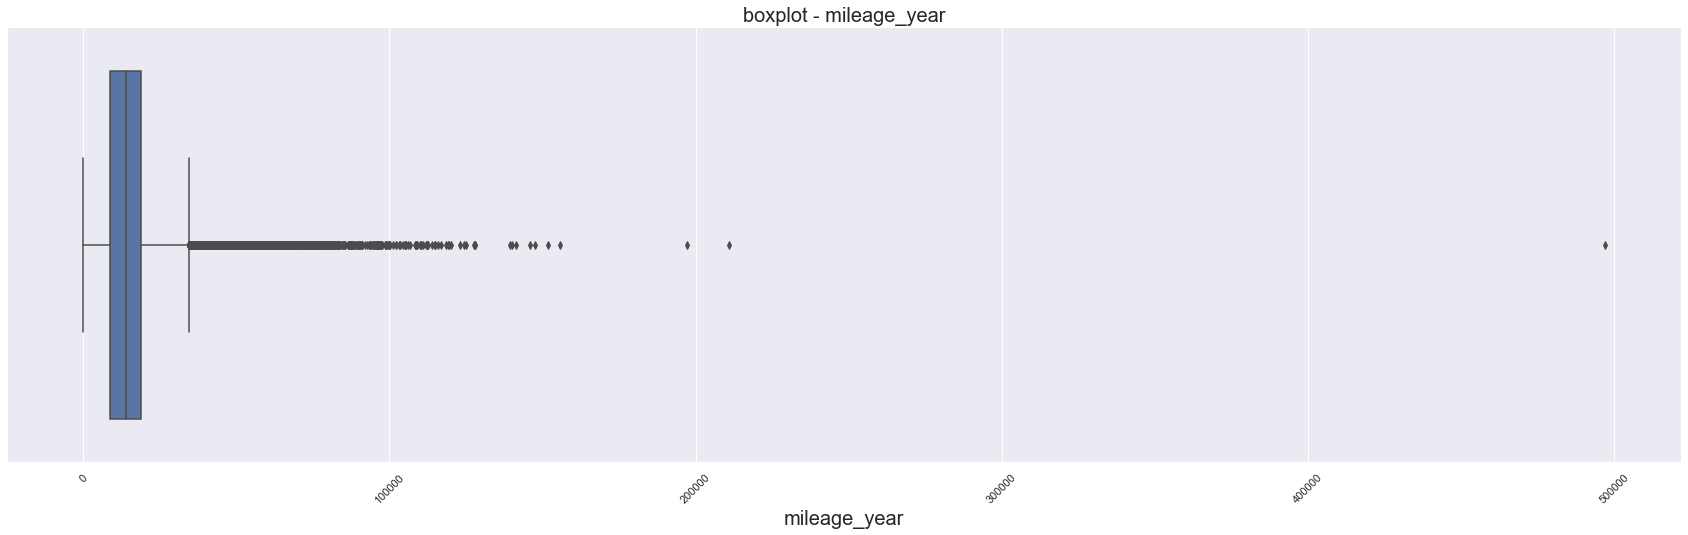

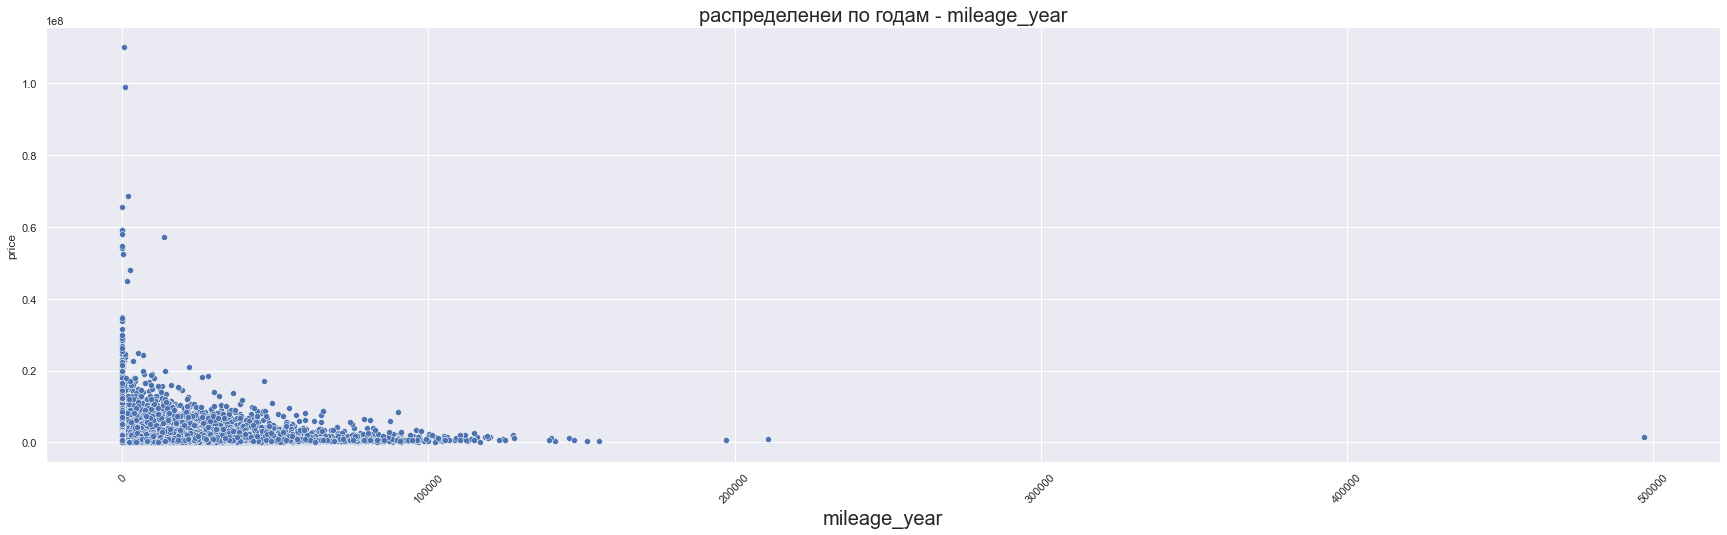

In [703]:
analiz_number_feature(data, 'mileage_year', 1)

**Вывод**  - чем больше пробег тем ниже ценаю Примем как числовой параметр


# Бинарные признаки
Бинарыне признаким нужно вообще то бы привести к балансировке (если будет время сделаю!!! )

**car_new** - новая ли машина, новый признак 

In [704]:
CAR_NEW_LIMIT = 500

def defineMileageRow(row, params, some):
    if int(row['mileage']) <= CAR_NEW_LIMIT:
        row['car_new'] = 1
    else:
        row['car_new'] = 0
    return row

def defineMileageType(data):
    data = data.apply(defineMileageRow, args=([], 1), axis=1)
    return data

data = defineMileageType(data)

In [705]:
data = defineMileageType(data)

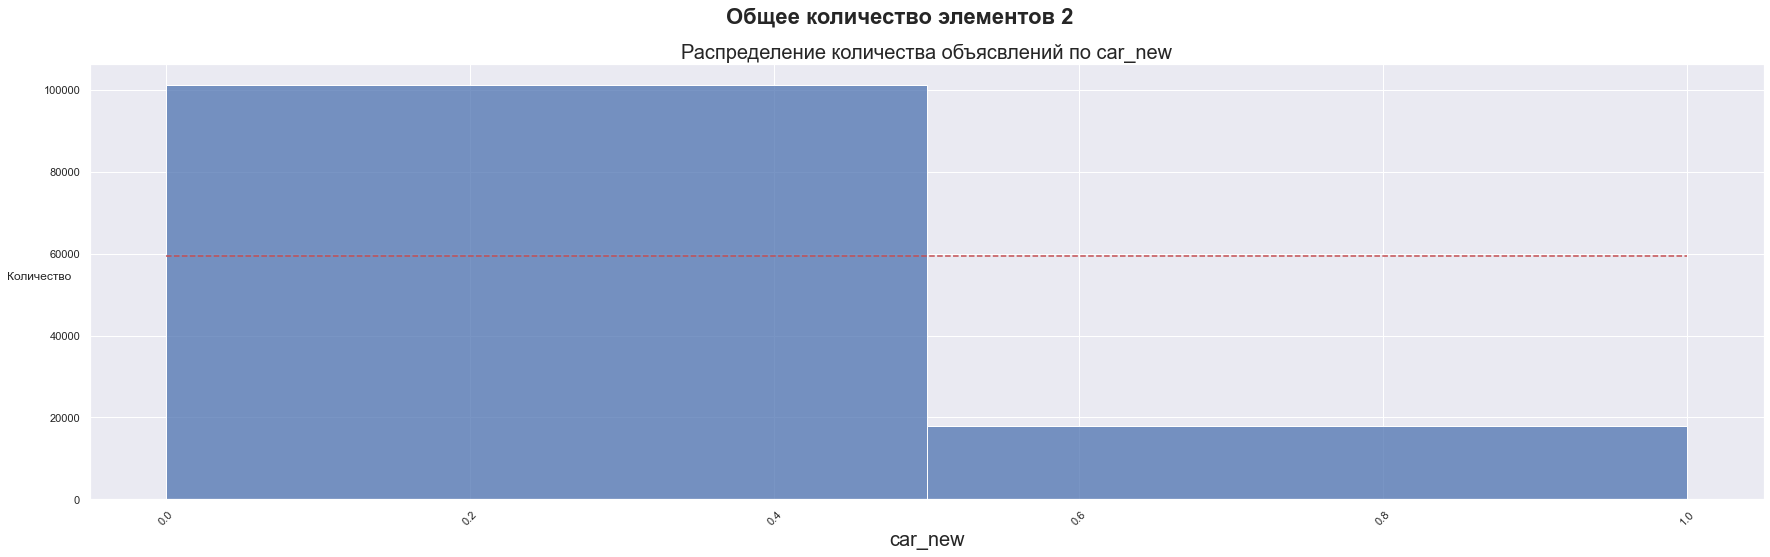

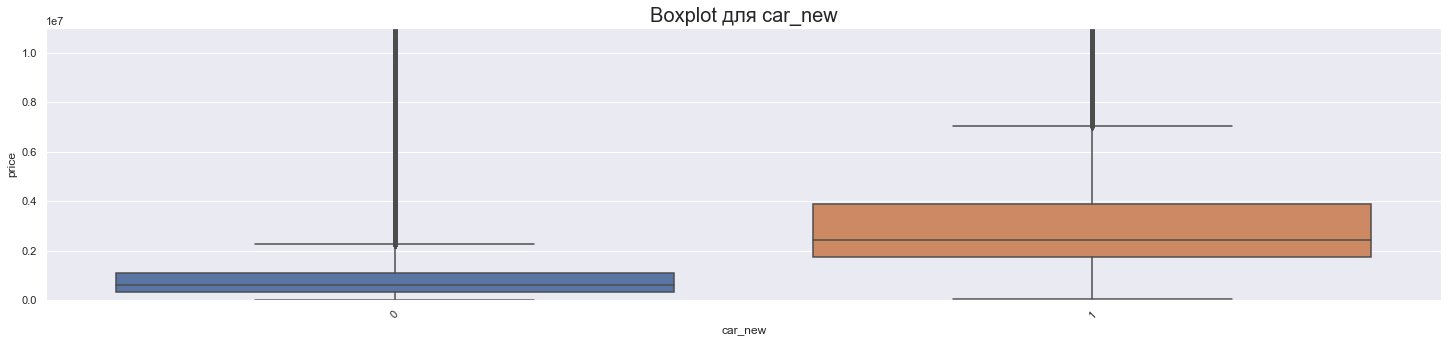

In [706]:
analiz_catigarial_feature(data, 'car_new', 1)

**Вывод**  - этот признак  напрямую влияет на цену, цена меньше с авто б/у.

# driverSide
строна Руля

In [707]:
definePopularColumn(data, 'driverSide', 1)

{'LEFT': 116798, 'RIGHT': 2272}

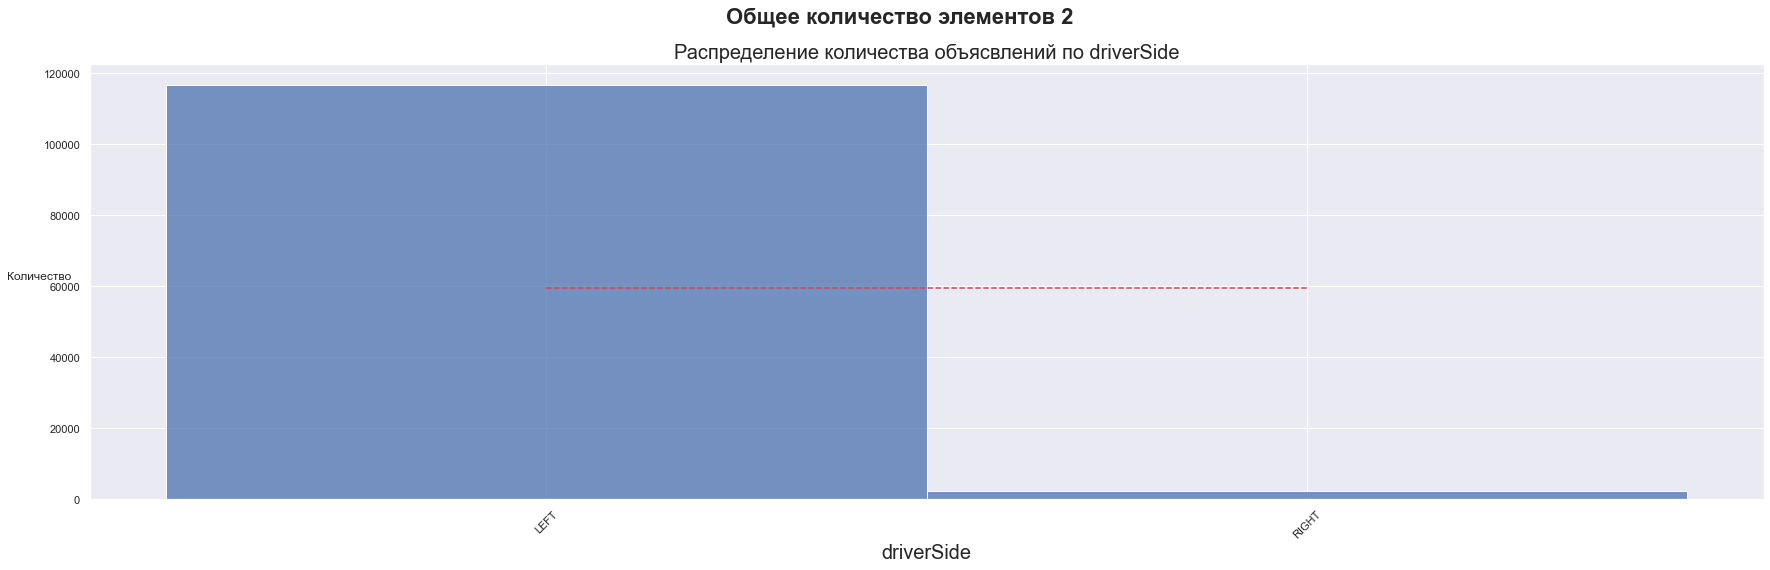

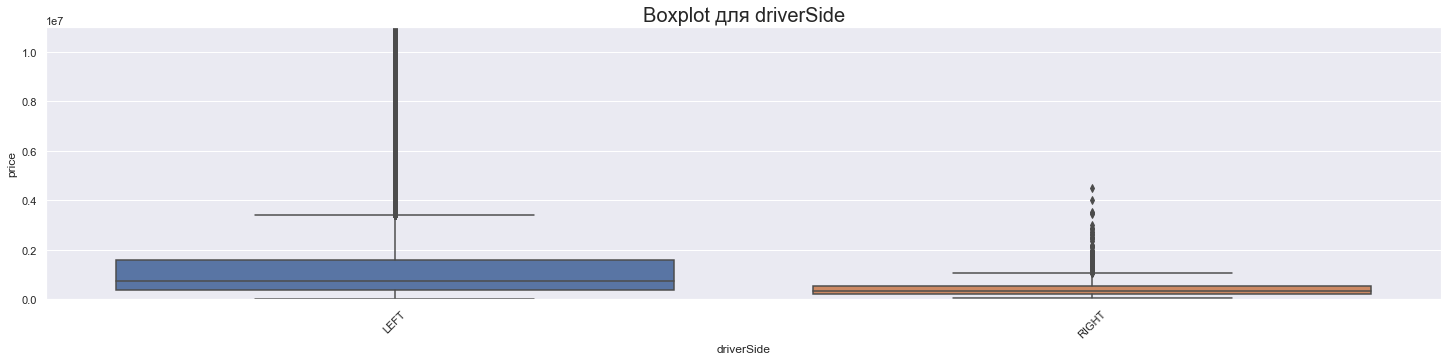

In [708]:
analiz_catigarial_feature(train, 'driverSide', 1)

**Вывод**  - этот признак  напрямую влияет на цены.

# pts
строка ПТС

In [709]:
definePopularColumn(data, 'pts', 1)

{'ORIGINAL': 82237, 'DUPLICATE': 36833}

In [710]:
definePopularColumn(data, 'pts', 0)

{'ORIGINAL': 30099, 'DUPLICATE': 4587}

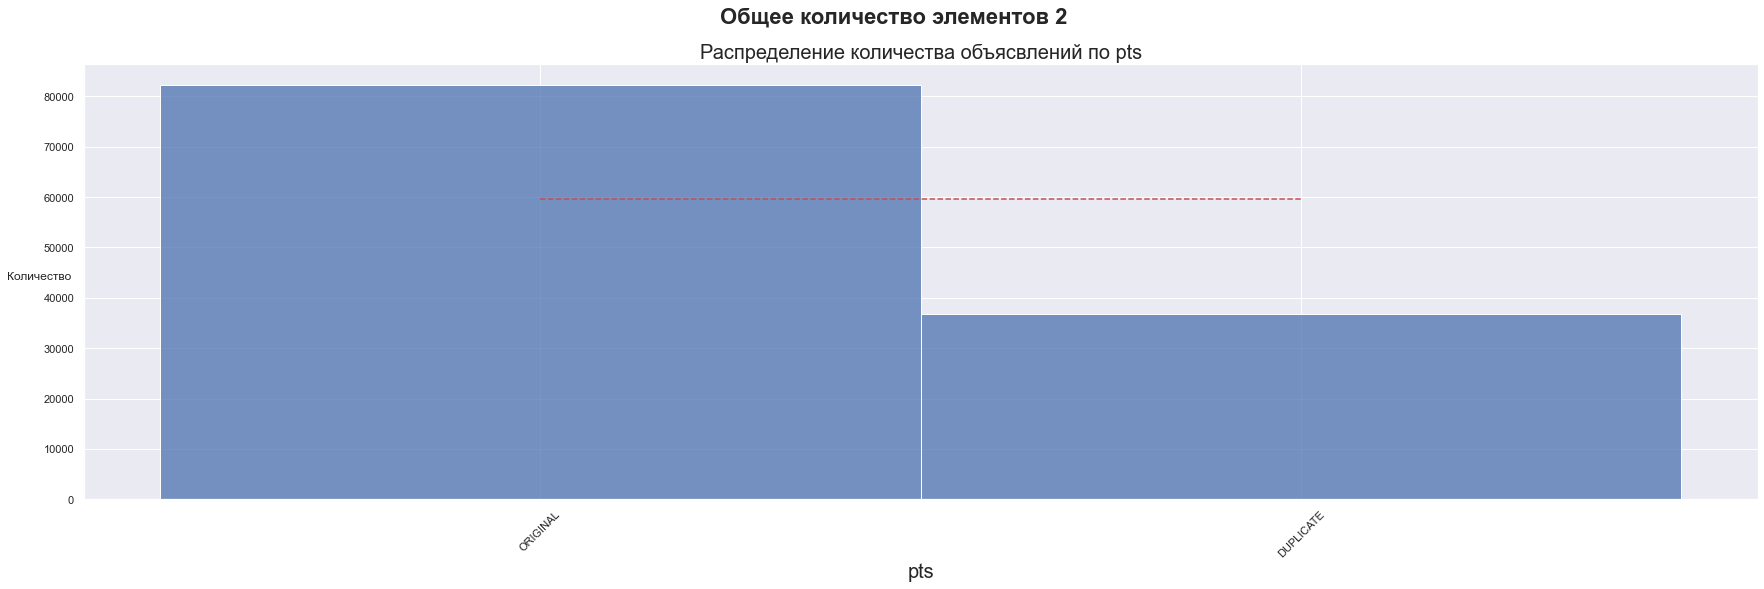

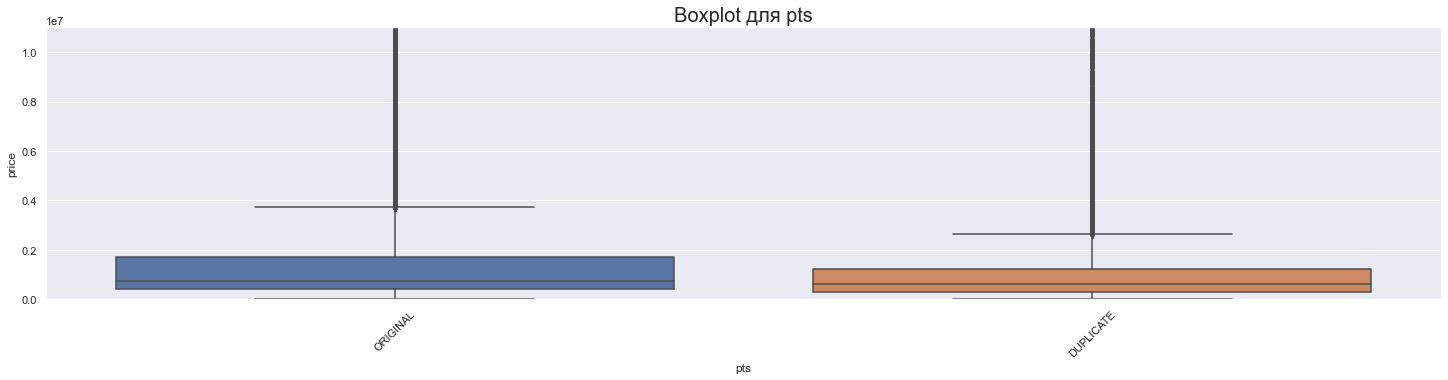

In [711]:
analiz_catigarial_feature(train, 'pts', 1)

# state
 состояние авто

In [712]:
definePopularColumn(data, 'state', 1)

{'repair_no': 119067, 'repair_yes': 3}

In [713]:
definePopularColumn(data, 'state', 0)

{'repair_no': 34686}

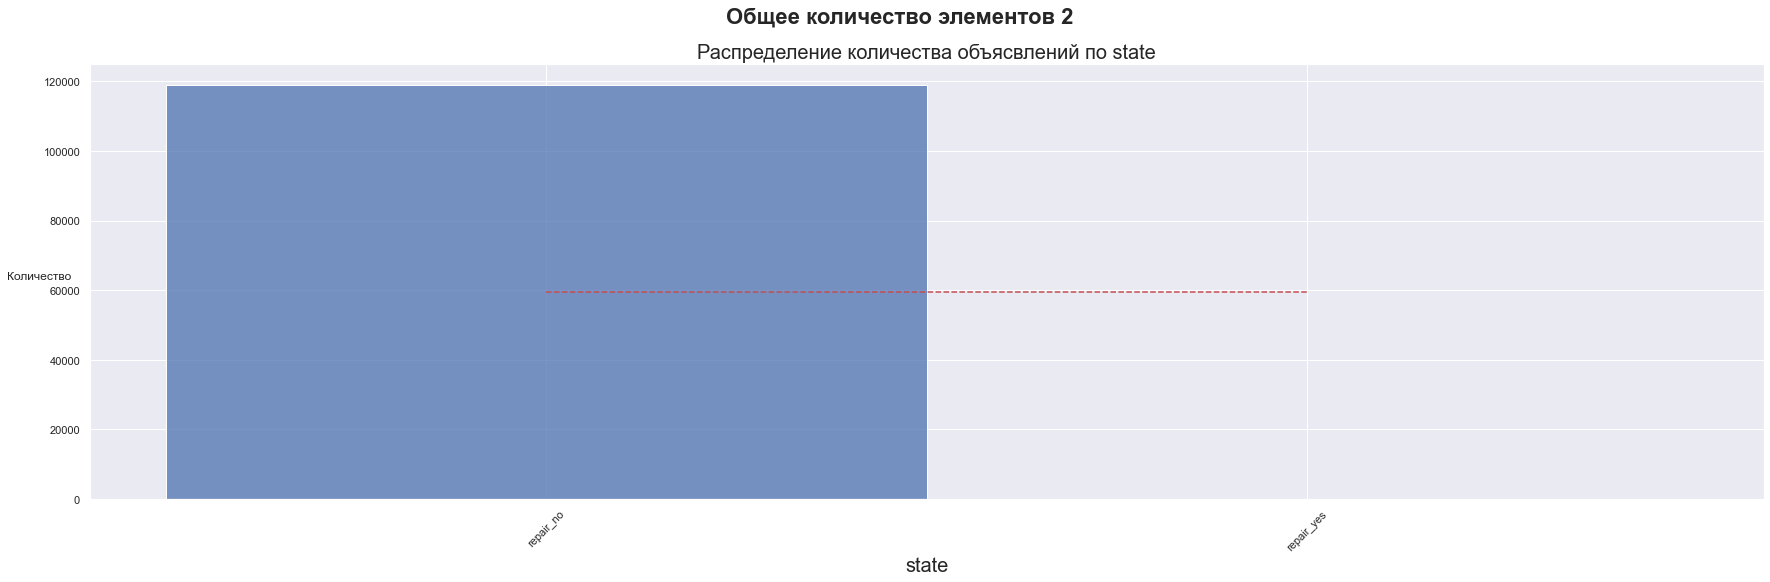

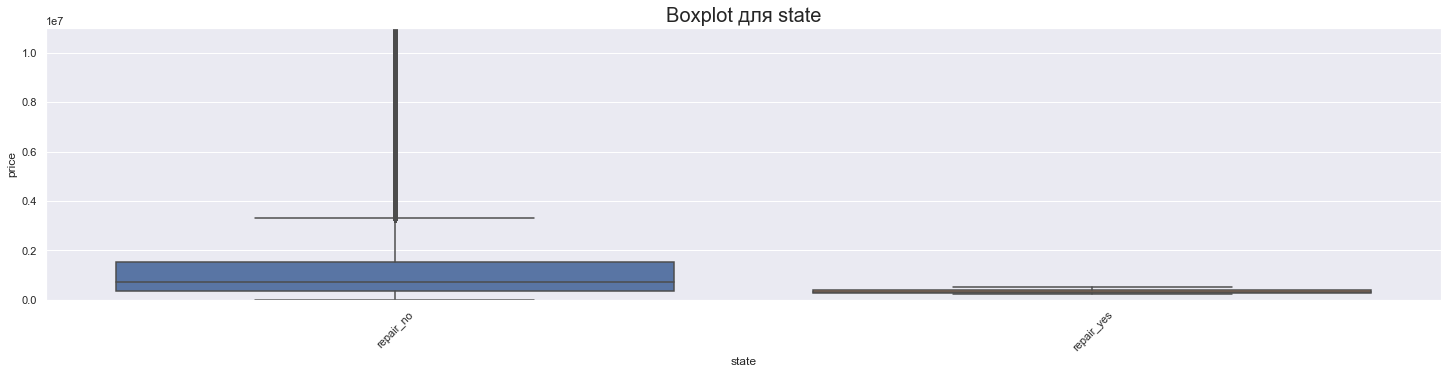

In [714]:
analiz_catigarial_feature(train, 'state', 1)

# Предварительный анализ 
## Числовых , категориалных и бинарных признаков

Кореляции и влияние на целевой показатель 

In [715]:
X = data.query('sample == 1')

In [717]:
target_col = ['price']
target_col_log  = ['price_log']

num_cols = ['modelDate', 'productionDate',  'production_model', 'enginePower', 'engineDisplacement', 'car_age', 
            'mileage', 'racing', 'descrip_lenth', 'mileage_year']
bin_cols = ['car_new', 'driverSide', 'pts', 'state']

cat_cols = ['brand', 'bodyType', 'color', 'fuelType', 'drivertrain', 'vendor', 'ownersCount',
         'numberOfDoors', 'vehicleTransmission', 'model']



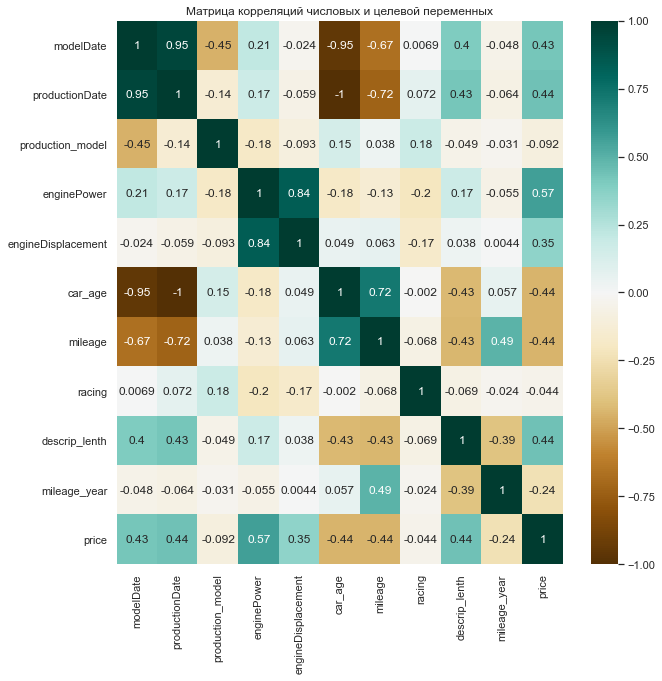

In [718]:
# Построим матрицу корреляций
fig, axes = plt.subplots(figsize=(10, 10))
data_pic = data.query('sample == 1')
heatmap = sns.heatmap(data_pic[num_cols + target_col].corr(), vmin=-1,
                      vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций числовых и целевой переменных')
plt.show()

In [721]:
# удалми высококорреливаронные величины
num_cols.remove('modelDate')
num_cols.remove('productionDate')
num_cols.remove('car_age')
num_cols.remove('engineDisplacement')

ValueError: list.remove(x): x not in list

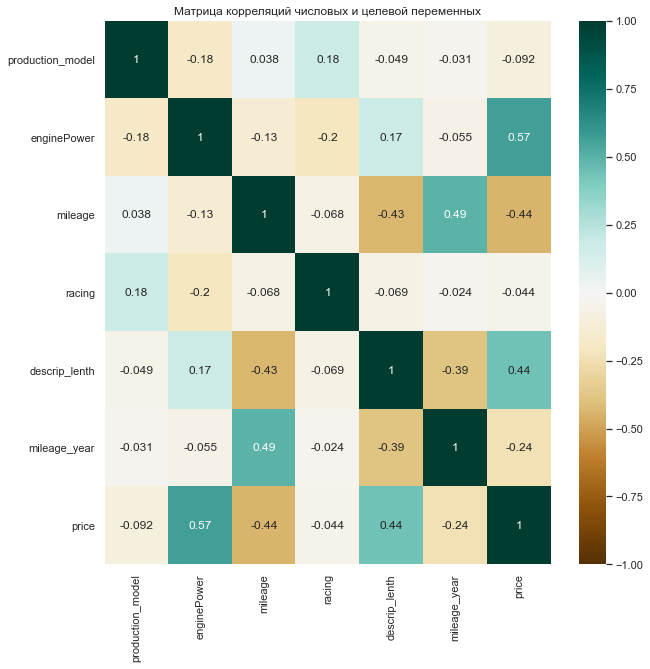

In [722]:
fig, axes = plt.subplots(figsize=(10, 10))
data_pic = data.query('sample == 1')
heatmap = sns.heatmap(data_pic[num_cols + target_col].corr(), vmin=-1,
                      vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций числовых и целевой переменных')
plt.show()

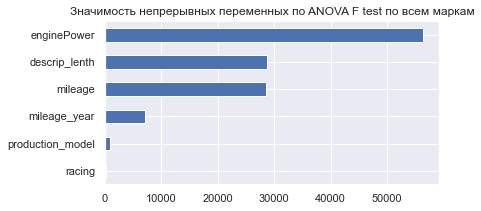

In [723]:
fig, ax = plt.subplots(figsize=(6, 3))
data_train = data[data['sample'] == 1].copy()
imp_num = pd.Series(f_regression(data_train[num_cols], data_train['price'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(
    kind='barh', title='Значимость непрерывных переменных по ANOVA F test по всем маркам')
plt.show()

In [724]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# Убедимся в преобразовании
data[bin_cols].sample(10)

car_new  driverSide  pts  state
129943        0           0    0      0
84051         0           1    1      0
52474         0           0    1      0
148341        0           0    0      0
128338        0           0    0      0
149233        0           0    0      0
94602         0           0    1      0
123743        0           0    0      0
105306        0           0    1      0
48585         0           0    1      0

## Категориальные переменные

In [725]:
# Labels encoding for all
for colum in cat_cols:
    data[colum] = data[colum].astype('category').cat.codes
    

In [726]:
data[cat_cols].sample(10)

brand  bodyType  color  fuelType  drivertrain  vendor  ownersCount  \
61304      38        10     15         0            0       2            3   
112886     33         1     11         0            2       2            3   
26298      83        15      1         0            1       3            1   
126620     84        15      5         0            1       3            2   
98268      80         1      0         0            2       4            2   
31375      84         1     12         0            2       3            3   
51958      15        10     11         4            1       3            0   
84987      63         1     15         0            2       4            0   
1042       75         8      1         0            1       3            3   
135214      3         5      1         0            1       3            2   

        numberOfDoors  vehicleTransmission  model  
61304               4                    0    484  
112886              4                    2    492  
26298               3                    2    726  
126620              3                    0      0  
98268               4                    2    473  
31375               4                    0   1068  
51958               4                    0    897  
84987               4                    1   1062  
1042                4                    0    788  
135214              1                    1      0

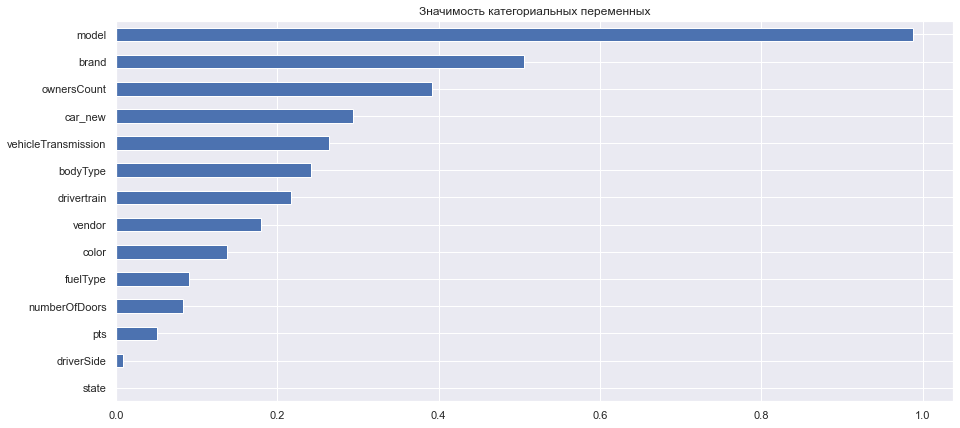

In [727]:
# Оценим значимость бинарных и категориальных признаков
fig, ax = plt.subplots(figsize=(15, 7))
data_train = data[data['sample'] == 1].copy()

imp_cat = pd.Series(mutual_info_regression(
    data_train[list(set(bin_cols+cat_cols))], data_train['price'], discrete_features=True), index=list(set(bin_cols+cat_cols)))
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Значимость категориальных переменных')
plt.show()

## Разделение данных


In [728]:
y = data.query('sample == 1')['price']

In [729]:
X = data.query('sample == 1')[num_cols + bin_cols + cat_cols ]
X_sub = data.query('sample == 0')[num_cols + bin_cols + cat_cols ]

In [730]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# CatBoost
 та же модель которые обучалсь вначале - посмотрим на результат

In [731]:
# model = CatBoostRegressor(iterations = 10000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model.fit(X_train, y_train,
#          eval_set=(X_test, y_test),
#          verbose_eval=0,
#          use_best_model=True,
#          )

# model.save_model('catboost_single_model_baseline.model')
# predict = model.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")


In [733]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         )

model.save_model('catboost_single_model_baseline.model')

In [734]:
predict_test = np.exp(model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
#Точность модели по метрике MAPE: 17.25%

Точность модели по метрике MAPE: 17.25%


In [ ]:
**Вывод**: введение дополнительны признаков увеличило результат на 4 %, 

## LazyPredict

Ниже представлен результат выполенния. По этому результату выберем наиболее сильные модели для данной задачи предсказания цены.

In [286]:
# import lazypredict

# from lazypredict.Supervised import LazyRegressor

In [287]:
# mae = mean_absolute_error
# regr=LazyRegressor(verbose=0,predictions=True, custom_metric=mae)

# models, predictions=regr.fit(X_train, X_test, np.log(y_train), np.log(y_test))


100%|██████████| 42/42 [1:46:57<00:00, 152.79s/it]  


In [288]:
# models 

Adjusted R-Squared              R-Squared  \
Model                                                                         
XGBRegressor                                    0.95                   0.95   
ExtraTreesRegressor                             0.95                   0.95   
RandomForestRegressor                           0.95                   0.95   
LGBMRegressor                                   0.95                   0.95   
HistGradientBoostingRegressor                   0.95                   0.95   
BaggingRegressor                                0.94                   0.94   
SVR                                             0.94                   0.94   
NuSVR                                           0.94                   0.94   
MLPRegressor                                    0.94                   0.94   
GradientBoostingRegressor                       0.92                   0.92   
KNeighborsRegressor                             0.90                   0.90   
DecisionTreeRegressor                           0.89                   0.89   
ExtraTreeRegressor                              0.87                   0.87   
ElasticNetCV                                    0.82                   0.82   
LassoCV                                         0.82                   0.82   
LarsCV                                          0.82                   0.82   
LassoLarsCV                                     0.82                   0.82   
LassoLarsIC                                     0.82                   0.82   
RidgeCV                                         0.82                   0.82   
BayesianRidge                                   0.82                   0.82   
Ridge                                           0.82                   0.82   
LinearRegression                                0.82                   0.82   
TransformedTargetRegressor                      0.82                   0.82   
Lars                                            0.82                   0.82   
HuberRegressor                                  0.82                   0.82   
LinearSVR                                       0.82                   0.82   
PoissonRegressor                                0.81                   0.81   
RANSACRegressor                                 0.79                   0.79   
OrthogonalMatchingPursuitCV                     0.76                   0.76   
AdaBoostRegressor                               0.70                   0.70   
TweedieRegressor                                0.70                   0.70   
GeneralizedLinearRegressor                      0.70                   0.70   
GammaRegressor                                  0.70                   0.70   
OrthogonalMatchingPursuit                       0.66                   0.66   
PassiveAggressiveRegressor                      0.59                   0.59   
ElasticNet                                      0.19                   0.19   
DummyRegressor                                 -0.00                  -0.00   
LassoLars                                      -0.00                  -0.00   
Lasso                                          -0.00                  -0.00   
SGDRegressor                  -616080750726174080.00 -615536197094913920.00   

                                      RMSE  Time Taken  mean_absolute_error  
Model                                                                        
XGBRegressor                          0.23        4.38                 0.16  
ExtraTreesRegressor                   0.23       40.99                 0.15  
RandomForestRegressor                 0.24       53.06                 0.15  
LGBMRegressor                         0.25        0.89                 0.17  
HistGradientBoostingRegressor         0.25        2.50                 0.17  
BaggingRegressor                      0.25        5.72                 0.16  
SVR                                   0.26     1327.69                 0.17  
NuSVR        

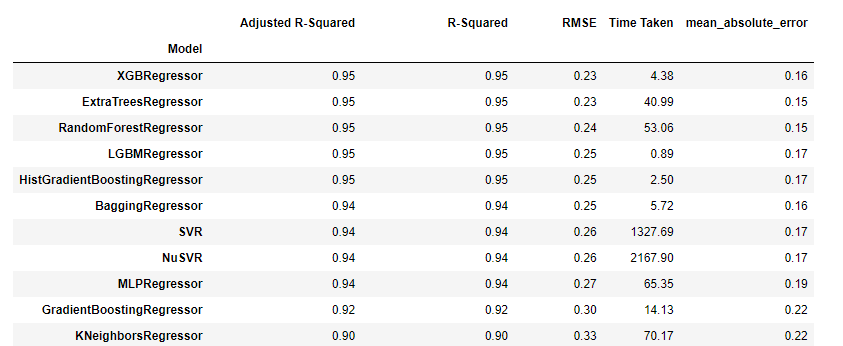


Как видно наидолее сильные модели это  XGBRegressor(бустинг на основе деревьев), ExtraTreesRegressor, RandomForestRegressor и LGBMRegressor. Проанализируем каждый алгоритм 

In [735]:
def printRezultPrice(y_test, y_pred):
    fig, axes = plt.subplots(figsize=(30, 8))
    x_ax = range(len(y_test))
    sns.lineplot(x=x_ax, y=y_test,  color='red', linewidth=3.0)
    sns.lineplot(x=x_ax, y=y_pred,  color='blue', linewidth=3.0)
    plt.title("Предсказанные цены и реальные цены", fontsize=20)
    plt.legend()
    plt.show()

def printFeature_importances_(model):
    plt.rcParams['figure.figsize'] = (10,4)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh');

# Построение моделей
 ## XGBRegressor - бустинг

In [174]:
# # Построим модель на дефолтных параметрах
# # без логарифмирования целевой переменной
# XGB = xgb.XGBRegressor(random_state = RANDOM_SEED)
# XGB.fit(X_train, y_train)
# rf_pred = XGB.predict(X_test)

# print(
#     f"Точность модели по метрике MAPE без логарифма: {(mape(y_test, rf_pred))*100:0.2f}%")

# # с логарифмированием целевой переменной
# XGB_log = xgb.XGBRegressor(random_state = RANDOM_SEED)
# XGB_log.fit(X_train, np.log(y_train))
# rf_log_pred = np.exp(XGB_log.predict(X_test))

# print(
#     f"Точность модели по метрике MAPE с логарифмом: {(mape(y_test, rf_log_pred))*100:0.2f}%")

#Точность модели по метрике MAPE без логарифма: 21.34%
# Точность модели по метрике MAPE с логарифмом: 16.21%

Точность модели по метрике MAPE без логарифма: 21.34%
Точность модели по метрике MAPE с логарифмом: 16.21%


In [178]:
#попробуем найти оптимальные параметры модели параметры 
# random_grid = { 'objective':['reg:squarederror'],
#                 'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
#                'booster':['gbtree','gblinear', 'dart'],
#                'max_depth': [int(x) for x in np.linspace(3, 15, num = 6)],
#                'learning_rate': [0.001, 0.01, 0.1],
#                'colsample_bytree': [1,1.5,2],
#                "reg_alpha"   : [0.5,0.2,1],
#                "reg_lambda"  : [2,3,5]
#               }

# XGBR_model = xgb.XGBRegressor(random_state = RANDOM_SEED)
# etr_random = RandomizedSearchCV(estimator = XGBR_model, param_distributions = random_grid, n_iter = 100, cv = 3,
#                                 verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
# etr_random.fit(X_train, np.log(y_train))
# etr_random.best_params_

# {'reg_lambda': 2,
#  'reg_alpha': 0.5,
#  'objective': 'reg:squarederror',
#  'n_estimators': 200,
#  'max_depth': 12,
#  'learning_rate': 0.1,
#  'colsample_bytree': 1,
#  'booster': 'dart'}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1556s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1384s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  3.5min
[Parallel(n_jo

{'reg_lambda': 2,
 'reg_alpha': 0.5,
 'objective': 'reg:squarederror',
 'n_estimators': 200,
 'max_depth': 12,
 'learning_rate': 0.1,
 'colsample_bytree': 1,
 'booster': 'dart'}

In [736]:
# с логарифмированием целевой переменной
# XGB_log = xgb.XGBRegressor(random_state = RANDOM_SEED,reg_lambda=2,reg_alpha=0.5, objective='reg:squarederror',
#                           n_estimators=200, max_depth=12,learning_rate=0.1,colsample_bytree=1, booster='dart'  )
# XGB_log.fit(X_train, np.log(y_train))
# rf_log_pred = np.exp(XGB_log.predict(X_test))

# print(
#     f"Точность модели по метрике MAPE с логарифмом: {(mape(y_test, rf_log_pred))*100:0.2f}%")


Точность модели по метрике MAPE с логарифмом: 13.71%


No handles with labels found to put in legend.


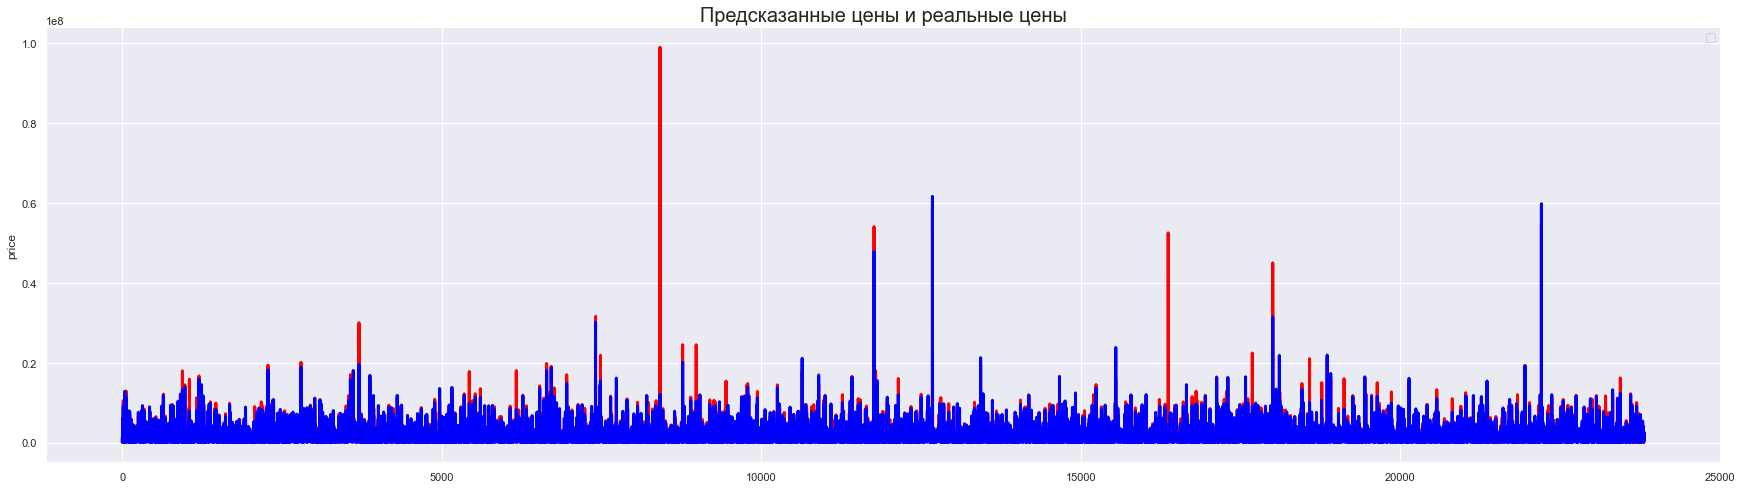

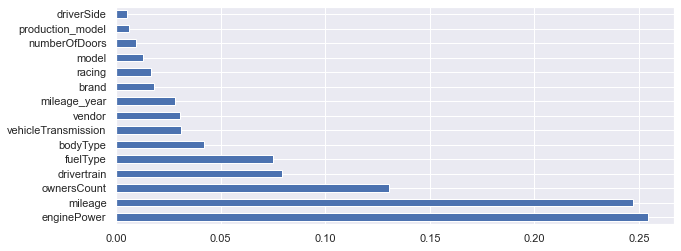

In [737]:
# printRezultPrice(y_test, rf_log_pred)
# printFeature_importances_(XGB_log)

**Вывод** - ввдение бустинга сразу позволило уменшить ошибку до 13%

 # Модель на базе **ExtraTreesRegressor**
 В сверхслучайных деревьях (Extremely Randomized Trees) больше случайности в том, как вычисляются разделения в узлах.

In [738]:
# Построим модель на дефолтных параметрах
# без логарифмирования целевой переменной
# etr = ExtraTreesRegressor(random_state = RANDOM_SEED)
# etr.fit(X_train, y_train)
# etr_pred = etr.predict(X_test)

# print(
#     f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, etr_pred))*100:0.2f}%")

# # с логарифмированием целевой переменной
# etr = ExtraTreesRegressor(random_state = RANDOM_SEED)
# etr.fit(X_train, np.log(y_train))
# etr_pred = np.exp(etr.predict(X_test))

# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, etr_pred))*100:0.2f}%")

Точность модели по метрике MAPE без логтаргета: 18.43%
Точность модели по метрике MAPE с логтаргетом: 15.42%

Точность модели по метрике MAPE без логтаргета: 18.43%
Точность модели по метрике MAPE с логтаргетом: 15.42%


In [157]:
# Попробуем подобрать гиперпараметры для нашей модели

# random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 4)],
#                'max_features': ['auto', 'sqrt','log2'],
#                'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4],
#                'bootstrap': [True, False]}

# etr = ExtraTreesRegressor(random_state = RANDOM_SEED)
# etr_random = RandomizedSearchCV(estimator = etr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
# # rf_random.fit(X_train, y_train)
# etr_random.fit(X_train, np.log(y_train))
# etr_random.best_params_

# Лучшие параметры для нашей модели
# {'n_estimators': 366,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_features': 'auto',
#  'max_depth': None,
#  'bootstrap': True}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 15

{'n_estimators': 366,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [739]:
# Обучим модель на лучших гиперпараметрах

# best_etr = ExtraTreesRegressor(random_state=RANDOM_SEED,
#                                n_estimators=366,
#                                min_samples_split=2,
#                                min_samples_leaf=1,
#                                max_features='auto',
#                                max_depth=None,
#                                bootstrap = True)
# best_etr.fit(X_train, np.log(y_train))

# predict_etr = np.exp(best_etr.predict(X_test))

# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_etr))*100:0.2f}%")

# # Точность модели по метрике MAPE с логтаргетом: 15.90%

Точность модели по метрике MAPE с логтаргетом: 15.90%


No handles with labels found to put in legend.


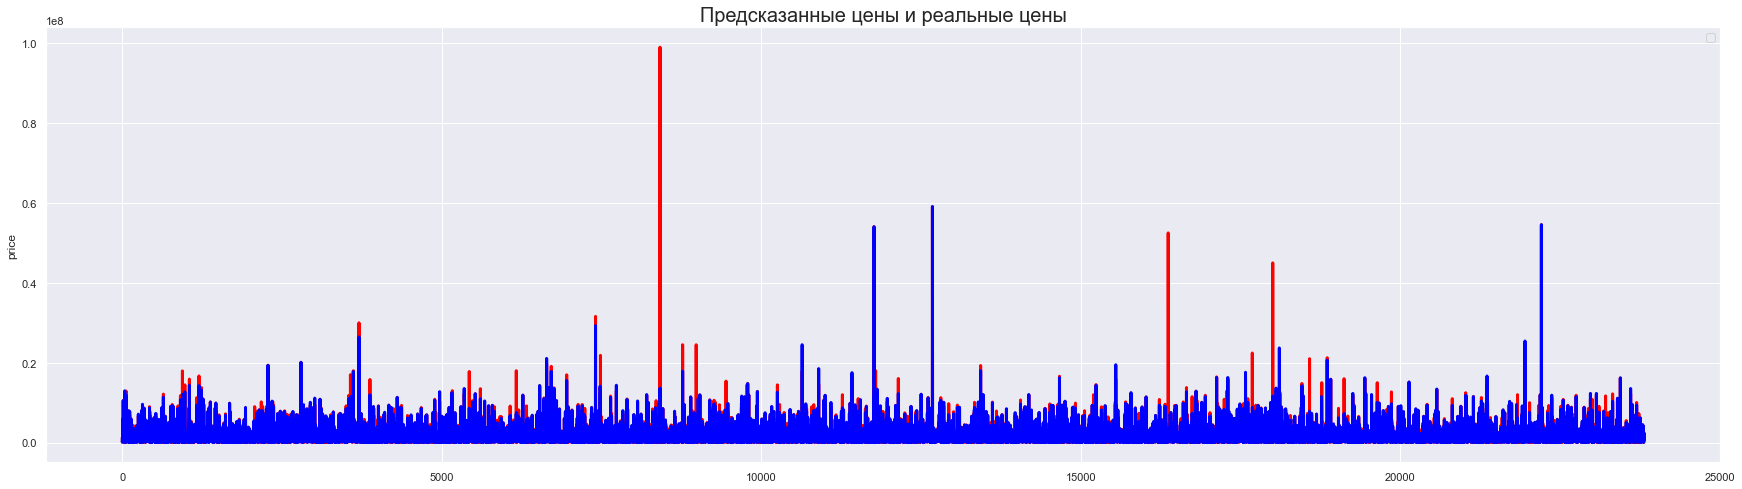

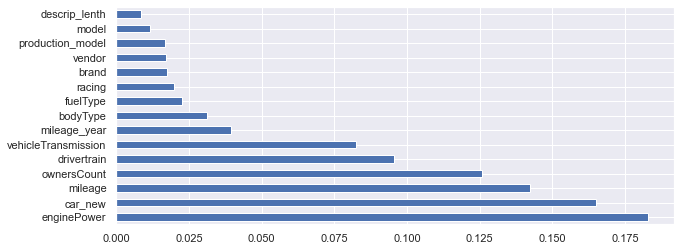

In [740]:
# printRezultPrice(y_test, etr_pred)
# printFeature_importances_(best_etr)

# Модель на базе RandomForestRegressor

In [741]:
# Построим модель на дефолтных параметрах
# без логарифмирования целевой переменной
# rf = RandomForestRegressor(random_state = RANDOM_SEED)
# rf.fit(X_train, y_train)
# rf_pred = rf.predict(X_test)

# print(
#     f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, rf_pred))*100:0.2f}%")

# # с логарифмированием целевой переменной
# rf_log = RandomForestRegressor(random_state = RANDOM_SEED)
# rf_log.fit(X_train, np.log(y_train))
# rf_log_pred = np.exp(rf_log.predict(X_test))

# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, rf_log_pred))*100:0.2f}%")

Точность модели по метрике MAPE без логтаргета: 18.61%
Точность модели по метрике MAPE с логтаргетом: 15.74%

Точность модели по метрике MAPE без логтаргета: 18.61%
Точность модели по метрике MAPE с логтаргетом: 15.74%


In [162]:
# # Попробуем подобрать гиперпараметры для нашей модели

# random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=400, num=4)],
#                'max_features': ['auto', 'sqrt', 'log2'],
#                'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4],
#                'bootstrap': [True, False]}

# rfr = RandomForestRegressor(random_state=RANDOM_SEED)
# rf_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid,
#                                n_iter=100, cv=3, verbose=10, random_state=RANDOM_SEED, n_jobs=-1)

# rf_random.fit(X_train, np.log(y_train))
# rf_random.best_params_

# # Лучшими оказались следующие параметры:
#  best_params_
#  {'bootstrap': True,
#   'max_depth': None,
#   'max_features': 'auto',
#   'min_samples_leaf': 1,
#   'min_samples_split': 2,
#   'n_estimators': 300}
#  rf_random.best_estimator_ = RandomForestRegressor(n_estimators=300, random_state=42)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 20

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'bootstrap': False}

In [742]:
# спрогнозируем с лучшими параметрами
# best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
#                       , n_estimators=400
#                       , min_samples_split=2
#                       , min_samples_leaf=1
#                       , max_features='log2'
#                       , max_depth=None
#                       , bootstrap=False)

# # best_rfr.fit(X_train, y_train)
# best_rfr.fit(X_train, np.log(y_train))

# # predict_rfr = best_rfr.predict(X_test)
# predict_rfr = np.exp(best_rfr.predict(X_test))
# print(
#     f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_rfr))*100:0.2f}%")

# Точность модели по метрике MAPE с логтаргетом: 15.54%

Точность модели по метрике MAPE с логтаргетом: 15.59%


No handles with labels found to put in legend.


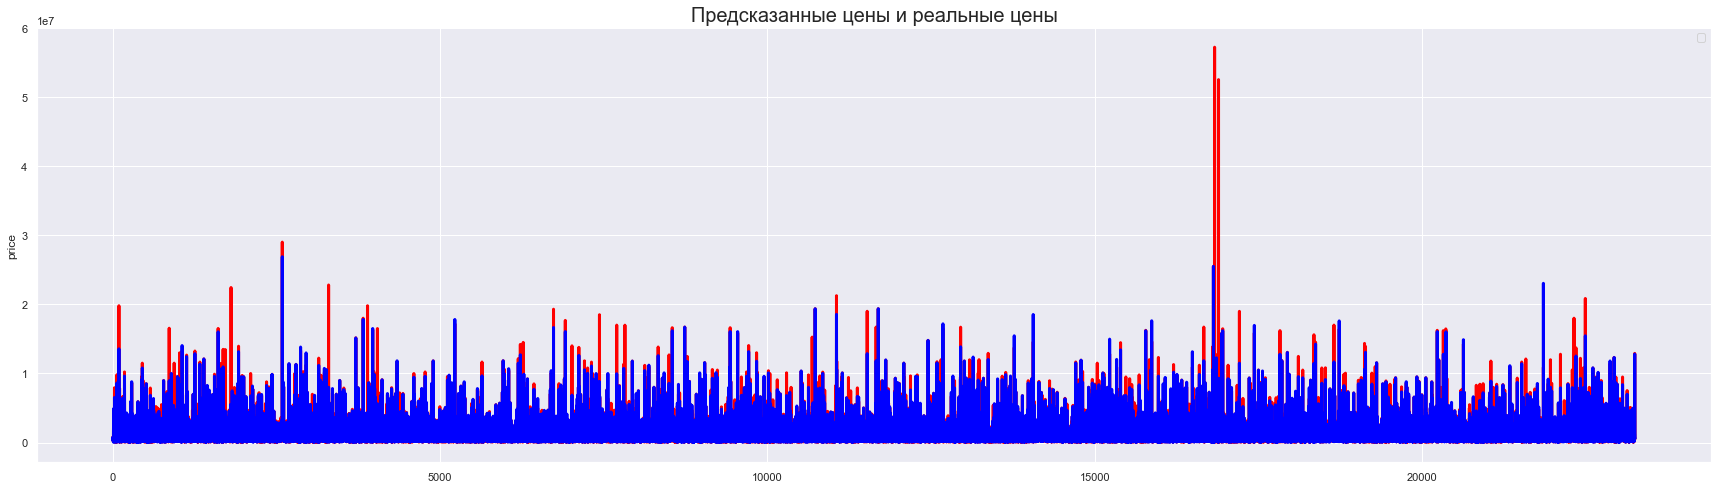

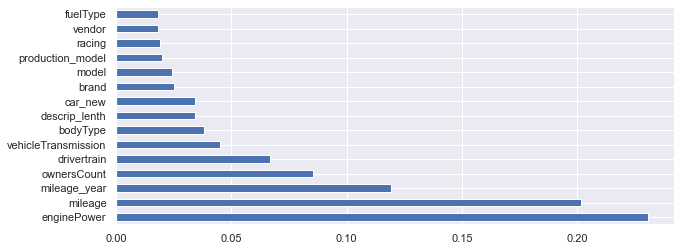

In [164]:
# printRezultPrice(y_test, predict_rfr)
# printFeature_importances_(best_rfr)

# Модель на базе LGBMRegressor

In [744]:
# Запускаем дефолтную модель на логорифме цены
# from lightgbm import LGBMRegressor

# model = LGBMRegressor(random_state=RANDOM_SEED)

# model.fit(X_train, np.log(y_train))

# hgbr_pred = np.exp(model.predict(X_test))
# predict_submission = np.exp(model.predict(X_sub))

# print(
#     f"Точность модели по метрике MAPE с логарифмом: {(mape(y_test, hgbr_pred))*100:0.2f}%")

# Точность модели по метрике MAPE с логарифмом: 17.75%

Точность модели по метрике MAPE с логарифмом: 17.91%


In [171]:
# # Попробуем подобрать гиперпараметры для нашей модели

# gridParams = {
#     'n_estimators': [int(x) for x in np.linspace(start=100, stop=400, num=4)],
#     'boosting_type': ['gbdt', 'dart', 'goss'],
#     'num_leaves': [int(x) for x in np.linspace(start=30, stop=400, num=5)],
#     'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
#     }

# model = LGBMRegressor(random_state=RANDOM_SEED)
# rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid,
#                                n_iter=100, cv=3, verbose=10, random_state=RANDOM_SEED, n_jobs=-1)

# rf_random.fit(X_train, np.log(y_train))
# rf_random.best_params_

# {'n_estimators': 400,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_features': 'log2',
#  'max_depth': None,
#  'bootstrap': False}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'bootstrap': False}

In [745]:
# lgbm_reg = LGBMRegressor(random_state=RANDOM_SEED,n_estimators=400,
#                        min_samples_split=2, min_samples_leaf=1, max_features='log2' )

# lgbm_reg.fit(X_train, np.log(y_train))

# lgbm_reg_pred = np.exp(lgbm_reg.predict(X_test))

# print(
#     f"Точность модели по метрике MAPE с логарифмом: {(mape(y_test, lgbm_reg_pred))*100:0.2f}%")


Точность модели по метрике MAPE с логарифмом: 15.22%


No handles with labels found to put in legend.


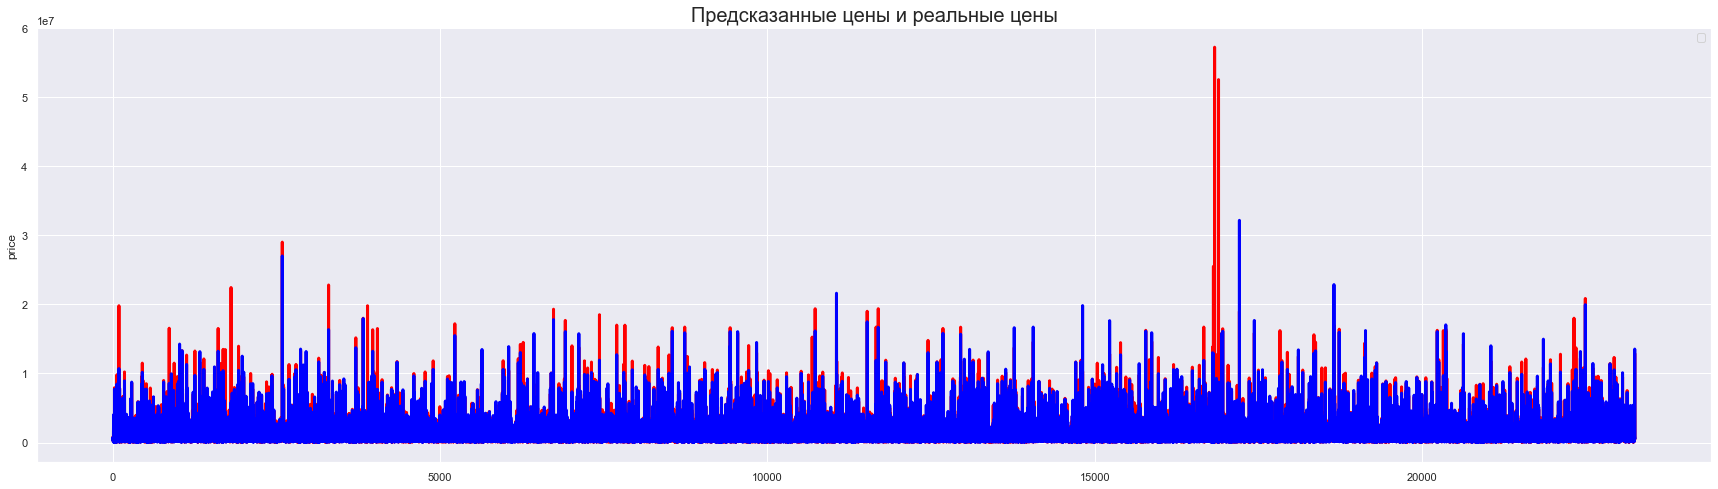

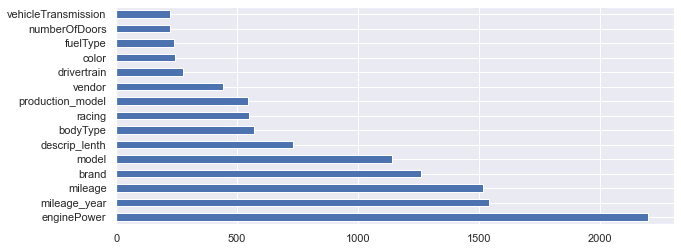

In [173]:
# printRezultPrice(y_test, lgbm_reg_pred)
# printFeature_importances_(lgbm_reg)

# StackingRegressor  стекинг
Стекинг - это когда результат работы алгоримов предсказания цены подается на новый метаалгоритм предсказания цены.
В вообщем уровднй метоалгоритмов может быть много (уровень вложенности), например что по два алгоритма подаются на один метаалгоритм первого уровеня, а дальше результаты работы метаалгоритмов первого уровеня подаются на металгоритм второго уровня. Такого пока делать не будет!! Долго! 

В качестве результирующего вначале возьмем регрессию

In [746]:
from lightgbm import LGBMRegressor
# Основные модели

XGB_stak = xgb.XGBRegressor(objective='reg:squarederror', reg_lambda=2, reg_alpha=0.5, learning_rate=0.1, \
                      max_depth=12, n_jobs=-1, n_estimators=200, random_state = RANDOM_SEED,)

best_etr_stak  = ExtraTreesRegressor(random_state=RANDOM_SEED,
                               n_estimators=366,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               max_features='auto',
                               max_depth=None,
                               bootstrap = True)

best_rfr_stak  = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=400
                      , min_samples_split=2
                      , min_samples_leaf=1
                      , max_features='log2'
                      , max_depth=None
                      , bootstrap=False)

lgbm_reg_stak = LGBMRegressor(random_state=RANDOM_SEED,
                              n_estimators=400,
                              min_samples_split=2, 
                              min_samples_leaf=1,
                              max_features='log2' )

In [747]:
 #  ExtraTreesRegressor, XGBRegressor + LinearRegression
# estimators = [('etr',best_etr_stak),
#               ('xgb_reg',XGB_stak)]

# st_ensemble = StackingRegressor(estimators=estimators,final_estimator=LinearRegression())

# # оцениваем точность
# st_ensemble.fit(X_train, np.log(y_train))
# predict_e = np.exp(st_ensemble.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

# Точность модели по метрике MAPE: 13.73%

Точность модели по метрике MAPE: 13.73%


In [748]:
 #  ExtraTreesRegressor, XGBRegressor + CatBoostRegressor
# estimators = [('etr',best_etr_stak),
#               ('xgb_reg',XGB_stak)]

# st_ensemble = StackingRegressor(estimators=estimators,final_estimator=CatBoostRegressor())

# # оцениваем точность
# st_ensemble.fit(X_train, np.log(y_train))
# predict_e = np.exp(st_ensemble.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")
# Точность модели по метрике MAPE: 13.83%

Learning rate set to 0.084109
0:	learn: 0.9831850	total: 8.52ms	remaining: 8.51s
1:	learn: 0.9085501	total: 16.1ms	remaining: 8.02s
2:	learn: 0.8402309	total: 23.3ms	remaining: 7.73s
3:	learn: 0.7787861	total: 29.9ms	remaining: 7.44s
4:	learn: 0.7223117	total: 37.1ms	remaining: 7.38s
5:	learn: 0.6706772	total: 43.4ms	remaining: 7.19s
6:	learn: 0.6232579	total: 50.5ms	remaining: 7.16s
7:	learn: 0.5796005	total: 57.2ms	remaining: 7.09s
8:	learn: 0.5404920	total: 65.1ms	remaining: 7.17s
9:	learn: 0.5045951	total: 72.6ms	remaining: 7.18s
10:	learn: 0.4721894	total: 79.3ms	remaining: 7.13s
11:	learn: 0.4430098	total: 86.3ms	remaining: 7.11s
12:	learn: 0.4166103	total: 93ms	remaining: 7.06s
13:	learn: 0.3930016	total: 100ms	remaining: 7.05s
14:	learn: 0.3715037	total: 107ms	remaining: 7.06s
15:	learn: 0.3523134	total: 114ms	remaining: 7.02s
16:	learn: 0.3351715	total: 121ms	remaining: 6.98s
17:	learn: 0.3200470	total: 127ms	remaining: 6.95s
18:	learn: 0.3064843	total: 134ms	remaining: 6.93s


185:	learn: 0.2095902	total: 1.25s	remaining: 5.49s
186:	learn: 0.2095672	total: 1.26s	remaining: 5.49s
187:	learn: 0.2095548	total: 1.27s	remaining: 5.48s
188:	learn: 0.2095463	total: 1.28s	remaining: 5.48s
189:	learn: 0.2095332	total: 1.28s	remaining: 5.47s
190:	learn: 0.2095154	total: 1.29s	remaining: 5.46s
191:	learn: 0.2094983	total: 1.3s	remaining: 5.45s
192:	learn: 0.2094838	total: 1.3s	remaining: 5.45s
193:	learn: 0.2094749	total: 1.31s	remaining: 5.44s
194:	learn: 0.2094650	total: 1.31s	remaining: 5.43s
195:	learn: 0.2094490	total: 1.32s	remaining: 5.42s
196:	learn: 0.2094427	total: 1.33s	remaining: 5.41s
197:	learn: 0.2094207	total: 1.33s	remaining: 5.4s
198:	learn: 0.2094081	total: 1.34s	remaining: 5.4s
199:	learn: 0.2093929	total: 1.35s	remaining: 5.39s
200:	learn: 0.2093734	total: 1.35s	remaining: 5.38s
201:	learn: 0.2093635	total: 1.36s	remaining: 5.37s
202:	learn: 0.2093567	total: 1.37s	remaining: 5.36s
203:	learn: 0.2093501	total: 1.37s	remaining: 5.36s
204:	learn: 0.20

366:	learn: 0.2076770	total: 2.52s	remaining: 4.35s
367:	learn: 0.2076714	total: 2.53s	remaining: 4.35s
368:	learn: 0.2076623	total: 2.54s	remaining: 4.34s
369:	learn: 0.2076511	total: 2.55s	remaining: 4.34s
370:	learn: 0.2076440	total: 2.56s	remaining: 4.33s
371:	learn: 0.2076310	total: 2.56s	remaining: 4.33s
372:	learn: 0.2076206	total: 2.57s	remaining: 4.32s
373:	learn: 0.2076142	total: 2.58s	remaining: 4.32s
374:	learn: 0.2076047	total: 2.59s	remaining: 4.31s
375:	learn: 0.2075961	total: 2.6s	remaining: 4.31s
376:	learn: 0.2075898	total: 2.6s	remaining: 4.3s
377:	learn: 0.2075846	total: 2.61s	remaining: 4.29s
378:	learn: 0.2075796	total: 2.62s	remaining: 4.29s
379:	learn: 0.2075712	total: 2.62s	remaining: 4.28s
380:	learn: 0.2075646	total: 2.63s	remaining: 4.27s
381:	learn: 0.2075580	total: 2.63s	remaining: 4.26s
382:	learn: 0.2075472	total: 2.64s	remaining: 4.26s
383:	learn: 0.2075375	total: 2.65s	remaining: 4.25s
384:	learn: 0.2075232	total: 2.65s	remaining: 4.24s
385:	learn: 0.2

549:	learn: 0.2064322	total: 3.79s	remaining: 3.1s
550:	learn: 0.2064285	total: 3.79s	remaining: 3.09s
551:	learn: 0.2064157	total: 3.8s	remaining: 3.08s
552:	learn: 0.2064079	total: 3.81s	remaining: 3.08s
553:	learn: 0.2064021	total: 3.81s	remaining: 3.07s
554:	learn: 0.2063976	total: 3.82s	remaining: 3.06s
555:	learn: 0.2063936	total: 3.83s	remaining: 3.06s
556:	learn: 0.2063853	total: 3.83s	remaining: 3.05s
557:	learn: 0.2063714	total: 3.84s	remaining: 3.04s
558:	learn: 0.2063621	total: 3.85s	remaining: 3.04s
559:	learn: 0.2063591	total: 3.85s	remaining: 3.03s
560:	learn: 0.2063552	total: 3.86s	remaining: 3.02s
561:	learn: 0.2063533	total: 3.87s	remaining: 3.01s
562:	learn: 0.2063439	total: 3.87s	remaining: 3.01s
563:	learn: 0.2063406	total: 3.88s	remaining: 3s
564:	learn: 0.2063360	total: 3.89s	remaining: 2.99s
565:	learn: 0.2063322	total: 3.89s	remaining: 2.98s
566:	learn: 0.2063260	total: 3.9s	remaining: 2.98s
567:	learn: 0.2063184	total: 3.91s	remaining: 2.97s
568:	learn: 0.2063

710:	learn: 0.2055510	total: 4.88s	remaining: 1.98s
711:	learn: 0.2055487	total: 4.88s	remaining: 1.98s
712:	learn: 0.2055431	total: 4.89s	remaining: 1.97s
713:	learn: 0.2055363	total: 4.9s	remaining: 1.96s
714:	learn: 0.2055314	total: 4.91s	remaining: 1.96s
715:	learn: 0.2055269	total: 4.91s	remaining: 1.95s
716:	learn: 0.2055222	total: 4.92s	remaining: 1.94s
717:	learn: 0.2055163	total: 4.93s	remaining: 1.94s
718:	learn: 0.2055091	total: 4.93s	remaining: 1.93s
719:	learn: 0.2055070	total: 4.94s	remaining: 1.92s
720:	learn: 0.2054996	total: 4.95s	remaining: 1.91s
721:	learn: 0.2054963	total: 4.96s	remaining: 1.91s
722:	learn: 0.2054889	total: 4.96s	remaining: 1.9s
723:	learn: 0.2054862	total: 4.97s	remaining: 1.89s
724:	learn: 0.2054826	total: 4.98s	remaining: 1.89s
725:	learn: 0.2054741	total: 4.98s	remaining: 1.88s
726:	learn: 0.2054659	total: 4.99s	remaining: 1.87s
727:	learn: 0.2054640	total: 5s	remaining: 1.87s
728:	learn: 0.2054570	total: 5s	remaining: 1.86s
729:	learn: 0.205451

870:	learn: 0.2047976	total: 5.97s	remaining: 884ms
871:	learn: 0.2047963	total: 5.97s	remaining: 877ms
872:	learn: 0.2047928	total: 5.98s	remaining: 870ms
873:	learn: 0.2047907	total: 5.99s	remaining: 863ms
874:	learn: 0.2047843	total: 5.99s	remaining: 856ms
875:	learn: 0.2047798	total: 6s	remaining: 849ms
876:	learn: 0.2047752	total: 6.01s	remaining: 842ms
877:	learn: 0.2047741	total: 6.01s	remaining: 836ms
878:	learn: 0.2047670	total: 6.02s	remaining: 829ms
879:	learn: 0.2047617	total: 6.03s	remaining: 822ms
880:	learn: 0.2047575	total: 6.03s	remaining: 815ms
881:	learn: 0.2047521	total: 6.04s	remaining: 808ms
882:	learn: 0.2047433	total: 6.05s	remaining: 801ms
883:	learn: 0.2047392	total: 6.05s	remaining: 794ms
884:	learn: 0.2047372	total: 6.06s	remaining: 787ms
885:	learn: 0.2047353	total: 6.07s	remaining: 780ms
886:	learn: 0.2047341	total: 6.07s	remaining: 773ms
887:	learn: 0.2047321	total: 6.08s	remaining: 767ms
888:	learn: 0.2047287	total: 6.08s	remaining: 760ms
889:	learn: 0.2

In [749]:
#ExtraTreesRegressor , RandomForestRegressor + LinearRegression
# estimators = [('etr', best_etr_stak),
#               ('rfr', best_rfr_stak)]

# st_ensemble_1 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# # оцениваем точность
# st_ensemble_1.fit(X_train, np.log(y_train))
# predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_1))*100:0.2f}%")
# Точность модели по метрике MAPE: 15.60%

Точность модели по метрике MAPE: 15.66%


In [750]:
# BaggingRegressor(ExtraTreesRegressor),ExtraTreesRegressor +  LinearRegression
# estimators = [('bagr', BaggingRegressor(XGB_stak)),
#               ('etr', best_etr_stak)]

# st_ensemble_1 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# # оцениваем точность
# st_ensemble_1.fit(X_train, np.log(y_train))
# predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_1))*100:0.2f}%")
# Точность модели по метрике MAPE: 13.61%

Точность модели по метрике MAPE: 13.61%


In [751]:
# BaggingRegressor(LGBMRegressor),ExtraTreesRegressor +  LinearRegression
# estimators = [('bagr', BaggingRegressor(lgbm_reg_stak)),
#               ('etr', best_etr_stak)]

# st_ensemble_1 = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# # оцениваем точность
# st_ensemble_1.fit(X_train, np.log(y_train))
# predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_1))*100:0.2f}%")
#Точность модели по метрике MAPE: 14.64%

Точность модели по метрике MAPE: 14.67%


In [ ]:
# estimators = [('etr',best_etr_stak),
#               ('xgb_reg',XGB_stak)]

# st_ensemble = StackingRegressor(estimators=estimators,final_estimator=LinearRegression())

# # оцениваем точность
# st_ensemble.fit(X_train, np.log(y_train))
# predict_e = np.exp(st_ensemble.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

# Точность модели по метрике MAPE: 13.73%

In [753]:
#BaggingRegressor(ExtraTreesRegressor),ExtraTreesRegressor +  LinearRegression
estimators = [('bagr', BaggingRegressor(XGB_stak)),
              ('rfr',best_rfr_stak ),
               ('etr', best_etr_stak)]

st_ensemble_1 = StackingRegressor(estimators=estimators, final_estimator=CatBoostRegressor())

# оцениваем точность
st_ensemble_1.fit(X_train, np.log(y_train))
predict_ensemble_1 = np.exp(st_ensemble_1.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_1))*100:0.2f}%")
# Точность модели по метрике MAPE: 13.61%

Learning rate set to 0.084109
0:	learn: 0.9837503	total: 16.5ms	remaining: 16.5s
1:	learn: 0.9088305	total: 23ms	remaining: 11.5s
2:	learn: 0.8408122	total: 30.3ms	remaining: 10.1s
3:	learn: 0.7792413	total: 36.7ms	remaining: 9.15s
4:	learn: 0.7224914	total: 43.5ms	remaining: 8.66s
5:	learn: 0.6702134	total: 50.1ms	remaining: 8.3s
6:	learn: 0.6228207	total: 56.3ms	remaining: 7.98s
7:	learn: 0.5797562	total: 64.4ms	remaining: 7.99s
8:	learn: 0.5406680	total: 70.9ms	remaining: 7.8s
9:	learn: 0.5047442	total: 78.3ms	remaining: 7.75s
10:	learn: 0.4726788	total: 84.5ms	remaining: 7.6s
11:	learn: 0.4434706	total: 91.1ms	remaining: 7.5s
12:	learn: 0.4168399	total: 97.2ms	remaining: 7.38s
13:	learn: 0.3930193	total: 104ms	remaining: 7.3s
14:	learn: 0.3718446	total: 110ms	remaining: 7.25s
15:	learn: 0.3530026	total: 117ms	remaining: 7.19s
16:	learn: 0.3361367	total: 123ms	remaining: 7.11s
17:	learn: 0.3210494	total: 129ms	remaining: 7.06s
18:	learn: 0.3075753	total: 136ms	remaining: 7.04s
19:	l

162:	learn: 0.2085756	total: 1.1s	remaining: 5.63s
163:	learn: 0.2085286	total: 1.1s	remaining: 5.62s
164:	learn: 0.2084791	total: 1.11s	remaining: 5.63s
165:	learn: 0.2084331	total: 1.12s	remaining: 5.61s
166:	learn: 0.2084023	total: 1.12s	remaining: 5.61s
167:	learn: 0.2083609	total: 1.13s	remaining: 5.6s
168:	learn: 0.2083495	total: 1.14s	remaining: 5.58s
169:	learn: 0.2083045	total: 1.14s	remaining: 5.58s
170:	learn: 0.2082763	total: 1.15s	remaining: 5.57s
171:	learn: 0.2082639	total: 1.15s	remaining: 5.55s
172:	learn: 0.2082367	total: 1.16s	remaining: 5.55s
173:	learn: 0.2081955	total: 1.17s	remaining: 5.54s
174:	learn: 0.2081687	total: 1.17s	remaining: 5.53s
175:	learn: 0.2081289	total: 1.18s	remaining: 5.52s
176:	learn: 0.2080899	total: 1.19s	remaining: 5.51s
177:	learn: 0.2080501	total: 1.19s	remaining: 5.51s
178:	learn: 0.2080423	total: 1.2s	remaining: 5.5s
179:	learn: 0.2080347	total: 1.2s	remaining: 5.49s
180:	learn: 0.2080114	total: 1.21s	remaining: 5.48s
181:	learn: 0.2079

326:	learn: 0.2050363	total: 2.19s	remaining: 4.51s
327:	learn: 0.2050127	total: 2.2s	remaining: 4.51s
328:	learn: 0.2049948	total: 2.21s	remaining: 4.51s
329:	learn: 0.2049830	total: 2.22s	remaining: 4.5s
330:	learn: 0.2049683	total: 2.23s	remaining: 4.5s
331:	learn: 0.2049602	total: 2.23s	remaining: 4.49s
332:	learn: 0.2049414	total: 2.24s	remaining: 4.49s
333:	learn: 0.2049255	total: 2.25s	remaining: 4.48s
334:	learn: 0.2049183	total: 2.25s	remaining: 4.48s
335:	learn: 0.2049106	total: 2.26s	remaining: 4.47s
336:	learn: 0.2049006	total: 2.27s	remaining: 4.46s
337:	learn: 0.2048878	total: 2.28s	remaining: 4.46s
338:	learn: 0.2048774	total: 2.28s	remaining: 4.45s
339:	learn: 0.2048612	total: 2.29s	remaining: 4.45s
340:	learn: 0.2048519	total: 2.3s	remaining: 4.44s
341:	learn: 0.2048352	total: 2.31s	remaining: 4.44s
342:	learn: 0.2048285	total: 2.31s	remaining: 4.43s
343:	learn: 0.2048185	total: 2.32s	remaining: 4.42s
344:	learn: 0.2048112	total: 2.33s	remaining: 4.42s
345:	learn: 0.20

495:	learn: 0.2029642	total: 3.49s	remaining: 3.55s
496:	learn: 0.2029463	total: 3.5s	remaining: 3.54s
497:	learn: 0.2029421	total: 3.51s	remaining: 3.54s
498:	learn: 0.2029364	total: 3.52s	remaining: 3.53s
499:	learn: 0.2029325	total: 3.52s	remaining: 3.52s
500:	learn: 0.2029252	total: 3.53s	remaining: 3.52s
501:	learn: 0.2029160	total: 3.54s	remaining: 3.51s
502:	learn: 0.2029109	total: 3.54s	remaining: 3.5s
503:	learn: 0.2028979	total: 3.55s	remaining: 3.49s
504:	learn: 0.2028864	total: 3.56s	remaining: 3.49s
505:	learn: 0.2028762	total: 3.57s	remaining: 3.48s
506:	learn: 0.2028649	total: 3.57s	remaining: 3.48s
507:	learn: 0.2028493	total: 3.58s	remaining: 3.47s
508:	learn: 0.2028374	total: 3.59s	remaining: 3.46s
509:	learn: 0.2028196	total: 3.6s	remaining: 3.46s
510:	learn: 0.2028090	total: 3.6s	remaining: 3.45s
511:	learn: 0.2028021	total: 3.61s	remaining: 3.44s
512:	learn: 0.2027835	total: 3.62s	remaining: 3.44s
513:	learn: 0.2027760	total: 3.63s	remaining: 3.43s
514:	learn: 0.20

673:	learn: 0.2013356	total: 4.78s	remaining: 2.31s
674:	learn: 0.2013249	total: 4.79s	remaining: 2.31s
675:	learn: 0.2013099	total: 4.8s	remaining: 2.3s
676:	learn: 0.2013057	total: 4.81s	remaining: 2.29s
677:	learn: 0.2012975	total: 4.82s	remaining: 2.29s
678:	learn: 0.2012940	total: 4.82s	remaining: 2.28s
679:	learn: 0.2012856	total: 4.83s	remaining: 2.27s
680:	learn: 0.2012777	total: 4.84s	remaining: 2.27s
681:	learn: 0.2012744	total: 4.85s	remaining: 2.26s
682:	learn: 0.2012712	total: 4.85s	remaining: 2.25s
683:	learn: 0.2012623	total: 4.86s	remaining: 2.25s
684:	learn: 0.2012547	total: 4.87s	remaining: 2.24s
685:	learn: 0.2012475	total: 4.87s	remaining: 2.23s
686:	learn: 0.2012371	total: 4.88s	remaining: 2.22s
687:	learn: 0.2012336	total: 4.89s	remaining: 2.22s
688:	learn: 0.2012258	total: 4.89s	remaining: 2.21s
689:	learn: 0.2012144	total: 4.9s	remaining: 2.2s
690:	learn: 0.2012092	total: 4.91s	remaining: 2.19s
691:	learn: 0.2011974	total: 4.91s	remaining: 2.19s
692:	learn: 0.20

839:	learn: 0.2000043	total: 6.09s	remaining: 1.16s
840:	learn: 0.1999966	total: 6.09s	remaining: 1.15s
841:	learn: 0.1999807	total: 6.1s	remaining: 1.15s
842:	learn: 0.1999631	total: 6.11s	remaining: 1.14s
843:	learn: 0.1999604	total: 6.12s	remaining: 1.13s
844:	learn: 0.1999568	total: 6.12s	remaining: 1.12s
845:	learn: 0.1999539	total: 6.13s	remaining: 1.11s
846:	learn: 0.1999424	total: 6.13s	remaining: 1.11s
847:	learn: 0.1999351	total: 6.14s	remaining: 1.1s
848:	learn: 0.1999267	total: 6.15s	remaining: 1.09s
849:	learn: 0.1999151	total: 6.15s	remaining: 1.08s
850:	learn: 0.1999119	total: 6.16s	remaining: 1.08s
851:	learn: 0.1999080	total: 6.16s	remaining: 1.07s
852:	learn: 0.1999067	total: 6.17s	remaining: 1.06s
853:	learn: 0.1999041	total: 6.18s	remaining: 1.05s
854:	learn: 0.1998944	total: 6.18s	remaining: 1.05s
855:	learn: 0.1998845	total: 6.19s	remaining: 1.04s
856:	learn: 0.1998761	total: 6.19s	remaining: 1.03s
857:	learn: 0.1998694	total: 6.2s	remaining: 1.03s
858:	learn: 0.1

Точность модели по метрике MAPE: 13.68%


In [145]:
predict_submission = np.exp(st_ensemble_1.predict(X_sub))

sample_submission['price'] = np.round(np.array(predict_submission)/1000,2)*1000
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

ValueError: Length of values (34685) does not match length of index (34686)

В итоге получили **MAPE 27%** на ЛБ!

Большая разница в ошибке может указывать на то что 

Применение стекинга повзволило значительно увеличить точность предсказания  (почти на 4 %), без изменния входны данных 
Тут нужно отметить, при добавлении своих спарсенных данных  точность предсказания падала, тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

**Вывод**

Выбросы в данном проекте я не удалял выбросы по признакам, это связано с тем, что я работал не со статистическими данными (экпсриементы и пр) а с реальными объявлениями. 
И выборосы тут обсуславливались больше неправильным парсингом, чем реальными выбросами. Все авто это по факту обусловленная единица (марка и модификация машины) определяет
параметры этого авто (объем двигателя, разгон и прочее). Поэтому я не проводил обработку с выбросами

    Что было сделано
    
    1. Парсинг данных с сайта auto.ru, обновление данных
    2. Приведение разных датасетов, в единеое пространство признков. 
    3. Анализ данных признаков, очитска , приведеление к одному типу
    4. Удалание высококоррелированнызх признаков
    5, Обучение различными алгоритмами
    6, Поиск оптимального алгоритма 
    
    По результатам анализа алгоримов получили следующие значения результатов:
        - XGBRegressor (бустинг) 13%
        - ExtraTreesRegressor (лес)  15.90%
        - RandomForestRegressor (лес)  15.59%
        - LGBMRegressor (бустинг) 15.22%
        
    По стекингу:
        - ExtraTreesRegressor, XGBRegressor + LinearRegression - 13.73%
        - ExtraTreesRegressor, XGBRegressor + CatBoostRegressor - 13.83%
        - ExtraTreesRegressor, RandomForestRegressor + LinearRegression - 15.66%
        - BaggingRegressor(ExtraTreesRegressor),ExtraTreesRegressor +  LinearRegression - 13.61%
        - BaggingRegressor(LGBMRegressor),ExtraTreesRegressor +  LinearRegression - 14.67%
        
    Как показал результат, неплохо с предсказанием числовой переменной справляется лес (набор слабых алгоритмов), также хорошо показал себя бустинг (последовательный набор
слабых алгоритмов) и очень неплохо зареконмавол себя стекинг. 
    Как показал результат с применение новых признаков уменьшило ошибку до 17% с 22%, а применение стэкитга еще уменьшило ошибку на 3%
    
    Таким образом важно не только генерация новых признаков , но выбор качественного алгоритма ил наборов алгоритмов.
    
    Перечислю основные моменты которые бы я применил для улучение результат (но из-за отсутсвия времени я не смог это сделать):
        - еще бы сгенерировал признаки  - выше я описал какие (это процесс бесконечный!)
        - лгарифмировал был числовые признаки - я думаю как и логарифмирование цены это уменьшит ошибку
        - для леса я думаю будут полезно провести сэмплирование категориальных признаков (сторона руля  и пр)
        
    
Для себя я  вынес , как проходит процесс очитски данных и объединение данных (заняло до 70% времени), подбор параметров моделей, выбор оптимальных моледлей  

Так как я делал один - я проешл все этапы проекта (не без помощи подлядывания в чужие решения конечно)

    